# Compare designs and xtals

## Import `Python` modules

In [7]:
import os
import time
import subprocess
import glob
import sys
import shutil
import pandas
import numpy as np
import Bio.Alphabet.IUPAC
from Bio import SeqIO
import scipy.stats
import random
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

sys.path.append('scripts/')
import design_utils

import pyrosetta
pyrosetta.init('-crystal_refine -mute all')

# Initiate directories
resultsdir = 'results/'

## Notes on modifying designs and xtals

Manual alterations with pymol

* T6
    * deleted first position (aa mismatch)
    * deleted last three res from design (not resolved)
    * removed waters from xtal
* 8_NSR
    * deleted lasat four res from design (not resolved)
    
* derroids_3_212 and derroids_3_633
    * no modifications
    
* HFuse_pH192_3_0046
    * deleted two N-terminal residues in each protomer (present in design, but not in xtal) along with het atoms.
    
* IL7
    * kept chains D and B from the xtal, then renamed chain D to be chain A to match the design
* TrkA
    * kept chains B and D from xtal then renamed them to be A and B to match the design; reordered sequence so binder design comes first; deleted N-term of TrkA receptor until it matched the sequence of the receptor from the design
    * deleted C-terminal serine from design
    
* LCB1
    * had to trim a few residues to that the design and xtal matched
    
* FGFR
    * crystalized against FGFR4 instead of FGFR2, so will only analyze designed binder as a monomer
    * kepth chains A and B from xtal then reordered sequence so binder comes first; deleted the three N-term Gs from xtal that aren't in the design

In cases where the design and crystal have one or a few differences in the amino acid sequence, make a mutant version of the design that matches the crystal

In [8]:
pdb_strs = [
    #'5H2LD_10',
    #'WSHC6', '5L6HC3_1',
    # 'BBM2nHm0589'
]
for pdb_str in pdb_strs:
    
    # Read in the design and crystal
    print("\n#-----------")
    print(pdb_str)
    original_design = os.path.join(
        'data/mod/', #'data/original_designs_mod/',
        f'{pdb_str}_design_mod.pdb'
    )
    xtal = os.path.join(
        'data/mod', # 'data/xtals_mod/',
        f'{pdb_str}_xtal_mod.pdb'
    )
    original_design_pose = pyrosetta.pose_from_pdb(original_design)
    xtal_pose = pyrosetta.pose_from_pdb(xtal)

    # Get the sequence of each. At sites where the sequences differ,
    # mutate the design to match the crystal.
    design_seq = original_design_pose.sequence()
    xtal_seq = xtal_pose.sequence()
    assert len(design_seq) == len(xtal_seq)
    for (i, (d, x)) in enumerate(zip(design_seq, xtal_seq), 1):
        if d != x:
            pyrosetta.toolbox.mutants.mutate_residue(original_design_pose, i, x)
            print(i, d, x)

    # # Finally, save the mutated design
    # mutated_design_file = f'data/designs_mod/{pdb_str}_design_mod.pdb'
    # if not os.path.isfile(mutated_design_file):
    #     print(mutated_design_file)
    #     pyrosetta.dump_pdb(original_design_pose, mutated_design_file)

## Make energy landscapes

Define energy functions

In [9]:
# Define energy functions
e_function_dict = {
    'beta16.nostab-refit' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts', #'scripts/weights_and_flags/beta16.nostab-refit_cart.wts',
        'flags_file' : None, 
        'extra_args' : [
            '-beta_nov16',
            '-corrections:beta_nov16'
        ]
    },
    'beta16_cart' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/flags_beta16', 
        'extra_args' : []
    },
    'beta16_cart_plus_hpsc_lj_changes' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart_plus_lj_changes.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/beta16_plus_hpsc_lj_changes_flags', 
        'extra_args' : []
    },

    
    'HH_run19A_step266' : {
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run19A_flags_266',
        'extra_args' : []
    },
    'HH_run19A_step266_copy' : {
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run19A_flags_266',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep1' : {
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : \
            'scripts/weights_and_flags/HH_run19A_flags_266_env_dep1',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep2' : {
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : \
            'scripts/weights_and_flags/HH_run19A_flags_266_env_dep2',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep3' : {
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : \
            'scripts/weights_and_flags/HH_run19A_flags_266_env_dep3',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep4' : {
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : \
            'scripts/weights_and_flags/HH_run19A_flags_266_env_dep4',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5a',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5b',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5c' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5c',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5c_true' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5c_true',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5c_true_low' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5c_true_low',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep5d' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep5d',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep6' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep6',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep8a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep8a',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep8a2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep8a2',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep8b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep8b',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep8c' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep8c',
        'extra_args' : []
    },

    'HH_run19A_step266_env_dep9a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep9a',
        'extra_args' : []
    },    
    'HH_run19A_step266_env_dep9b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep9b',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep11b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep11b',
        'extra_args' : []
    },
    'HH_run19A_step266_env_dep12b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep12b',
        'extra_args' : []
    },
    
    'HH_run19A_step266_dd2_elec_3_no_scale' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_3_no_scale',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_3a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_3a',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_3b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_3b',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_3c' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_3c',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_3d' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_3d',
        'extra_args' : []
    },

    'HH_run19A_step266_dd2_elec_4_no_scale' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_4_no_scale',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_4a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_4a',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_4d' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_4d',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_4e' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_4e',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_4f' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_4f',
        'extra_args' : []
    },
    
    'HH_run19A_step266_dd_elec_4_no_scale' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_4_no_scale',
        'extra_args' : []
    },
    'HH_run19A_step266_dd_elec_4_no_scale2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_4_no_scale2',
        'extra_args' : []
    },
    'HH_run19A_step266_dd_elec_4d' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_4d',
        'extra_args' : []
    },
    'HH_run19A_step266_dd_elec_4i' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_4i',
        'extra_args' : []
    },
    
    'HH_run19A_step266_dd2_elec_5_no_scale' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5_no_scale',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a2',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a3' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a3',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a4' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a4',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a5' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a5',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a6' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a6',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a7' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a7',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a8' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a8',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a9' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a9',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a10' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a10',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a11' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a11',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a12' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a12',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a13' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a13',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5a14' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5a14',
        'extra_args' : []
    },
    
    'HH_run19A_step266_dd2_elec_5e' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5e',
        'extra_args' : []
    },

    'HH_run19A_step266_dd_elec_5_no_scale' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_5_no_scale',
        'extra_args' : []
    },
    'HH_run19A_step266_dd_elec_5a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_5a',
        'extra_args' : []
    },
    'HH_run19A_step266_dd_elec_5_no_scale2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_5_no_scale2',
        'extra_args' : []
    },
    'HH_run19A_step266_dd_elec_5g' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd_elec_5g',
        'extra_args' : []
    },
    
    'HH_run19A_step266_dd2_elec_5h_res0.5_pr2.5' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5h_res0.5_pr2.5',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5h_res0.5' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5h_res0.5',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_sol_5h_res0.5_pr2.5' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_sol_5h_res0.5_pr2.5',
        'extra_args' : []
    },
    
    'HH_run23A_step384' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23A_weights_384.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23A_flags_384',
        'extra_args' : []
    },
    'HH_run23A_step384_cf_1b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23A_weights_384.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23A_flags_384_cf_1b',
        'extra_args' : []
    },
    'HH_run23A_step384_cfnp' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23A_weights_384.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23A_flags_384_cfnp',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_1a' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1a',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_5a2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_5a2',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_5a3' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_5a3',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_5a4' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_5a4',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_5a14' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_5a14',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_5a3_14' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_5a3_14',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cf_5a2',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cf_5a3',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cf_5a3_14',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cfnp_5a3_14',
        'extra_args' : []
    },
    
    'beta_jan22' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_jan22_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta_jan22_flags',
        'extra_args' : []
    },
    
    'HH_run26B_step129_1e' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run26B_weights_129.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run26B_flags_129_1e',
        'extra_args' : []
    },
    'HH_run26B_step129_1e3_14' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run26B_weights_129.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run26B_flags_129_1e3_14',
        'extra_args' : []
    },
}

Relax designs, crystals, and AF2 predictions

In [10]:
#relax_app_path = '/home/haddox/Rosetta_optE/main/source/bin/relax.default.linuxgccrelease'
relax_app_path = '/home/haddox/Rosetta/main/source/bin/relax.default.linuxgccrelease'
bb_constraints = False
constraint_weight = 10
n_cycles = 5
no_ramp = False
relax_space = 'cartesian'
relax_space_dir = relax_space
if bb_constraints:
    relax_space_dir += f'_bb_constraints_{constraint_weight}'
    if no_ramp:
        relax_space_dir += '_no_ramp'
if n_cycles != 5:
    relax_space_dir += f'_{n_cycles}_cycles'
relax_script = 'MonomerDesign2019'

pdbs = glob.glob(os.path.join('data/mod/', '*.pdb'))
# pdbs = glob.glob(os.path.join('data/designs_mod/', '*.pdb'))
# pdbs += glob.glob(os.path.join('data/xtals_mod/', '*.pdb'))

# pdbs += glob.glob(os.path.join('data/af2_mod/', '*.pdb'))
#pdbs += glob.glob(os.path.join('results/relaxed_design/beta16.nostab-refit/', '*.pdb'))
#pdbs += glob.glob(os.path.join('results/relaxed_xtal/beta16.nostab-refit/', '*.pdb'))

e_functions = [
#     'beta16.nostab-refit',
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes'
    # 'beta_jan22',
    # 'HH_run26B_step129_1e',
    # 'HH_run26B_step129_1e3_14',
#     'HH_run19A_step266',
]
njobs = 0
for e_function in e_functions:

    # Get weights, flags, and extra args for current
    # energy function
    weights_file = e_function_dict[e_function]['cart_weights_file']
    flags_file = e_function_dict[e_function]['flags_file']
    
    # Relax each PDB 10 times
    for pdb in pdbs:
        
        # Skip over problematic PDBs
        #skip_strs = ['DHR8', 'DHR14', 'HFuse', '5H2LD', 'Sh29', 'amcl1', 'IL7', 'TrkA', 'LCB1', 'LCB3']
        skip_strs = []
        skip_pdb = False
        for skip_str in skip_strs:
            if skip_str in pdb:
                skip_pdb = True
        if skip_pdb:
            continue
        if 'clean' in pdb:
            continue
            
        # Relax PDB
        input_pdbs = [pdb]
        output_dir = os.path.join(
            'results',
            f'{relax_space_dir}_relax_cr_final',
            os.path.basename(pdb).replace('.pdb', ''),
            e_function + '/'
        )
        xtal_pdb = pdb.replace('designs', 'xtals').replace('design', 'xtal').replace('af2', 'xtal')
        extra_args = list(e_function_dict[e_function]['extra_args'])
        extra_args += [
            '-nstruct 10', '-ex1', '-ex2aro', '-linmem_ig 10',
            f'-in:file:native {xtal_pdb}',
            '-ignore_zero_occupancy false',
            '-crystal_refine',
        ]
        if bb_constraints:
            extra_args += [
                '-relax:constrain_relax_to_start_coords',
                f'-set_weights coordinate_constraint {constraint_weight}',
            ]
            if no_ramp:
                extra_args += [
                    '-relax:ramp_constraints false'
                ]
        if n_cycles != 5:
            extra_args += [
                f'-default_repeats {n_cycles}'
            ]
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        scores_file_prefix = os.path.join(output_dir, 'relax')
        sbatch_file = scores_file_prefix + '.sbatch'
        if not os.path.isfile(sbatch_file):
            print(output_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='cpu',
                memory='4g',
            )
            njobs += 1
            if njobs > 100:
                raise ValueError('test')

Make poly-glycine poses of relaxed designs

In [11]:
# Iterate over all relaxed PDBs and convert each
# into a poly-glycine pose
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16.nostab-refit',
    # 'beta_jan22',
]
relax_dirs = [
    d for d in glob.glob('results/*_relax_cr_final')
    if os.path.isdir(d)
]
# relax_dirs += [
#     d for d in glob.glob('results/*_relax_cr')
#     if os.path.isdir(d)
# ]
orig_pdbs = glob.glob(os.path.join('data/mod/', '*.pdb'))
# orig_pdbs = glob.glob(os.path.join('data/designs_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/xtals_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/af2_mod/', '*.pdb'))
njobs = 0
for e_function in e_functions:
    for relax_dir in relax_dirs:
        for orig_pdb in orig_pdbs:
            pdb_dir = os.path.join(
                relax_dir,
                os.path.basename(orig_pdb).replace('.pdb', ''),
                e_function + '/'
            )
            input_pdbs = [
                pdb for pdb in glob.glob(os.path.join(pdb_dir, '*.pdb'))
                if 'polygly' not in pdb
            ]
            for input_pdb in input_pdbs:
                output_pdb = input_pdb.replace('.pdb', '_polygly.pdb')
                sbatch_file_name = input_pdb.replace('.pdb', '_polygly.sbatch')
                if not os.path.isfile(sbatch_file_name):
                    cmd = ' '.join([
                        'python',
                        'scripts/make_poly_gly.py',
                        f'--input_pdb {input_pdb}',
                        f'--output_pdb {output_pdb}'
                    ])
                    cmd = 'source activate high_throughput_design_for_E_function_opt\n' + cmd
                    design_utils.WriteSbatchFile(
                        sbatch_file_name,
                        command=cmd,
                        queue_type='cpu',
                        memory='2g',
                    )
                    ! sbatch {sbatch_file_name}
                    njobs += 1
                    if njobs > 100:
                        raise ValueError('test')

Make a list of lowest-scoring PDBs among those that have already been scored in previous iterations of notebook

In [12]:
best_pdb_dict = {}
# orig_pdbs = glob.glob(os.path.join('data/mod/', '*.pdb'))
# # orig_pdbs = glob.glob(os.path.join('data/designs_mod/', '*.pdb'))
# # orig_pdbs += glob.glob(os.path.join('data/xtals_mod/', '*.pdb'))
# e_functions = [
#     'beta16_cart',
#     'beta16_cart_plus_hpsc_lj_changes',
#      # 'beta16.nostab-refit', 'HH_run19A_step266',
# ]
# best_pdb_dict = {}
# for orig_pdb in orig_pdbs:
#     best_pdb_dict[orig_pdb] = {}
#     for e_function in e_functions:
#         best_pdb = glob.glob(os.path.join(
#             'results/best_pdbs/',
#             os.path.basename(orig_pdb).replace('.pdb', ''),
#             e_function,
#             '*.pdb'
#         ))
#         if len(best_pdb) == 0:
#             best_pdb_dict[orig_pdb][e_function] = None
#         else:
#             assert len(best_pdb) == 1, len(best_pdb)
#             best_pdb_dict[orig_pdb][e_function] = best_pdb[0]

Score relaxed designs and corresponding poly-glycine versions of those designs, computing the RMSD of each to the starting xtal structure

In [13]:
score_app_path = '/home/haddox/Rosetta/main/source/bin/score.default.linuxgccrelease'

orig_pdbs = glob.glob(os.path.join('data/mod/', '*.pdb'))
# orig_pdbs = glob.glob(os.path.join('data/designs_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/xtals_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/af2_mod/', '*.pdb'))

e_functions = [
#     'beta16.nostab-refit',
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta_jan22',
    # 'HH_run26B_step129_1e',
    # 'HH_run26B_step129_1e3_14',
]
relax_dirs = [
    d for d in glob.glob('results/*_relax_cr_final')
    if os.path.isdir(d)
]
njobs = 0
for e_function in e_functions:
    
    all_relaxed_pdbs_dir = f'results/all_relaxed_pdbs/{e_function}/'
    if not os.path.isdir(all_relaxed_pdbs_dir):
        os.makedirs(all_relaxed_pdbs_dir)
    
    for relax_dir in relax_dirs:
    
        # Get weights, flags, and extra args for current
        # energy function
        weights_file = e_function_dict[e_function]['cart_weights_file']
        flags_file = e_function_dict[e_function]['flags_file']

        # Score each set of relaxed PDBs
        for orig_pdb in orig_pdbs:
            pdb_dir = os.path.join(
                relax_dir,
                os.path.basename(orig_pdb).replace('.pdb', ''),
                e_function + '/'
            )
            pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
            if len(pdbs) == 0:
                continue
            for pdb in pdbs:
                shutil.copy(pdb, all_relaxed_pdbs_dir)
            xtal_pdb = orig_pdb.replace('designs', 'xtals').replace('design', 'xtal')#.replace('af2_mod/', 'xtals_mod/').replace('af2', 'xtal')
            design_pdb = orig_pdb.replace('xtals', 'designs').replace('xtal', 'design')#.replace('af2_mod/', 'designs_mod/').replace('af2', 'design')
            rms_pdbs = [
                ('xtal_rms', xtal_pdb),
                #('design_rms', design_pdb),
                #('best_design_rms', None),
            ]
            for (rms_tag, rms_pdb) in rms_pdbs:
                if rms_tag == 'best_design_rms':
                    if design_pdb not in best_pdb_dict:
                        continue
                    if e_function not in best_pdb_dict[design_pdb]:
                        continue
                    rms_pdb = best_pdb_dict[design_pdb][e_function]
                    if rms_pdb == None:
                        continue
                    if not os.path.isfile(rms_pdb):
                        continue
                extra_args = list(e_function_dict[e_function]['extra_args'])
                extra_args += [
                    f'-in:file:native {rms_pdb}',
                    '-read_only_ATOM_entries',
                    '-ignore_zero_occupancy false',
                    '-crystal_refine',
                ]
                output_dir = os.path.join(
                    pdb_dir,
                    f'score_{rms_tag}/'
                )
                if not os.path.isdir(output_dir):
                    os.makedirs(output_dir)
                file_listing_pdbs = os.path.join(output_dir, 'pdbs.txt')
                if not os.path.isfile(file_listing_pdbs):
                    with open(file_listing_pdbs, 'w') as f:
                        for pdb in pdbs:
                            f.write(f'{pdb}\n')
                score_file_prefix = os.path.join(output_dir, e_function)
                sbatch_file = score_file_prefix + '.sbatch'
                if not os.path.isfile(sbatch_file):
                    design_utils.compute_score_using_rosettascripts(
                        score_app_path=score_app_path,
                        weights_file=weights_file,
                        output_dir=output_dir,
                        scores_file_prefix=score_file_prefix,
                        file_listing_pdbs=file_listing_pdbs,
                        extra_args=extra_args,
                        flags_file=flags_file,
                        submit_sbatch_job=True,
                        queue_type='cpu',
                        memory='2g'
                    )
                    njobs += 1
                    if njobs > 100:
                        raise ValueError('test')

Compute the ddG of protein interfaces

In [14]:
# score_app_path = '/home/haddox/Rosetta/main/source/bin/score.default.linuxgccrelease'

# orig_pdbs = glob.glob(os.path.join('data/designs_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/xtals_mod/', '*.pdb'))
# orig_pdbs = [pdb for pdb in orig_pdbs if 'binder' in pdb]

# e_functions = [
#     'beta16.nostab-refit', 'HH_run19A_step266',
#     'HH_run19A_step266_dd2_elec_4_no_scale',
#     'HH_run19A_step266_dd2_elec_4a',
#     'HH_run19A_step266_dd2_elec_4d',
#     'HH_run19A_step266_dd2_elec_4e',
#     'HH_run19A_step266_dd2_elec_4f',
#     'HH_run19A_step266_dd_elec_4_no_scale',
# ]
# relax_dirs = [
#     d for d in glob.glob('results/*_relax')
#     if os.path.isdir(d)
# ]
# for e_function in e_functions:
#     for relax_dir in relax_dirs:
    
#         # Get weights, flags, and extra args for current
#         # energy function
#         weights_file = e_function_dict[e_function]['cart_weights_file']
#         flags_file = e_function_dict[e_function]['flags_file']
#         extra_args = list(e_function_dict[e_function]['extra_args'])
#         extra_args += [
#             '-read_only_ATOM_entries',
#             '-ignore_zero_occupancy false',
#         ]

#         # Score each set of relaxed PDBs
#         for orig_pdb in orig_pdbs:
#             pdb_dir = os.path.join(
#                 relax_dir,
#                 os.path.basename(orig_pdb).replace('.pdb', ''),
#                 e_function + '/'
#             )
#             pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
#             if len(pdbs) == 0:
#                 continue


#             output_dir = os.path.join(pdb_dir, 'ddg/')
#             if not os.path.isdir(output_dir):
#                 os.makedirs(output_dir)
#             file_listing_pdbs = os.path.join(output_dir, 'pdbs.txt')
#             if not os.path.isfile(file_listing_pdbs):
#                 with open(file_listing_pdbs, 'w') as f:
#                     for pdb in pdbs:
#                         f.write(f'{pdb}\n')
#             score_file_prefix = os.path.join(output_dir, e_function)
#             sbatch_file = score_file_prefix + '.sbatch'
#             if not os.path.isfile(sbatch_file):
#                 design_utils.compute_score_using_rosettascripts(
#                     score_app_path=score_app_path,
#                     weights_file=weights_file,
#                     output_dir=output_dir,
#                     scores_file_prefix=score_file_prefix,
#                     file_listing_pdbs=file_listing_pdbs,
#                     extra_args=extra_args,
#                     flags_file=flags_file,
#                     submit_sbatch_job=True,
#                     queue_type='short',
#                     memory='2g'
#                 )
#             #raise ValueError('test')

Get the number of residues in each design/xtal pair.

In [15]:
nres_outfile = 'results/nres.csv'
orig_xtals = [pdb for pdb in glob.glob('data/mod/*_xtal_mod.pdb')]
if not os.path.isfile(nres_outfile):
    nres_dict = {
        key : []
        for key in ['orig_xtal', 'nres']
    }
    for pdb in orig_xtals:
        pose = pyrosetta.pose_from_pdb(pdb)
        nres = pose.size()
        nres_dict['orig_xtal'].append(pdb)
        nres_dict['nres'].append(nres)

    nres_df = pandas.DataFrame(nres_dict)
    nres_df.to_csv(nres_outfile, index=False)
    
nres_df = pandas.read_csv(nres_outfile)
nres_df

orig_xtal  nres
0               data/mod/6AYYA_xtal_mod.pdb   283
1              data/mod/DHD131_xtal_mod.pdb   150
2   data/mod/RPB_PLP3_R6–PLPx6_xtal_mod.pdb   320
3             data/mod/D_3_212_xtal_mod.pdb   448
4             data/mod/D_3_633_xtal_mod.pdb   436
5               data/mod/DHR76_xtal_mod.pdb   219
6                data/mod/DHR4_xtal_mod.pdb   197
7              data/mod/DHD127_xtal_mod.pdb   145
8               data/mod/LHD29_xtal_mod.pdb   129
9            data/mod/5L6HC3_1_xtal_mod.pdb   236
10              data/mod/MC2_7_xtal_mod.pdb   115
11        data/mod/BBM2nHm0589_xtal_mod.pdb   110
12               data/mod/CAV1_xtal_mod.pdb   107
13               data/mod/THR1_xtal_mod.pdb   200
14               data/mod/THR2_xtal_mod.pdb   199
15                data/mod/BB1_xtal_mod.pdb   109
16              data/mod/WSHC6_xtal_mod.pdb   414

Read in data

In [16]:
orig_pdbs = glob.glob(os.path.join('data/mod/', '*.pdb'))
# orig_pdbs = glob.glob(os.path.join('data/designs_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/xtals_mod/', '*.pdb'))
# orig_pdbs += glob.glob(os.path.join('data/af2_mod/', '*.pdb'))
# relax_dirs = [
#     d for d in glob.glob('results/*_relax')
#     if os.path.isdir(d)
# ]
relax_dirs = [
    d for d in glob.glob('results/*_relax_cr_final')
    if os.path.isdir(d)
]
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    
    # 'beta16.nostab-refit',
    # 'beta_jan22',
    # 'HH_run26B_step129_1e',
    # 'HH_run26B_step129_1e3_14',
    # 'HH_run19A_step266',
#     'HH_run20D_step384',
]
dfs = []
for e_function in e_functions:
    for relax_dir in relax_dirs:
        for orig_pdb in orig_pdbs:

#             if 'SHT29' in orig_pdb:
#                 continue
                
#             if orig_pdb in ['BBM2nHm0589', '5H2LD_10', 'WSHC6', '5L6HC3_1']:
#                 continue
            
            # Read in data from the relax step
            # if False:
            #     f = os.path.join(
            #         relax_dir,
            #         os.path.basename(orig_pdb).replace('.pdb', ''),
            #         e_function,
            #         'relax.sc'
            #     )
            #     if not os.path.isfile(f):
            #         continue
            #     df = pandas.read_csv(f, sep='\s+', skiprows=1)
            #     df['e_function'] = e_function
            #     df['relax_dir'] = os.path.split(relax_dir)[1]
            #     df['pdb'] = df['description'].apply(
            #         lambda x: os.path.basename(x)
            #     )
            #     df['orig_pdb'] = os.path.basename(orig_pdb)
            #     df['relax_or_score'] = 'relax'
            #     dfs.append(df)

            # Read in data from rescoring relaxed structures,
            # along with RMS values
            orig_xtal = orig_pdb.replace(
                'designs', 'xtals'
            ).replace(
                'design', 'xtal'
            ).replace(
                'af2_mod/', 'xtals_mod/'
            ).replace(
                'af2', 'xtal'
            )
            assert os.path.isfile(orig_xtal), orig_xtal
            rms_tags = [
                'xtal_rms', #'design_rms',
                #'best_design_rms'
            ]
            for rms_tag in rms_tags:
                f = os.path.join(
                    relax_dir,
                    os.path.basename(orig_pdb).replace('.pdb', ''),
                    e_function,
                    f'score_{rms_tag}',
                    f'{e_function}.sc'
                )
                if not os.path.isfile(f):
                    continue
                df = pandas.read_csv(f, sep='\s+')
                df['e_function'] = e_function
                df['relax_dir'] = os.path.split(relax_dir)[1]
                df['pdb'] = df['description'].apply(
                    lambda x: os.path.basename(x)[:-5]
                )
                df['relax_rep'] = df['pdb'].apply(lambda x: int(x.replace('_polygly', '')[-2:]))
                df['orig_pdb'] = os.path.basename(orig_pdb)
                df['orig_xtal'] = orig_xtal
                df['orig_design_name'] = os.path.basename(orig_xtal).replace('_xtal_mod.pdb', '')
                df['rms_tag'] = rms_tag
                df['relax_or_score'] = 'score'
                
                # Subset to the first six replicates and rank by score
                df = df[df['relax_rep'] <= 6]
                df.sort_values('score', ascending=True, inplace=True)
                df['rep_score_rank'] = df.reset_index().index + 1
                dfs.append(df)

scores_df = pandas.concat(dfs, sort=False)
del dfs

# Add columns identifying designs, xtals, and
# poly-valine poses
def design_or_xtal(x):
    if 'design' in x:
        return 'design'
    elif 'xtal' in x:
        return 'xtal'
    elif 'af2' in x:
        return 'af2'
    else:
        raise ValueError(x)
scores_df['design_or_xtal'] = scores_df['pdb'].apply(lambda x: design_or_xtal(x))
scores_df['poly_gly'] = scores_df['pdb'].str.contains('polygly')

# Add columns giving sums of different terms
scores_df['fa_elec_total'] = scores_df[[
    'fa_elec', 'fa_intra_elec', #'fa_elec_dd'
]].sum(axis=1)
scores_df['lj'] = scores_df[[
    'fa_atr', 'fa_rep',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
]].sum(axis=1)
scores_df['elec_hbsc'] = scores_df[['fa_elec_total', 'hbond_sc']].sum(axis=1)
scores_df['elec_hb'] = scores_df[[
    'fa_elec_total', 'hbond_sc', 'hbond_bb_sc',
    'hbond_lr_bb', 'hbond_sr_bb',
]].sum(axis=1)
scores_df['hb'] = scores_df[[
    'hbond_sc', 'hbond_bb_sc',
    'hbond_lr_bb', 'hbond_sr_bb',
]].sum(axis=1)
scores_df['sol'] = scores_df[[
    'fa_sol', #'fa_sol_bd',
    'lk_ball', 'lk_ball_iso',
    'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_intra_sol_xover4',
]].sum(axis=1)
scores_df['lj_elec_hbsc_sol'] = scores_df[[
    'lj', 'elec_hbsc', 'sol'
]].sum(axis=1)
scores_df['lj_elec_hb_sol'] = scores_df[[
    'lj', 'elec_hb', 'sol',
    # 'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec',
    # 'fa_intra_sol_xover4',
]].sum(axis=1)
scores_df['elec_hb_sol'] = scores_df[[
    'elec_hb', 'sol',
    # 'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec',
    # 'fa_intra_sol_xover4',
]].sum(axis=1)
scores_df['backbone torsion'] = scores_df[[
    'omega', 'p_aa_pp', 'rama_prepro',
]].sum(axis=1)
scores_df['sidechain rotamer'] = scores_df[[
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi', 'hxl_tors'
]].sum(axis=1)

scores_df['total_score'] = scores_df['score']
scores_df['total energy'] = scores_df['score']
scores_df['LJ'] = scores_df['lj']
scores_df['solvation'] = scores_df['sol']
scores_df['electrostatics'] = scores_df['fa_elec_total']
scores_df['H-bond'] = scores_df['hb']
scores_df['covalent bonding'] = scores_df['cart_bonded']

# Add a column that gives the energy difference between
# each full pose and its poly-gly counterpart. First,
# make a dataframe with only poly-gly poses
poly_gly_data = scores_df[
    (scores_df['poly_gly'] == True) &
    (scores_df['relax_or_score'].str.contains('score'))
].copy()

# ... then merge with dataframe with all scores,
# merging each poly-gly row with row of corresponding
# full-pose counterpart
poly_gly_data.rename(columns={
    'pdb' : 'poly_gly_pdb',
}, inplace=True)
poly_gly_data['pdb'] = poly_gly_data['poly_gly_pdb'].apply(
    lambda x: x.replace('_polygly', '')
)
cols_for_merge = [
    'pdb', 'e_function', 'relax_dir', 'relax_or_score',
    'rms_tag',
]
#ndup = sum(poly_gly_data.duplicated(subset=cols_for_merge))
#assert ndup == 0, ndup
#ndup = sum(scores_df.duplicated(subset=cols_for_merge))
#assert ndup == 0, ndup
scores_df = scores_df.merge(
    poly_gly_data, on=cols_for_merge,
    suffixes=('', '_poly_gly'), how='left'
)
if False:
    assert len(poly_gly_data) == len(scores_df[
        (scores_df['relax_or_score'] == 'score') &
        (scores_df['rms_tag'] == 'xtal_rms') &
        (scores_df['poly_gly'] == False)
    ])

# ... finally, add new columns that report the energy
# of a full pose subtracted by the energy of the poly-gly
# counterpart and remove rows for polygly poses
corr_cols = [
    'score', 'fa_atr', 'fa_rep', 'lj',
    'fa_elec', 'fa_elec_total', # 'fa_elec_dd',
    'hbond_sc', 'elec_hbsc', 'elec_hb',
    'sol', 'lj_elec_hbsc_sol', 'lj_elec_hb_sol',
    'elec_hb_sol',
    'hbond_bb_sc',
    'lk_ball', 'fa_sol',
    'hbond_sr_bb', 'omega', 'p_aa_pp', #'bb_tors',
    'fa_dun_rot', 'fa_dun_dev',
    'rama_prepro', 'fa_sol', 'ref',
]
for corr_col in corr_cols:
    scores_df[f'{corr_col}_corrected'] = \
        scores_df[corr_col] - scores_df[f'{corr_col}_poly_gly']
scores_df = scores_df[scores_df['poly_gly'] == False]
    
    
# Add a column giving the full path to each input PDB
scores_df['pdb_dir'] = scores_df['description'].apply(
    lambda x: '/'.join(x.split('/')[:-2])
)
base_dir = '/home/haddox/2020/compare_xtal_design_pairs/'
scores_df['pdb_path'] = scores_df.apply(
    lambda row: os.path.join(
        base_dir,
        row['pdb_dir'],
        row['pdb'] + '.pdb',
    ),
    axis=1
)

# Add column giving the length of each structure
scores_df = scores_df.merge(nres_df, on='orig_xtal')

# Read in data from Nao
# if False:
#     f = '/home/hiranumn/Landscape/Hugh_energy_landscape_1_19_2021.csv' # '/home/hiranumn/Landscape/Hugh_energy_landscape_12_9_2020.csv'
#     df = pandas.read_csv(f)
#     assert len(df) == len(set(df['pdb_path']))
#     scores_df = scores_df.merge(df, on='pdb_path', how='left')

In [17]:
e_function = 'beta16_cart' # 'beta16_cart_plus_hpsc_lj_changes'
poly_gly = False
metric = 'score'
data = scores_df[
    (scores_df['pdb'].str.contains('DHD127')) &
    # (scores_df['e_function'] == (e_function)) &
    (scores_df['relax_dir'] == 'cartesian_relax_cr_final') &
    (scores_df['poly_gly'] == poly_gly) &
    (scores_df['relax_or_score'].str.contains('score')) &
    ~(scores_df[metric].isnull())
].copy()
data.head()

SCORE:    score   fa_atr  fa_rep   fa_sol  fa_intra_atr_xover4  \
312  SCORE: -505.201 -944.664  86.279  815.125              -66.936   
313  SCORE: -505.161 -938.880  85.396  812.615              -67.272   
314  SCORE: -504.166 -948.453  87.868  819.741              -67.219   
315  SCORE: -501.834 -943.665  86.404  817.830              -67.201   
316  SCORE: -498.862 -944.399  88.317  813.857              -66.471   

     fa_intra_rep_xover4  fa_intra_sol_xover4  lk_ball  lk_ball_iso  ...  \
312               21.813               53.374  422.905     -425.028  ...   
313               21.987               52.670  421.903     -423.539  ...   
314               21.757               54.878  421.243     -427.497  ...   
315               21.718               53.507  421.256     -425.905  ...   
316               21.445               51.737  423.419     -425.329  ...   

     hbond_sr_bb_corrected  omega_corrected  p_aa_pp_corrected  \
312                    0.0           -3.011           -106.050   
313                    0.0           -2.885           -106.418   
314                    0.0           -3.145           -106.774   
315                    0.0           -3.150           -106.730   
316                    0.0           -3.011           -105.716   

     fa_dun_rot_corrected  fa_dun_dev_corrected  rama_prepro_corrected  \
312               108.670                11.498               -128.929   
313               107.824                10.907               -129.315   
314               108.165                11.326               -129.388   
315               109.029                11.331               -129.260   
316               111.311                11.575               -128.549   

     ref_corrected                                            pdb_dir  \
312       -279.857  results/cartesian_relax_cr_final/DHD127_design...   
313       -279.857  results/cartesian_relax_cr_final/DHD127_design...   
314       -279.857  results/cartesian_relax_cr_final/DHD127_design...   
315       -279.857  results/cartesian_relax_cr_final/DHD127_design...   
316       -279.857  results/cartesian_relax_cr_final/DHD127_design...   

                                              pdb_path  nres  
312  /home/haddox/2020/compare_xtal_design_pairs/re...   145  
313  /home/haddox/2020/compare_xtal_design_pairs/re...   145  
314  /home/haddox/2020/compare_xtal_design_pairs/re...   145  
315  /home/haddox/2020/compare_xtal_design_pairs/re...   145  
316  /home/haddox/2020/compare_xtal_design_pairs/re...   145  

[5 rows x 164 columns]

In [18]:
# def find_design_xtal_af2(x):
#     if 'design' in x:
#         return 'design'
#     elif 'xtal' in x: 
#         return 'xtal'
#     elif 'af2' in x:
#         return 'af2'
#     else:
#         raise ValueError(x)
# scores_df['design_xtal_af2'] = scores_df['pdb'].apply(
#     lambda x: find_design_xtal_af2(x)
# )

Write a file with scores for each all-atom pose

In [19]:
output_file = 'results/cartesian_relax_cr_final/all_scores.csv'
if not os.path.isfile(output_file):
    scores_df.to_csv(output_file, index=False)

In [21]:
scores_df.columns.values

array(['SCORE:', 'score', 'fa_atr', 'fa_rep', 'fa_sol',
       'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
       'fa_intra_sol_xover4', 'lk_ball', 'lk_ball_iso', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'fa_elec', 'fa_intra_elec', 'hbond_sr_bb',
       'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13', 'omega',
       'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'p_aa_pp', 'hxl_tors',
       'ref', 'sugar_bb', 'rama_prepro', 'cart_bonded', 'allatom_rms',
       'gdtmm', 'gdtmm1_1', 'gdtmm2_2', 'gdtmm3_3', 'gdtmm4_3',
       'gdtmm7_4', 'irms', 'maxsub', 'maxsub2.0', 'rms', 'description',
       'e_function', 'relax_dir', 'pdb', 'relax_rep', 'orig_pdb',
       'orig_xtal', 'orig_design_name', 'rms_tag', 'relax_or_score',
       'rep_score_rank', 'design_or_xtal', 'poly_gly', 'fa_elec_total',
       'lj', 'elec_hbsc', 'elec_hb', 'hb', 'sol', 'lj_elec_hbsc_sol',
       'lj_elec_hb_sol', 'elec_hb_sol', 'backbone torsion',
       'sidechain rotamer', 'total_score', 'total energ

Identify the lowest-energy relaxed version of each input PDB (the aristos achaion). Do this separately for different energy functions.

In [22]:
# Cycle over input PDBs and energy functions
# and find the best one for each combo
# orig_pdbs = list(set(scores_df['orig_pdb']))
# e_functions = [] # ['beta16.nostab-refit'] # list(set(scores_df['e_function']))
# for orig_pdb in orig_pdbs:
#     if 'CAV1' not in orig_pdb:
#         continue
#     for e_function in e_functions:
#         for group in ['design', 'xtal']:
        
#             # Get data for the ensemble of poses of interest and
#             # find the one with the lowest score
#             data = scores_df[
#                 (scores_df['orig_pdb'] == orig_pdb) &
#                 (scores_df['relax_or_score'] == 'score') &
#                 (scores_df['e_function'] == e_function) &
#                 (scores_df['design_xtal_af2'] == group)
#             ].copy()
#             if len(data) == 0:
#                 continue
#             data.sort_values('score', inplace=True)
#             best_pdb = data.iloc[0]['description']
#             best_pdb_basename = os.path.basename(best_pdb)[:-5] + '.pdb'
#             best_pdb_dir = '/'.join(best_pdb.split('/')[:-2])
#             best_pdb = os.path.join(best_pdb_dir, best_pdb_basename)
#             assert os.path.isfile(best_pdb)

#             # Copy the PDB to a new directory
#             output_dir = os.path.join(
#                 f'results/relaxed_{group}/',
#                 e_function
#             )
#             if not os.path.isdir(output_dir):
#                 os.makedirs(output_dir)
#             new_file = os.path.join(
#                 output_dir,
#                 os.path.basename(best_pdb).replace(group, f'relaxed_{group}')
#             )[:-9] + '.pdb'
#             if not os.path.isfile(new_file):
#                 print(new_file)
#                 shutil.copy(best_pdb, new_file)

Look at scores for a specific set of PDBs

In [23]:
pandas.set_option('display.max_columns', None)

In [24]:
# cols = [
#     'pdb', 'e_function',
#     'score', 'rms',
#     'hbond_sc', 'fa_elec',
#     'hbond_sr_bb', 'hbond_sr_bb_poly_gly', 'hbond_sr_bb_corrected',
#     'fa_elec', 'fa_elec_poly_gly', 'fa_elec_corrected',
#     'fa_atr', 'fa_rep', 'lj',
#     'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb',
#     'fa_sol',
#     'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
#     'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
#     'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec',
#     'fa_intra_sol_xover4',
#     'hxl_tors',
#     'omega', 'p_aa_pp', 'rama_prepro',
#     'cart_bonded',
#     'ref', 'dslf_fa13'
# ]
# #scores_df.sort_values(['e_function', 'pdb'], inplace=True)
# scores_df.sort_values('score', inplace=True)
# e_function = 'HH_run19A_step266_dd2_elec_5a2' # 'HH_run23B_sol_elec_dd2_simple_step169' # 
# data = scores_df[
#     (scores_df['pdb'].str.contains('CAV1')) &
#     (scores_df['pdb'].str.contains('xtal')) &
#     (scores_df['e_function'] == e_function) &
#     (scores_df['relax_dir'] == 'cartesian_bb_constraints_10_no_ramp_relax_cr') &
#     (scores_df['poly_gly'] == False) &
#     (scores_df['relax_or_score'].str.contains('score'))
# ].copy()
# data[cols].head(n=10)

Which energy terms have systematic biases for crystal structures vs. designs?

In [25]:
# Designs where ref is problematic
#5H2LD_10, WSHC6, 5L6HC3_1, BBM2nHm0589

# pdb_strs = [
#     'HFuse_pH192_3_0046',
#     'derroids_3_212', 'derroids_3_633',
#     'R6PEP12',
#     'DHD127', 'DHD_131',
#     'Sh29',
#     '5L6HC3_1',
#     '6AYYA',
    
#     '5H2LD_10',
#     'WSHC6',
    
#     'MC2_7', 'CAV1', 'BBM2nHm0589',
#     'LHD29',
#     'DHR4', 'DHR8', 'DHR14', 'DHR76', 
#     'BB1',
#     'T6', '8_NSR',
    
#     'amcl1',
#     'IL7_binder',
#     'TrkA_binder',
#     'LCB1_RBD_binder',
#     'LCB3_RBD_binder',
# ]

score_terms = [
    'score',
    'fa_elec_total',
    'hbond_sc', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sr_bb', 'hb',
    'fa_atr', 'fa_rep', 'lj',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'elec_hb_sol', 'lj_elec_hb_sol',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec',
    'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'cart_bonded',
    'ref', 'dslf_fa13',
    
    'total energy',
    'electrostatics',
    'H-bond',
    'LJ',
    'solvation',
    'sidechain rotamer',
    'backbone torsion',
    'covalent bonding',
    
    'total energy_poly_gly',
    'electrostatics_poly_gly',
    'H-bond_poly_gly',
    'LJ_poly_gly',
    'solvation_poly_gly',
    'sidechain rotamer_poly_gly',
    'backbone torsion_poly_gly',
    'covalent bonding_poly_gly',
]

In [26]:
# Report number of replicate relaxes
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
dfs = []
for e_function in e_functions:
    nreps = (
        scores_df[
            (scores_df['poly_gly'] == False) &
            (scores_df['e_function'] == e_function)
        ]
        .groupby(['e_function', 'orig_xtal', 'design_or_xtal'], as_index=False).size() # [score_terms].mean()
    )
    dfs.append(nreps)
    print(e_function)
    print('nreps', '\nmin', nreps.min(), '\nmax', nreps.max(), '\nmean', nreps.mean())
nreps = pandas.concat(dfs)
    
# Make a dataframe with energy gaps
data = (
    scores_df[scores_df['rep_score_rank'] <= 1]
    .groupby(['e_function', 'orig_design_name', 'design_or_xtal', 'nres'])[score_terms].mean()
)
dfs = []
for score_term in score_terms:
    egap_data = (
        data[[score_term]]
        .reset_index()
        .pivot_table(index=['e_function', 'orig_design_name', 'nres'], columns='design_or_xtal', values=score_term)
        .reset_index()
        .assign(score_term = score_term)
        .assign(e_gap = lambda x: (x['xtal'] - x['design']) / x['nres'])
        # .assign(e_gap = lambda x: x['total_e_gap'] / )
    )
    dfs.append(egap_data)

egaps_df = pandas.concat(dfs)
#del egap_df['design_or_xtal']

beta16_cart
nreps 
min 6 
max 6 
mean 6.0
beta16_cart_plus_hpsc_lj_changes
nreps 
min 6 
max 6 
mean 6.0


In [27]:
output_file = 'results/cartesian_relax_cr_final/all_egaps.csv'
if not os.path.isfile(output_file):
    egaps_df.to_csv(output_file, index=False)

In [28]:
egaps_df.head()

design_or_xtal   e_function orig_design_name  nres    design      xtal  \
0               beta16_cart         5L6HC3_1   236  -850.735  -840.111   
1               beta16_cart            6AYYA   283 -1024.897 -1023.972   
2               beta16_cart              BB1   109  -437.634  -420.774   
3               beta16_cart      BBM2nHm0589   110  -412.523  -406.306   
4               beta16_cart             CAV1   107  -407.321  -404.432   

design_or_xtal score_term     e_gap  
0                   score  0.045017  
1                   score  0.003269  
2                   score  0.154679  
3                   score  0.056518  
4                   score  0.027000

Make sure the energy gap is zero for the `ref` energy term

In [19]:
egaps_df[
    (egaps_df['score_term'] == 'ref') &
    (egaps_df['e_function'] == 'beta16_cart')
]

design_or_xtal   e_function   orig_design_name  nres   design     xtal  \
0               beta16_cart           5L6HC3_1   236 -131.639 -131.639   
1               beta16_cart              6AYYA   283  -86.577  -86.577   
2               beta16_cart                BB1   109  -71.060  -71.060   
3               beta16_cart        BBM2nHm0589   110  -27.953  -27.953   
4               beta16_cart               CAV1   107  -24.534  -24.534   
5               beta16_cart             DHD127   145 -104.291 -104.291   
6               beta16_cart             DHD131   150 -117.118 -117.118   
7               beta16_cart               DHR4   197  -52.277  -52.277   
8               beta16_cart              DHR76   219  -34.460  -34.460   
9               beta16_cart            D_3_212   448 -143.065 -143.065   
10              beta16_cart            D_3_633   436  -97.377  -97.377   
11              beta16_cart              LHD29   129  -42.059  -42.059   
12              beta16_cart              MC2_7   115  -16.486  -16.486   
13              beta16_cart  RPB_PLP3_R6–PLPx6   320  -86.552  -86.552   
14              beta16_cart               THR1   200    5.844    5.844   
15              beta16_cart               THR2   199  -40.493  -40.493   
16              beta16_cart              WSHC6   414 -269.849 -269.849   

design_or_xtal score_term  e_gap  
0                     ref    0.0  
1                     ref    0.0  
2                     ref    0.0  
3                     ref    0.0  
4                     ref    0.0  
5                     ref    0.0  
6                     ref    0.0  
7                     ref    0.0  
8                     ref    0.0  
9                     ref    0.0  
10                    ref    0.0  
11                    ref    0.0  
12                    ref    0.0  
13                    ref    0.0  
14                    ref    0.0  
15                    ref    0.0  
16                    ref    0.0

Make a dataframe with energy gaps for each combination of energy function and design/xtal pair

In [20]:
# score_per_res = True
# n_best_scoring = 3
# all_dfs = []
# for pdb_str in pdb_strs:
#     for e_function in e_functions:

# #         if pdb_str != 'derroids_3_212':
# #             continue
# #         if e_function != 'beta16.nostab-refit':
# #             continue
        
#         # Get data for given design and energy function
#         data = scores_df[
#             (scores_df['pdb'].str.contains(pdb_str)) &
#             (scores_df['e_function'] == (e_function)) &
#             (scores_df['relax_dir'] == 'cartesian_relax_cr') &
#             (scores_df['poly_gly'] == False) &
#             (scores_df['rms_tag'] == 'xtal_rms') &
#             (scores_df['relax_or_score'].str.contains('score')) &
#             ~(scores_df['score'].isnull())
#         ].copy()
#         if len(data) == 0:
#             continue

#         # Select the three best-scoring structures for both the
#         # design and crystal and compute the mean of each energy term.
#         # If indicated, use score per res.
#         nres = list(set(data['nres']))
#         assert len(nres) == 1
#         nres = nres[0]
#         data.sort_values('score', inplace=True, ascending=True)
#         dfs = []
#         for design_or_xtal in ['design', 'xtal']:
#             data_i = data[data['design_xtal_af2'] == design_or_xtal][:n_best_scoring].copy()
#             data_i = data_i[score_terms].transpose().rename_axis('score_term',axis=0)
#             data_i['mean'] = data_i.mean(axis=1)
#             if score_per_res:
#                 data_i['mean'] = data_i['mean'] / nres
#             data_i['design_or_xtal'] = design_or_xtal
#             dfs.append(data_i)

#         # Compute the energy gap between the averaged design vs. xtal
#         # energies for each energy term from above
#         df = pandas.concat(dfs, sort=False)
#         df.reset_index(inplace=True)
#         df = df.pivot(index='score_term', columns='design_or_xtal', values='mean')
#         df['e_gap'] = df['xtal'] - df['design']
#         df['design_name'] = pdb_str
#         df['e_function'] = e_function
#         df.reset_index(inplace=True)
#         all_dfs.append(df)
    
# egaps_df = pandas.concat(all_dfs, sort=False)

beta16_cart
total energy 0.11956
electrostatics 0.11102
H-bond 0.08947
LJ 0.05256


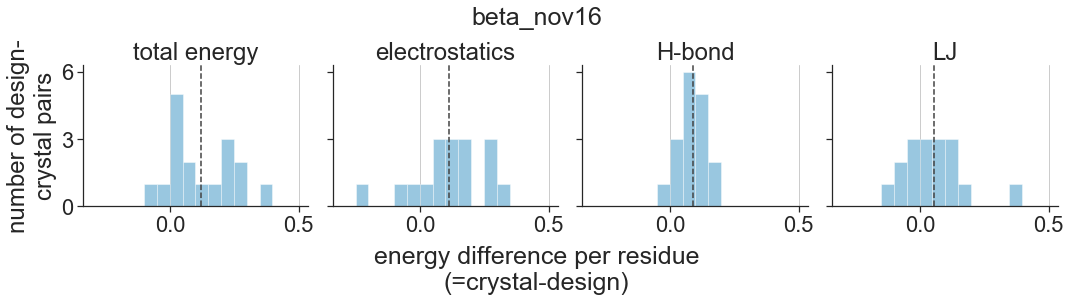

beta16_cart_plus_hpsc_lj_changes
total energy 0.12396
electrostatics 0.1259
H-bond 0.09435
LJ 0.05158


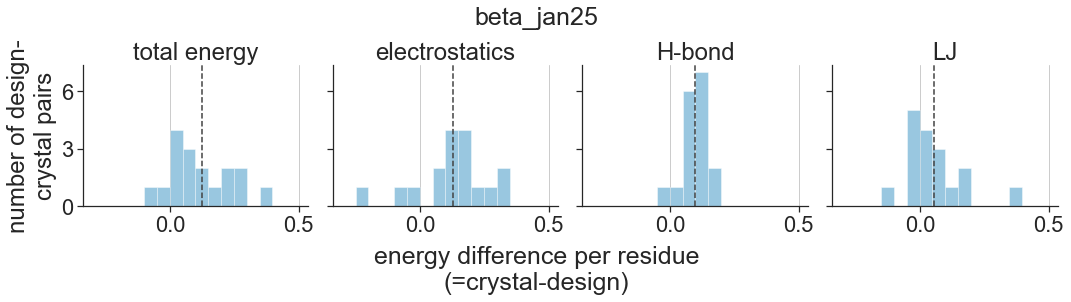

In [21]:
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
title_dict = {
    'beta16_cart' : 'beta_nov16',
    'beta16_cart_plus_hpsc_lj_changes' : 'beta_jan25',
}
for e_function in e_functions:
    print(e_function)
    (fig, axs) = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=[15,3])
    bins = np.arange(-0.3025, 0.5, 0.05)
    for (i, score_term) in enumerate(['total energy', 'electrostatics', 'H-bond', 'LJ']):
        #score_term += '_poly_gly'
        data = egaps_df[
            (egaps_df['e_function'] == e_function) &
            (egaps_df['score_term'] == score_term)
        ].copy()
        mean = round(data['e_gap'].mean(), 5)
        print(score_term, mean)
        sns.distplot(
            data['e_gap'], kde=False, bins=bins,
            ax=axs[i]
        )
        axs[i].grid(axis='x')
        axs[i].axvline(mean, ls='--', c='0.25')
        axs[i].set(
            title=score_term, #title=f'{score_term}\nmean={mean}',
            ylabel='number of design-\ncrystal pairs', xlabel='', yticks=[0, 3, 6]
        )
        if i != 0:
            axs[i].set(ylabel='')

    fig.text(0.5, -0.20, 'energy difference per residue\n(=crystal-design)', ha='center', fontsize=25)
    plt.suptitle(title_dict[e_function], y=1.11, fontsize=25)
    sns.despine()
    plt.tight_layout()
    plt.show()

Compare energies in full poses vs. poly-gly poses

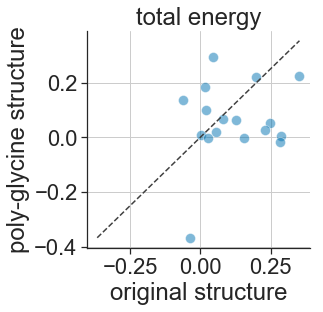

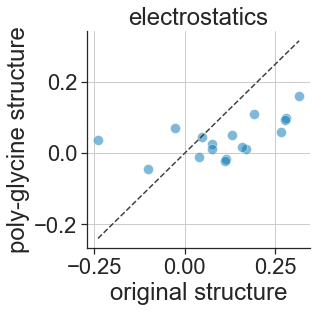

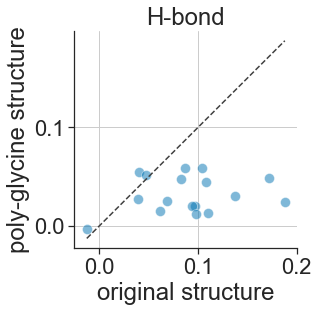

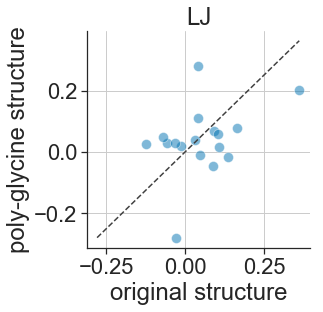

In [23]:
data =(
    egaps_df[egaps_df['e_function'] == 'beta16_cart']
    .pivot_table(index='orig_design_name', columns='score_term', values='e_gap')
    .reset_index()
)
for score_term in ['total energy', 'electrostatics', 'H-bond', 'LJ']:
    min_val = data[[score_term, f'{score_term}_poly_gly']].min().min()
    max_val = data[[score_term, f'{score_term}_poly_gly']].max().max()
    plt.figure(figsize=[4,4])
    sns.scatterplot(x=score_term, y=f'{score_term}_poly_gly', data=data, s=100, alpha=0.5)
    plt.plot([min_val, max_val], [min_val, max_val], ls='--', c='0.25')
    plt.title(score_term)
    plt.xlabel('original structure')
    plt.ylabel('poly-glycine structure')
    plt.grid()
    #plt.gca().set_aspect('equal')
    sns.despine()
    plt.show()

Compare gaps in total energy vs gaps in a specific energy term

In [26]:
data.head()

design_or_xtal   e_function orig_design_name  nres    design      xtal  \
0               beta16_cart         5L6HC3_1   236  -850.735  -840.111   
1               beta16_cart            6AYYA   283 -1024.897 -1023.972   
2               beta16_cart              BB1   109  -437.634  -420.774   
3               beta16_cart      BBM2nHm0589   110  -412.523  -406.306   
4               beta16_cart             CAV1   107  -407.321  -404.432   

design_or_xtal score_term     e_gap  
0                   score  0.045017  
1                   score  0.003269  
2                   score  0.154679  
3                   score  0.056518  
4                   score  0.027000

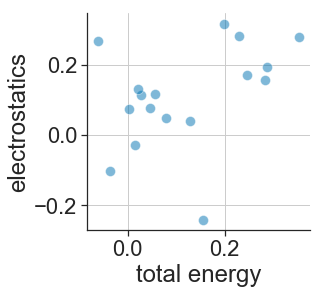

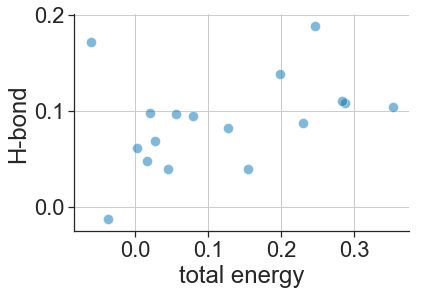

In [28]:
data = (
    egaps_df[egaps_df['e_function'] == 'beta16_cart']
    .pivot_table(index='orig_design_name', columns='score_term', values='e_gap')
)
plt.figure(figsize=[4,4])
for term in ['electrostatics', 'H-bond']:
    sns.scatterplot(x='total energy', y=term, data=data, s=100, alpha=0.5)
    plt.grid()
    sns.despine()
    plt.show()

Compare egaps between energy functions

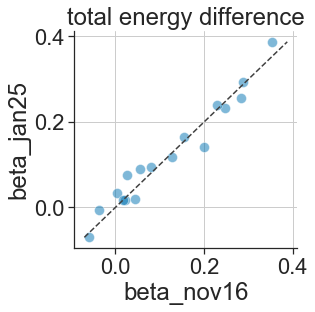

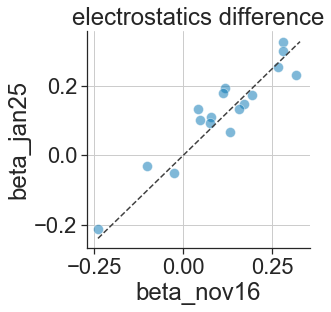

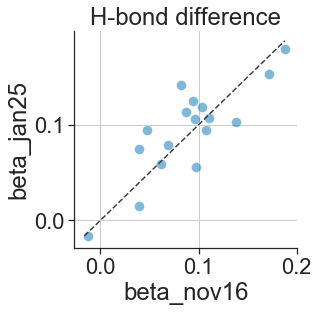

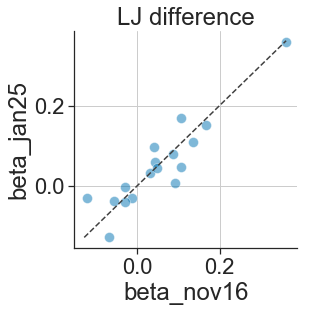

In [31]:
for score_term in ['total energy', 'electrostatics', 'H-bond', 'LJ']:
    data = (
        egaps_df[egaps_df['score_term'] == score_term]
        .pivot_table(index='orig_design_name', columns='e_function', values='e_gap')
    )
    min_val = data.min().min()
    max_val = data.max().max()
    plt.figure(figsize=[4,4])
    sns.scatterplot(x='beta16_cart', y='beta16_cart_plus_hpsc_lj_changes', data=data, s=100, alpha=0.5)
    plt.plot([min_val, max_val], [min_val, max_val], ls='--', c='0.25')
    plt.title(f'{score_term} difference')
    plt.xlabel('beta_nov16')
    plt.ylabel('beta_jan25')
    plt.grid()
    #plt.gca().set_aspect('equal')
    sns.despine()
    plt.show()

Compute mean RMS among relaxed design models

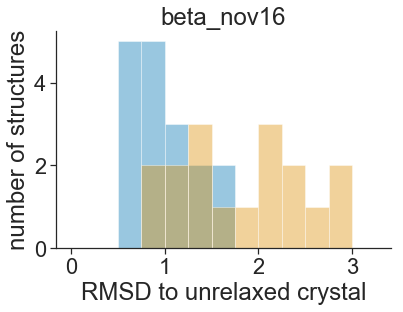

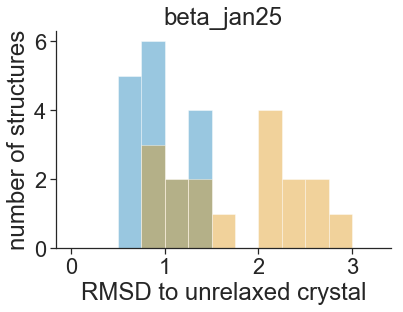

In [30]:
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
for e_function in e_functions:
    data = (
        scores_df[
            (scores_df['rep_score_rank'] == 1) &
            (scores_df['e_function'] == e_function)
        ]
        # .groupby('orig_design_name', as_index=False)['rms'].mean()
    )
    # for (e_function, data) in mean_rms_df.groupby('e_function'):
    #     print(design_or_xtal, e_function, data['rms'].mean())
    #     sns.distplot(data['rms'], kde=False, bins=10, color='k')
    #     plt.xlim([0, data['rms'].max()+0.2])
    #     plt.ylabel('# of design models')
    #     plt.xlabel(r'RMS to crystal structure ($\AA$)')
    #     plt.grid()
    #     sns.despine()
    #     plt.show()
    bins=np.arange(0, 3.5, 0.25)
    sns.distplot(
        data[data['design_or_xtal'] == 'xtal']['rms'], kde=False, bins=bins
    )
    sns.distplot(
        data[data['design_or_xtal'] == 'design']['rms'], kde=False, bins=bins
    )
    plt.ylabel('number of structures')
    plt.xlabel('RMSD to unrelaxed crystal')
    plt.title(title_dict[e_function])
    sns.despine()
    plt.show()

Compute mean egaps

In [31]:
mean_egaps_df = egaps_df.groupby(['e_function', 'score_term'], as_index=False)['e_gap'].mean()

Plot the mean energy gap for different groups of terms

beta16_cart


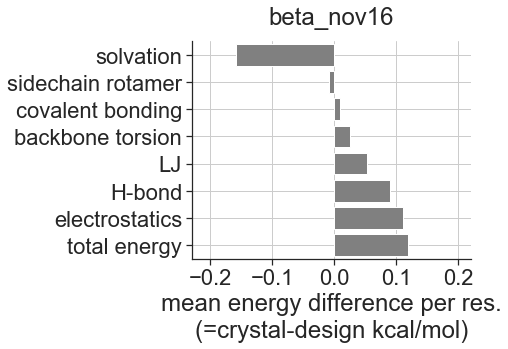

beta16_cart_plus_hpsc_lj_changes


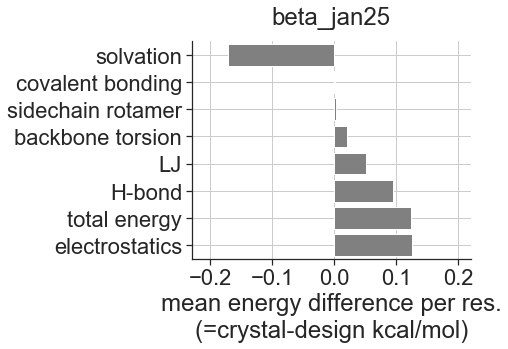

In [32]:
score_terms_to_plot = [
    'total energy',
    'electrostatics',
    'H-bond',
    'LJ',
    'solvation',
    'sidechain rotamer',
    'backbone torsion',
    'covalent bonding'
]
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
for e_function in e_functions:
    
    print(e_function)
    
    # Get data
    data = mean_egaps_df[
        (mean_egaps_df['e_function'] == e_function) &
        (mean_egaps_df['score_term'].isin(score_terms_to_plot))
    ].copy()
    data.sort_values('e_gap', inplace=True)

    # Plot data
    plt.figure(figsize=[5,4])
    sns.barplot(y='score_term', x='e_gap', data=data, color='0.5')
    plt.ylabel('')
    plt.xticks([-0.2, -0.1, 0, 0.1, 0.2])
    plt.xlim([-0.23, 0.22])
    plt.xlabel('mean energy difference per res.\n(=crystal-design kcal/mol)')
    plt.title(title_dict[e_function], y=1.05)
    plt.grid()
    sns.despine()
    plt.show()

Plot individual energy landscapes

beta16_cart 5L6HC3_1


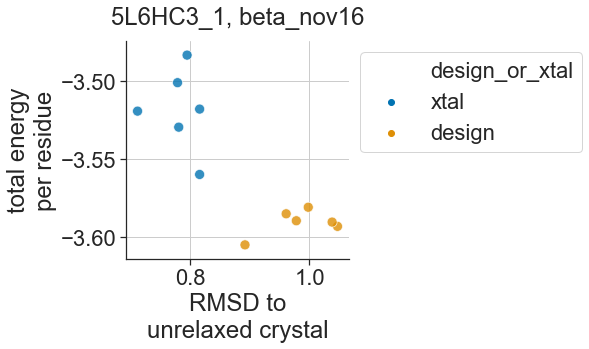

beta16_cart 6AYYA


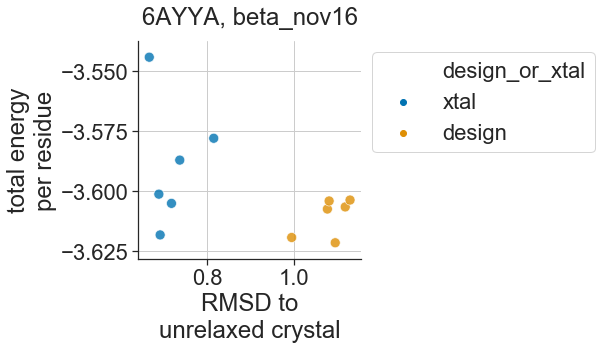

beta16_cart BB1


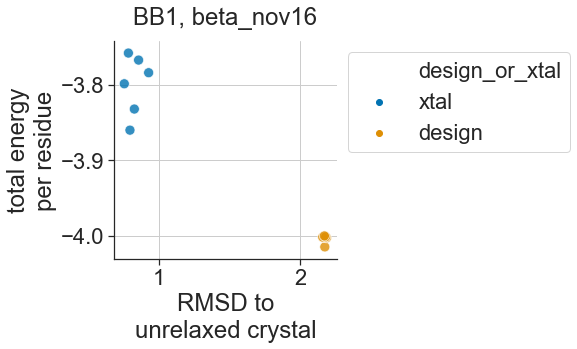

beta16_cart BBM2nHm0589


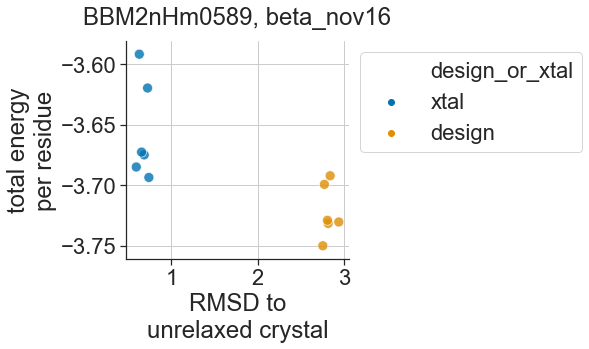

beta16_cart CAV1


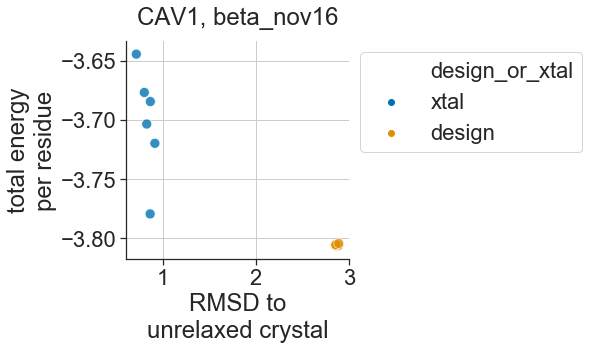

beta16_cart DHD127


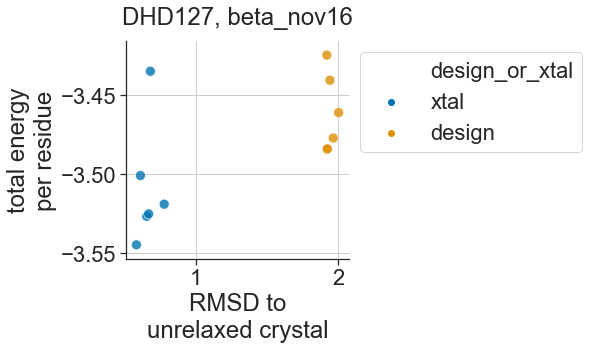

beta16_cart DHD131


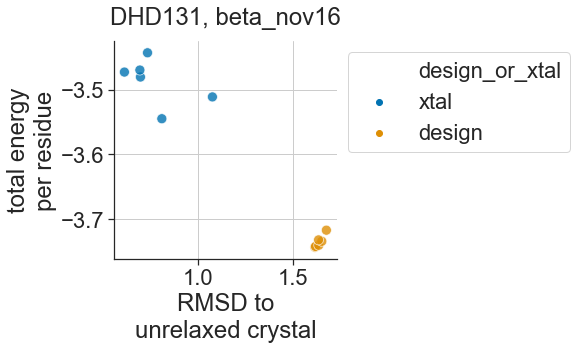

beta16_cart DHR4


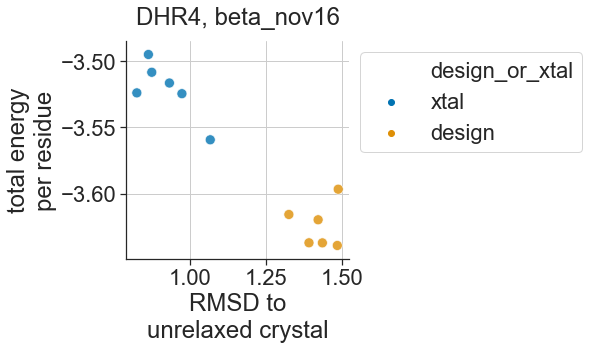

beta16_cart DHR76


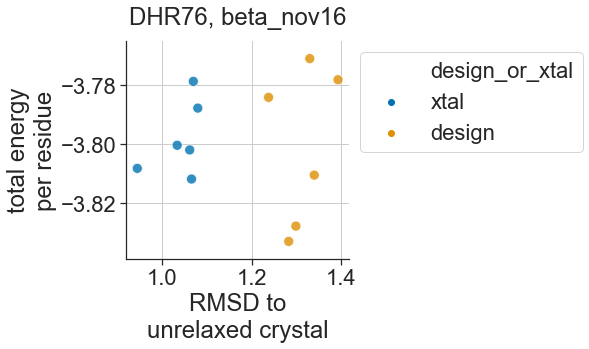

beta16_cart D_3_212


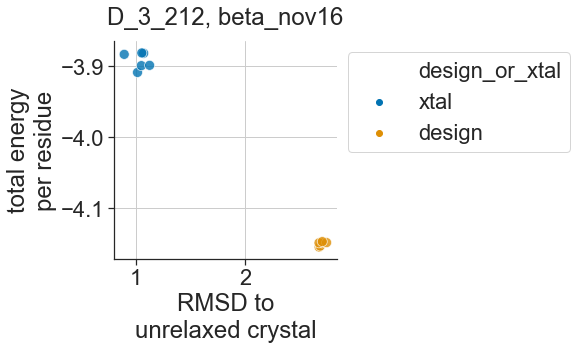

beta16_cart D_3_633


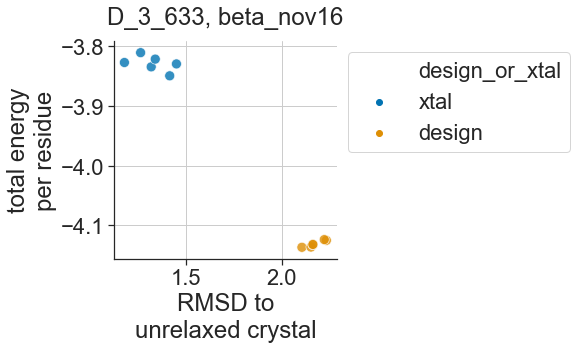

beta16_cart LHD29


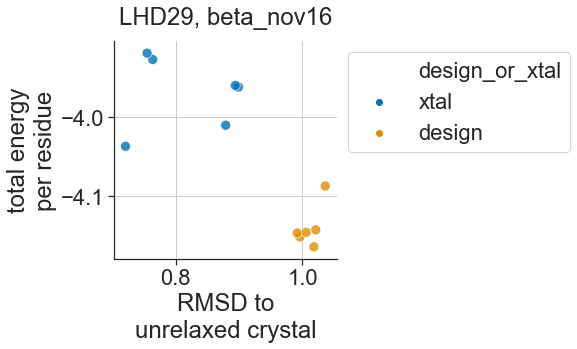

beta16_cart MC2_7


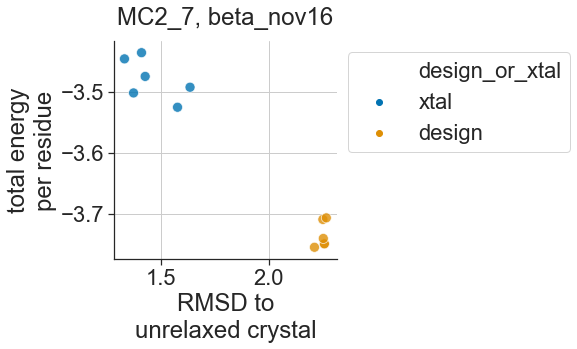

beta16_cart RPB_PLP3_R6–PLPx6


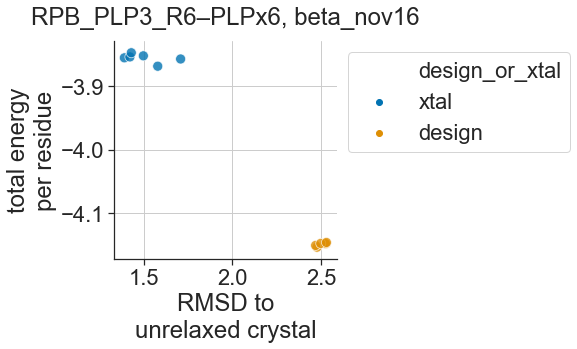

beta16_cart THR1


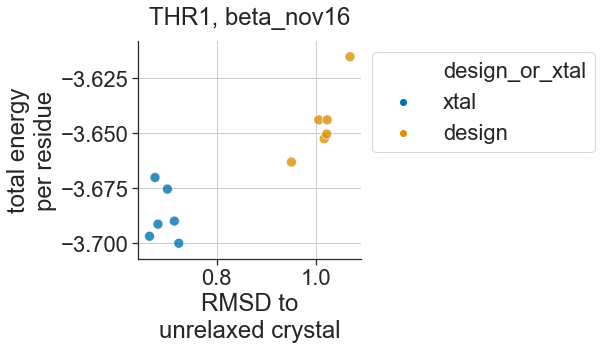

beta16_cart THR2


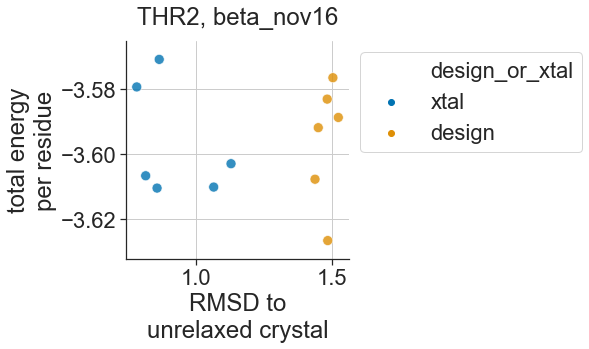

beta16_cart WSHC6


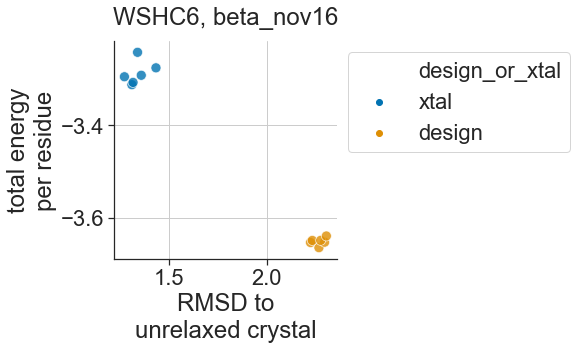

beta16_cart_plus_hpsc_lj_changes 5L6HC3_1


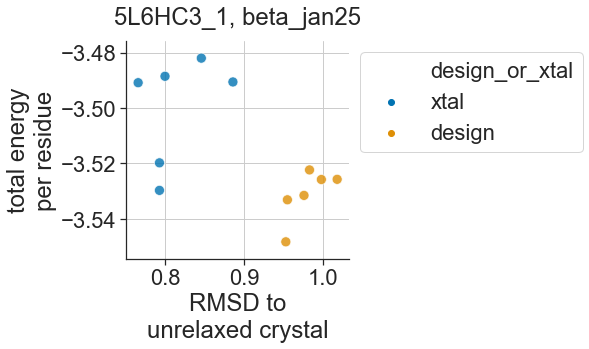

beta16_cart_plus_hpsc_lj_changes 6AYYA


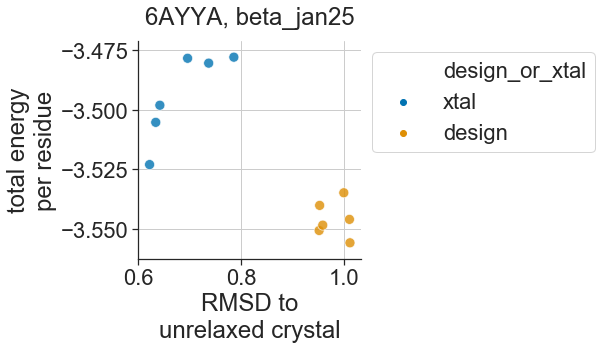

beta16_cart_plus_hpsc_lj_changes BB1


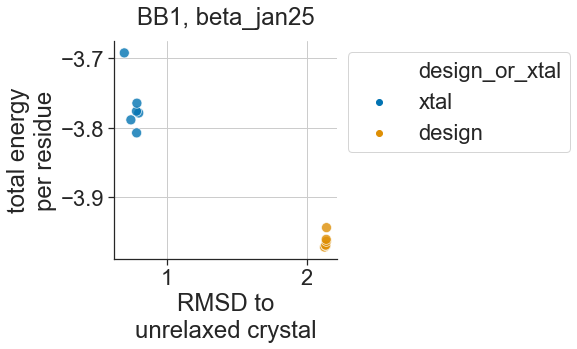

beta16_cart_plus_hpsc_lj_changes BBM2nHm0589


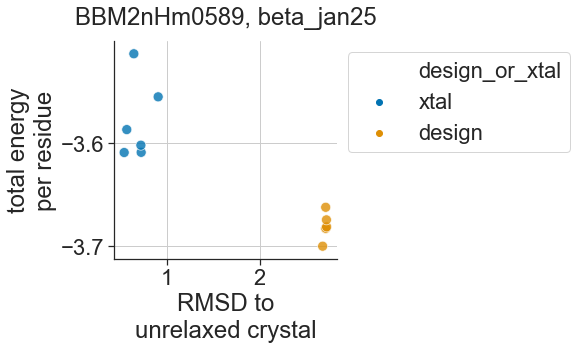

beta16_cart_plus_hpsc_lj_changes CAV1


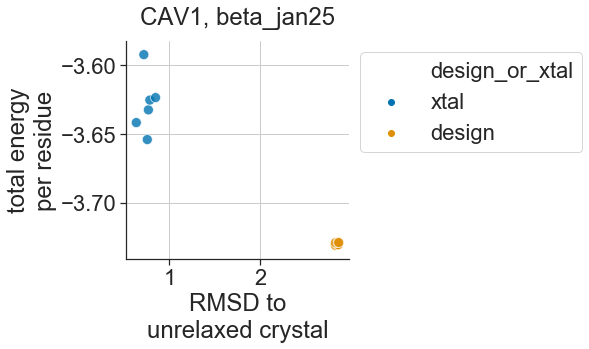

beta16_cart_plus_hpsc_lj_changes DHD127


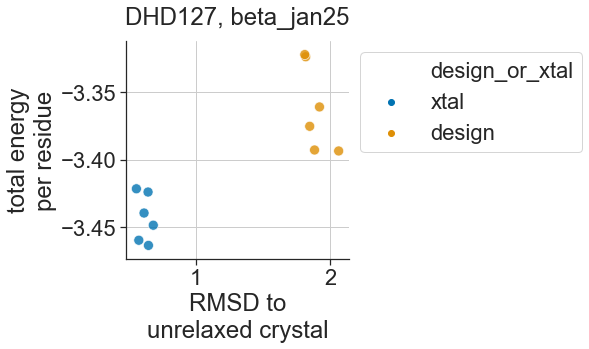

beta16_cart_plus_hpsc_lj_changes DHD131


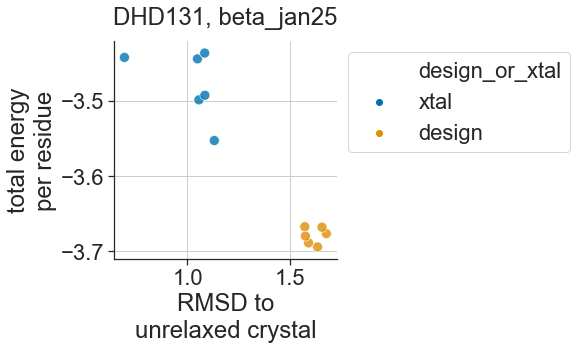

beta16_cart_plus_hpsc_lj_changes DHR4


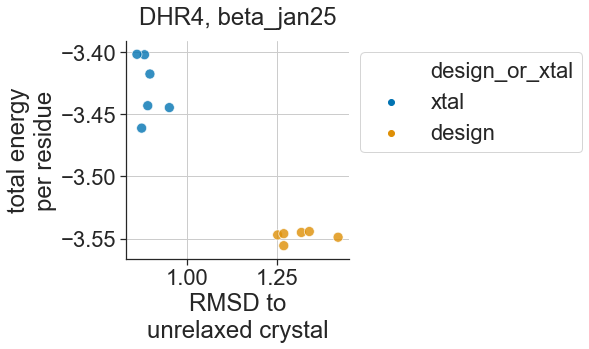

beta16_cart_plus_hpsc_lj_changes DHR76


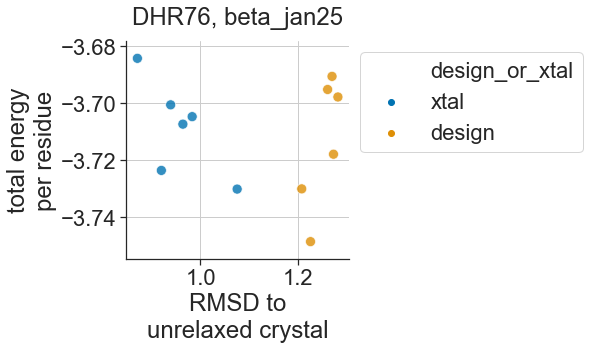

beta16_cart_plus_hpsc_lj_changes D_3_212


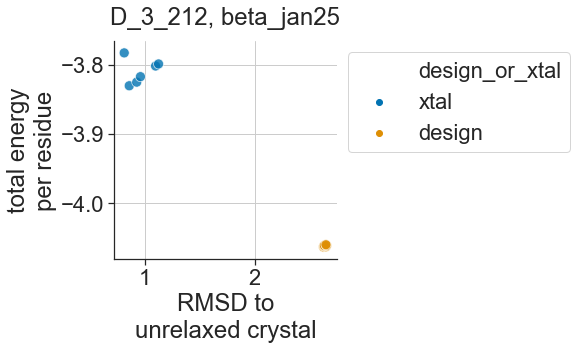

beta16_cart_plus_hpsc_lj_changes D_3_633


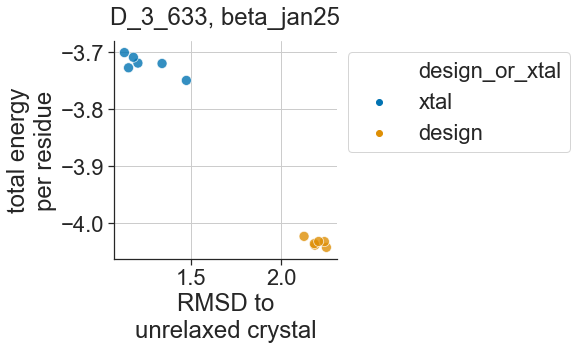

beta16_cart_plus_hpsc_lj_changes LHD29


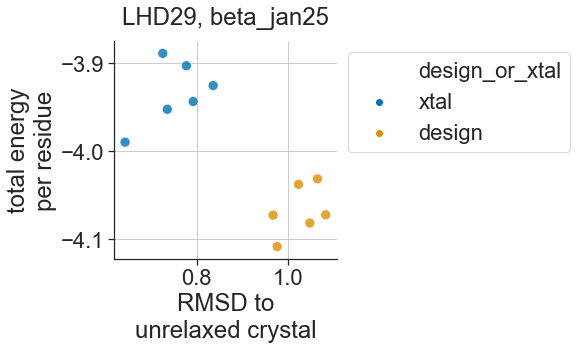

beta16_cart_plus_hpsc_lj_changes MC2_7


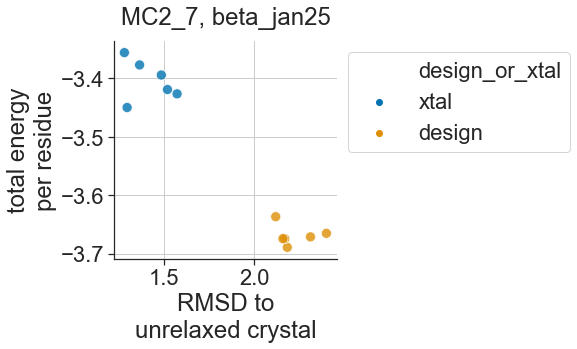

beta16_cart_plus_hpsc_lj_changes RPB_PLP3_R6–PLPx6


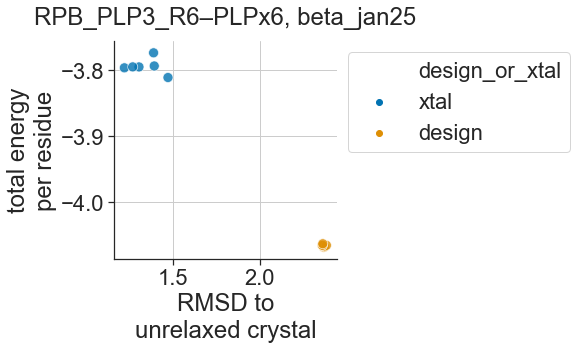

beta16_cart_plus_hpsc_lj_changes THR1


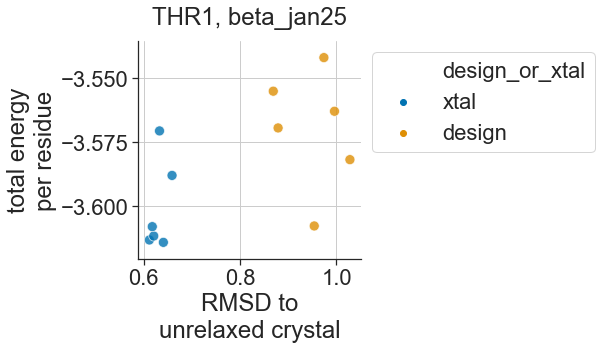

beta16_cart_plus_hpsc_lj_changes THR2


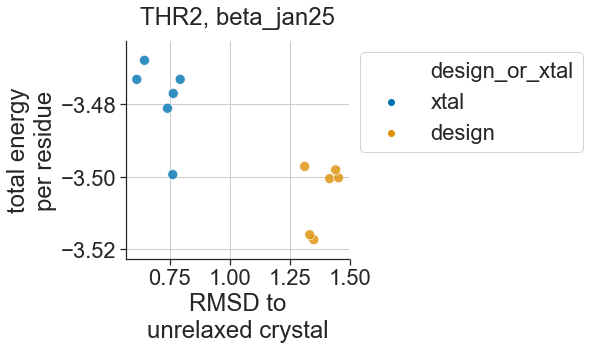

beta16_cart_plus_hpsc_lj_changes WSHC6


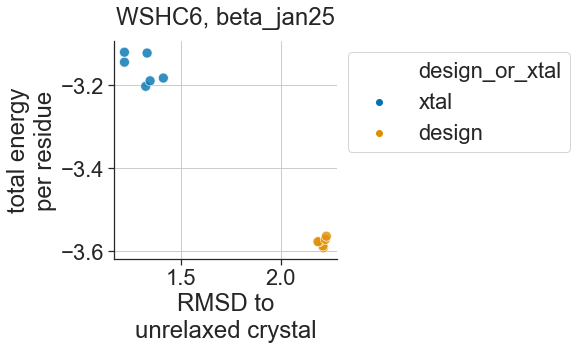

In [35]:
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
designs = sorted(list(scores_df['orig_design_name'].unique()))
output_dir = 'results/energy_landscape_plots/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for e_function in e_functions:
    for design in designs:
        data = scores_df[
            (scores_df['poly_gly'] == False) &
            (scores_df['orig_design_name'] == design) &
            (scores_df['e_function'] == e_function)
        ].copy()
        data['delta_energy_per_res'] = data['total energy'] / data['nres']
        print(e_function, design)
        plt.figure(figsize=[4,4])
        sns.scatterplot(
            x='rms', y='delta_energy_per_res', data=data,
            hue='design_or_xtal', hue_order=['xtal', 'design'],
            s=100, alpha=0.8
        )
        plt.legend(bbox_to_anchor=(1,1))
        plt.ylabel('total energy\nper residue')
        plt.xlabel('RMSD to\nunrelaxed crystal')
        plt.title(f'{design}, {title_dict[e_function]}', y=1.05)
        plt.grid()
        sns.despine()
        
        output_f = os.path.join(output_dir, f'{design}_{title_dict[e_function]}.png')
        plt.savefig(output_f, dpi=300, bbox_inches='tight')
        
        plt.show()

Examine scores for a single design

In [51]:
pdb_str = 'DHD127' # 'BBM2nHm0589' # 'derroids_3_212' # 'DHD_131' # 'BB1' # 'CAV1' # 
e_functions_to_show = [
    'beta16.nostab-refit',
    
    'beta_jan22',
    # 'HH_run26B_step129_1e',
    # 'HH_run26B_step129_1e3_14',
    
    'HH_run19A_step266',
    #'HH_run19A_step266_dd2_elec_5_no_scale',
    #'HH_run19A_step266_dd2_elec_4a',
    #'HH_run19A_step266_dd2_elec_5a',
    #'HH_run19A_step266_dd2_elec_5a2',
    #'HH_run19A_step266_dd2_elec_5a14',
    
    # 'HH_run23A_step384',
    #'HH_run23B_sol_elec_dd2_simple_step169',
    # 'HH_run23B_sol_elec_dd2_simple_step169_5a2',
    # 'HH_run23B_sol_elec_dd2_simple_step169_5a3',
    # 'HH_run23B_sol_elec_dd2_simple_step169_5a4',
]
egaps_df[
    (egaps_df['design_name'] == pdb_str) &
    (egaps_df['e_function'].isin(e_functions_to_show)) &
    (egaps_df['score_term'] == 'ref')
]

Empty DataFrame
Columns: [score_term, design, xtal, e_gap, design_name, e_function]
Index: []

* pushing things apart?
* per-residue energies? residue pairs?
* per-atom?
* core or surface?
* some kind of repulsive force that is now stronger?

Compute the mean energy gap for each score term

In [118]:
mean_egaps_dict = {
    key : []
    for key in ['e_function', 'score_term', 'mean']
}
for e_function in e_functions:
    for score_term in score_terms:
        data = egaps_df[
            (egaps_df['score_term'] == score_term) &
            (egaps_df['e_function'] == e_function)
        ].copy()
        mean_egaps_dict['e_function'].append(e_function)
        mean_egaps_dict['score_term'].append(score_term)
        mean_egaps_dict['mean'].append(data['e_gap'].mean())
        
mean_egaps_df = pandas.DataFrame(mean_egaps_dict)
mean_egaps_df.head()

e_function     score_term      mean
0  beta16.nostab-refit          score  0.065299
1  beta16.nostab-refit  fa_elec_total  0.093981
2  beta16.nostab-refit       hbond_sc  0.060122
3  beta16.nostab-refit    hbond_bb_sc  0.000779
4  beta16.nostab-refit    hbond_lr_bb  0.005104

Next, make a scatter plot that compares individual energy gaps between two energy functions

beta16.nostab-refit 0.065 0.056
beta_jan22 0.059 0.037
total energy


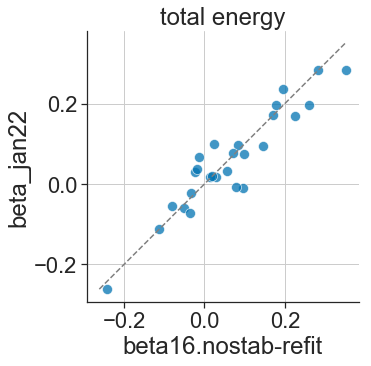

In [119]:
e_functions_to_compare = [
    'beta16.nostab-refit',
    'beta_jan22',
    #'HH_run19A_step266',
    #'HH_run23A_step384',
    #'HH_run23A_step384_cf_1b',
    #'HH_run19A_step266_dd2_elec_5a2',
    #'HH_run19A_step266_dd2_elec_5a14',
    #'HH_run23A_step384',
    #'HH_run23B_sol_elec_dd2_simple_step169_5a3',
    # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
score_term = 'total energy' # 'fa_elec_total' # 'lj' # 
data = egaps_df[
    (egaps_df['e_function'].isin(e_functions_to_compare)) &
    (egaps_df['score_term'] == score_term)
].copy()
min_val = data['e_gap'].min()
max_val = data['e_gap'].max()
data = data.pivot(index='design_name', columns='e_function', values='e_gap')
data['diff'] = data[e_functions_to_compare[1]] - data[e_functions_to_compare[0]]

for i in [0, 1]:
    print(
        e_functions_to_compare[i],
        round(data[e_functions_to_compare[i]].mean(), 3),
        round(data[e_functions_to_compare[i]].median(), 3)
    )

# Plot data
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
sns.scatterplot(
    x=e_functions_to_compare[0], y=e_functions_to_compare[1],
    data=data, s=100, alpha=0.75
)
plt.plot([min_val,max_val], [min_val,max_val], ls='--', c='0.5')
print(score_term)
tick_width = 0.2 # 50
#ticks = np.arange(min_val-tick_width, 0, tick_width)
#ticks += np.arange(0, max_val+tick_width, tick_width)
#plt.xticks(ticks)
#plt.yticks(ticks)
plt.xlabel(
    e_functions_to_compare[0].replace('HH_run19A_step266', '19A')
)
plt.ylabel(
    e_functions_to_compare[1].replace(
        'HH_run19A_step266',
        '19A'
    ).replace(
        'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
        '23B_cfnp_5a3_14'
    )
)
ax.set_aspect('equal', adjustable='box')
plt.title(score_term)
plt.grid()
sns.despine()
plt.show()

In [120]:
data.sort_values('beta16.nostab-refit', ascending=True)#.head(n=10)

e_function          beta16.nostab-refit  beta_jan22      diff
design_name                                                  
Sh29                          -0.242784   -0.261601 -0.018817
IL7_binder                    -0.112470   -0.111033  0.001438
amcl1                         -0.081798   -0.054618  0.027181
DHD127                        -0.051278   -0.059526 -0.008248
DHR14                         -0.035143   -0.072656 -0.037513
8_NSR                         -0.033118   -0.023095  0.010023
LCB3_RBD_binder               -0.023957    0.029776  0.053734
TrkA_binder                   -0.019335    0.037204  0.056540
T6                            -0.014497    0.066493  0.080990
DHR76                          0.013418    0.017640  0.004222
LCB1_RBD_binder                0.018193    0.019099  0.000906
6AYYA                          0.023948    0.099832  0.075883
5L6HC3_1                       0.029847    0.018442 -0.011405
HFuse_pH192_3_0046             0.055753    0.031733 -0.024020
derroids_3_633                 0.070398    0.076792  0.006395
CAV1                           0.078234   -0.007822 -0.086056
BBM2nHm0589                    0.082933    0.097176  0.014242
5H2LD_10                       0.095274   -0.010900 -0.106174
DHR4                           0.098983    0.075196 -0.023787
DHR8                           0.144923    0.095548 -0.049375
DHD_131                        0.171671    0.172571  0.000900
LHD29                          0.178271    0.196974  0.018703
BB1                            0.195780    0.236566  0.040786
derroids_3_212                 0.224130    0.168231 -0.055900
MC2_7                          0.260954    0.196849 -0.064104
R6PEP12                        0.283542    0.284184  0.000643
WSHC6                          0.351205    0.282860 -0.068345

Plot gaps for a specific energy function and design

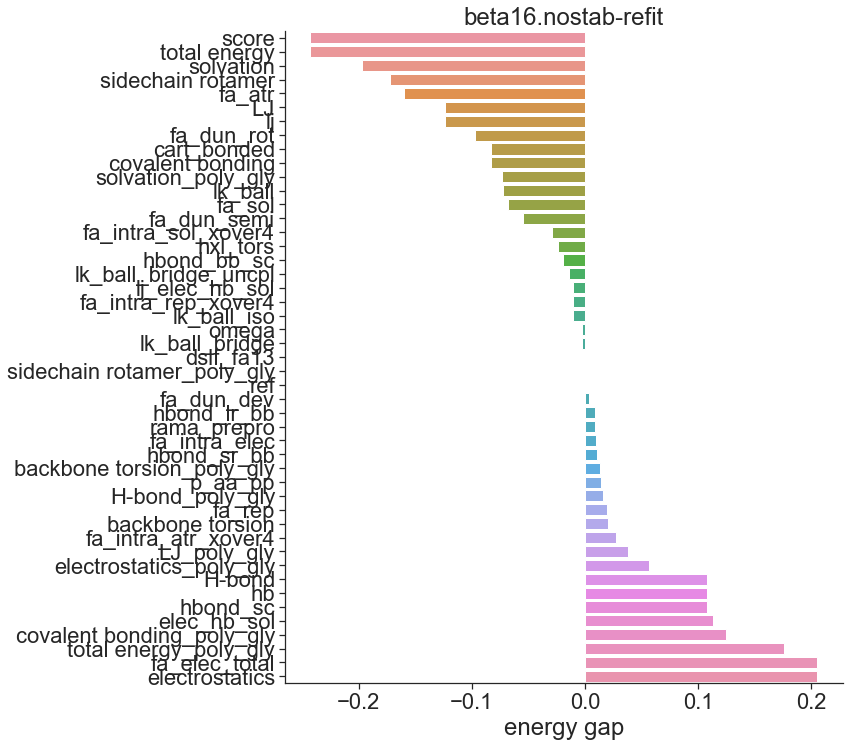

In [121]:
e_function = 'beta16.nostab-refit'
design_name = 'Sh29'
data = egaps_df[
    (egaps_df['e_function'] == e_function) &
    (egaps_df['design_name'] == design_name)
].copy()
data.sort_values('e_gap', inplace=True)
plt.figure(figsize=[10,12])
sns.barplot(y='score_term', x='e_gap', data=data)
plt.xlabel('energy gap')
plt.ylabel('')
plt.title(e_function)
sns.despine()
plt.show()

For each energy function, plot average score gaps for each term

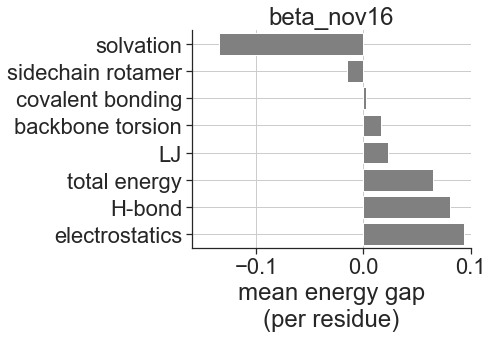

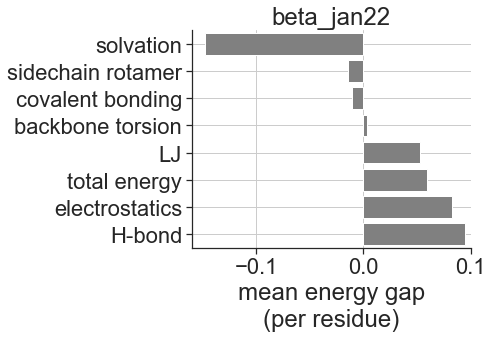

In [144]:
score_terms_to_plot = [
    'score',
    'fa_elec_total',
    'hbond_sc', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sr_bb',
    'fa_atr', 'fa_rep',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4', #'fa_intra_elec',
    'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'cart_bonded',
    'ref', 'dslf_fa13',
    
    'hb',
    'lj',
    'elec_hb_sol', 'lj_elec_hb_sol',    
]
score_terms_to_plot = [
    'total energy',
    'electrostatics',
    'H-bond',
    'LJ',
    'solvation',
    'sidechain rotamer',
    'backbone torsion',
    'covalent bonding'
]
e_functions_to_plot = [
    'beta16.nostab-refit',
    'beta_jan22',
#     'HH_run19A_step266',
#     'HH_run19A_step266_dd2_elec_5a2',
#     'HH_run19A_step266_dd2_elec_5a14',
    
#     'HH_run23A_step384',
#     'HH_run23B_sol_elec_dd2_simple_step169',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a2',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a3',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a4',
]
for e_function in e_functions_to_plot:
    
    # Get data
    data = mean_egaps_df[
        (mean_egaps_df['e_function'] == e_function) &
        (mean_egaps_df['score_term'].isin(score_terms_to_plot))
    ].copy()
    data.sort_values('mean', inplace=True)

    # Plot data
    plt.figure(figsize=[5,4])
    sns.barplot(y='score_term', x='mean', data=data, color='0.5')
    plt.ylabel('')
    plt.xlim([-0.16, 0.1])
    plt.xlabel('mean energy gap\n(per residue)')
    plt.title(e_function.replace('beta16.nostab-refit', 'beta_nov16'))
    plt.grid()
    sns.despine()
    plt.show()

For a given score term, plot score gaps across energy functions

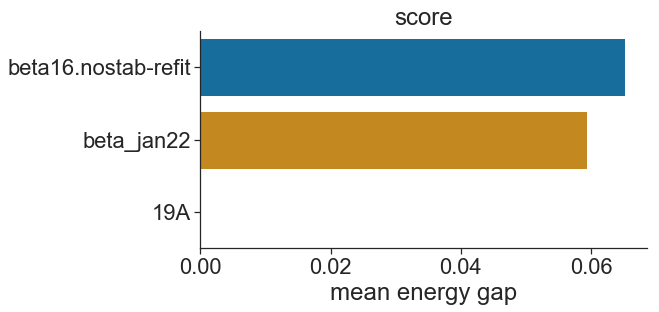

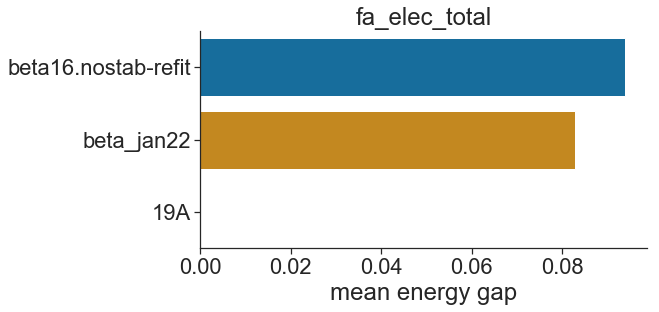

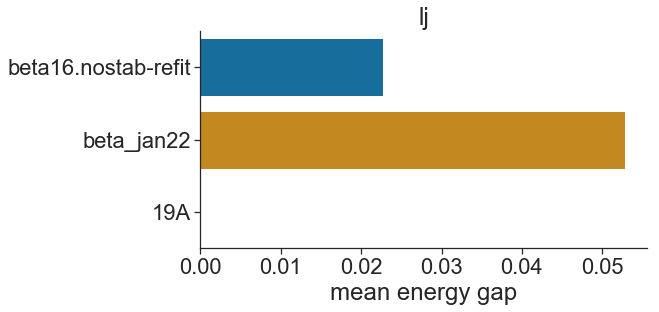

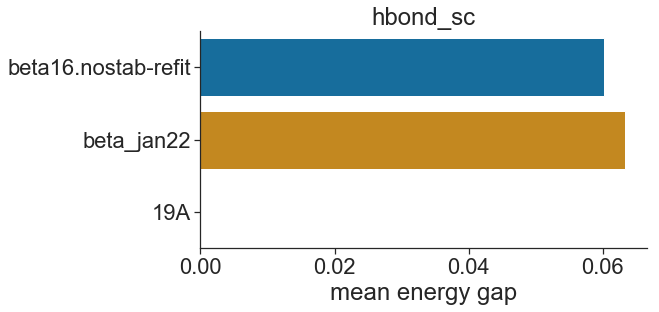

In [17]:
e_functions_to_compare = [
    'beta16.nostab-refit',
    'HH_run19A_step266',
    #'HH_run19A_step266_dd2_elec_5a',
#     'HH_run19A_step266_dd2_elec_5a2',
#     'HH_run19A_step266_dd2_elec_5a3',
#     'HH_run19A_step266_dd2_elec_5a4',
#     'HH_run19A_step266_dd2_elec_5a5',
#     'HH_run19A_step266_dd2_elec_5a6',
#     'HH_run19A_step266_dd2_elec_5a7',
#     'HH_run19A_step266_dd2_elec_5a8',
#     'HH_run19A_step266_dd2_elec_5a9',
#     'HH_run19A_step266_dd2_elec_5a10',
#     'HH_run19A_step266_dd2_elec_5a11',
#     'HH_run19A_step266_dd2_elec_5a12',
#     'HH_run19A_step266_dd2_elec_5a13',
#     'HH_run19A_step266_dd2_elec_5a14',
    
    # 'HH_run23A_step384',
    # 'HH_run23A_step384_cfnp',
#     'HH_run23A_step384_cf_1b',
    # 'HH_run23B_sol_elec_dd2_simple_step169',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a2',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a3',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a4',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a14',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a3_14',
#     'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2',
#     'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3',
#     'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14',
    # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
    
    'beta_jan22',
    # 'HH_run26B_step129_1e',
    # 'HH_run26B_step129_1e3_14',
    
]
score_terms = ['score', 'fa_elec_total', 'lj', 'hbond_sc']
for score_term in score_terms:
    data = mean_egaps_df[
        (mean_egaps_df['e_function'].isin(e_functions_to_compare)) &
        (mean_egaps_df['score_term'] == score_term)
    ].copy()
    data['e_function'] = data['e_function'].apply(
        lambda x: x.replace(
            'HH_run19A_step266', '19A'
        ).replace(
            'HH_run23A_step384', '23A'
        ).replace(
            'HH_run23B_sol_elec_dd2_simple_step169', '23B'
        )
    )

    # Plot data
    plt.figure(figsize=[8,4])
    sns.barplot(y='e_function', x='mean', data=data)
    plt.title(score_term)
    plt.ylabel('')
    plt.xlabel('mean energy gap')
    sns.despine()
    plt.show()

overriding x and y labels
overriding x and y labels


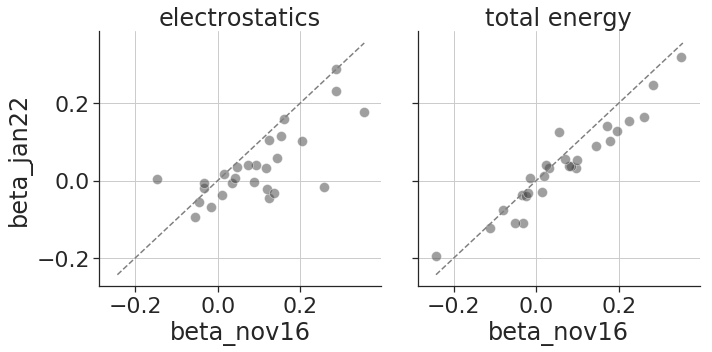

In [32]:
e_functions_to_compare = [
    'beta16.nostab-refit',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
score_terms = [
    'electrostatics', 'total energy'
    #'fa_elec_total', 'lj'#'lj_elec_hb_sol', # 
] # 'lj' # 

(fig, axs) = plt.subplots(
    ncols=2, sharex=True, sharey=True,
    figsize=[10,5]
)
data = egaps_df[
    (egaps_df['e_function'].isin(e_functions_to_compare)) &
    (egaps_df['score_term'].isin(score_terms))
].copy()
min_val = data['e_gap'].min()
max_val = data['e_gap'].max()
for (i, score_term) in enumerate(score_terms):
    
    # Get data to plot
    data = egaps_df[
        (egaps_df['e_function'].isin(e_functions_to_compare)) &
        #(egaps_df['design_name'] == 'derroids_3_212') &
        (egaps_df['score_term'] == score_term)
    ].copy()
    data = data.pivot(index='design_name', columns='e_function', values='e_gap')
    data['diff'] = data[e_functions_to_compare[1]] - data[e_functions_to_compare[0]]
    
    # Plot data
    sns.scatterplot(
        x=e_functions_to_compare[0], y=e_functions_to_compare[1],
        data=data, s=100, alpha=0.5, ax=axs[i], color='0.25'
    )
    axs[i].plot([min_val,max_val], [min_val,max_val], ls='--', c='0.5')
    axs[i].set(
        ylabel = e_functions_to_compare[1].replace(
            'HH_run19A_step266',
            '19A'
        ).replace(
            'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
            '23B_cfnp_5a3_14'
        ),
        title=score_term.replace('fa_elec_total', 'electrostatics')
    )
    axs[i].grid()
    print('overriding x and y labels')
    axs[i].set(xlabel='beta_nov16', ylabel='beta_jan22')

plt.tight_layout()
sns.despine()
plt.show()

Plot the change in energy gaps between energy functions

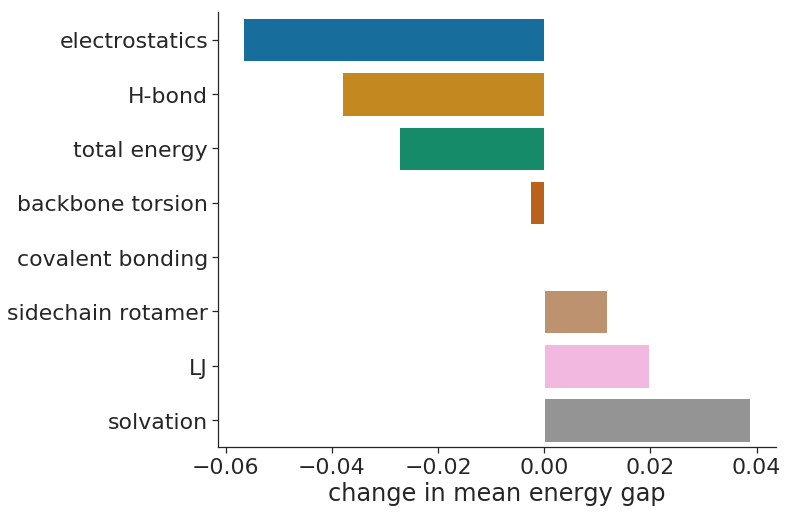

In [60]:
e_functions_to_compare = [
    'beta16.nostab-refit',
    
#     'HH_run23A_step384',
    #'HH_run23A_step384_cf_1b',
#     'HH_run23B_sol_elec_dd2_simple_step169',
    #'HH_run23B_sol_elec_dd2_simple_step169_5a3',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
data = mean_egaps_df[
    (mean_egaps_df['e_function'].isin(e_functions_to_compare)) &
    (mean_egaps_df['score_term'].isin(score_terms_to_plot))
].copy()
data = data.pivot(index='score_term', columns='e_function', values='mean')
data.reset_index(inplace=True)
data['diff'] = data[e_functions_to_compare[1]] - data[e_functions_to_compare[0]]
data.sort_values('diff', ascending=True, inplace=True)

plt.figure(figsize=[10,8])
sns.barplot(y='score_term', x='diff', data=data)
plt.xlabel('change in mean energy gap')
plt.ylabel('')
sns.despine()
plt.show()

In [37]:
data.head()

e_function        score_term  \
4             electrostatics   
0                     H-bond   
7               total energy   
2           backbone torsion   
3           covalent bonding   

e_function  HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14  \
4                                                    0.037218   
0                                                    0.042278   
7                                                    0.037928   
2                                                    0.013350   
3                                                    0.002542   

e_function  beta16.nostab-refit      diff  
4                      0.093981 -0.056763  
0                      0.080319 -0.038041  
7                      0.065299 -0.027371  
2                      0.016018 -0.002667  
3                      0.002718 -0.000176

Plot energy landscapes

HFuse_pH192_3_0046


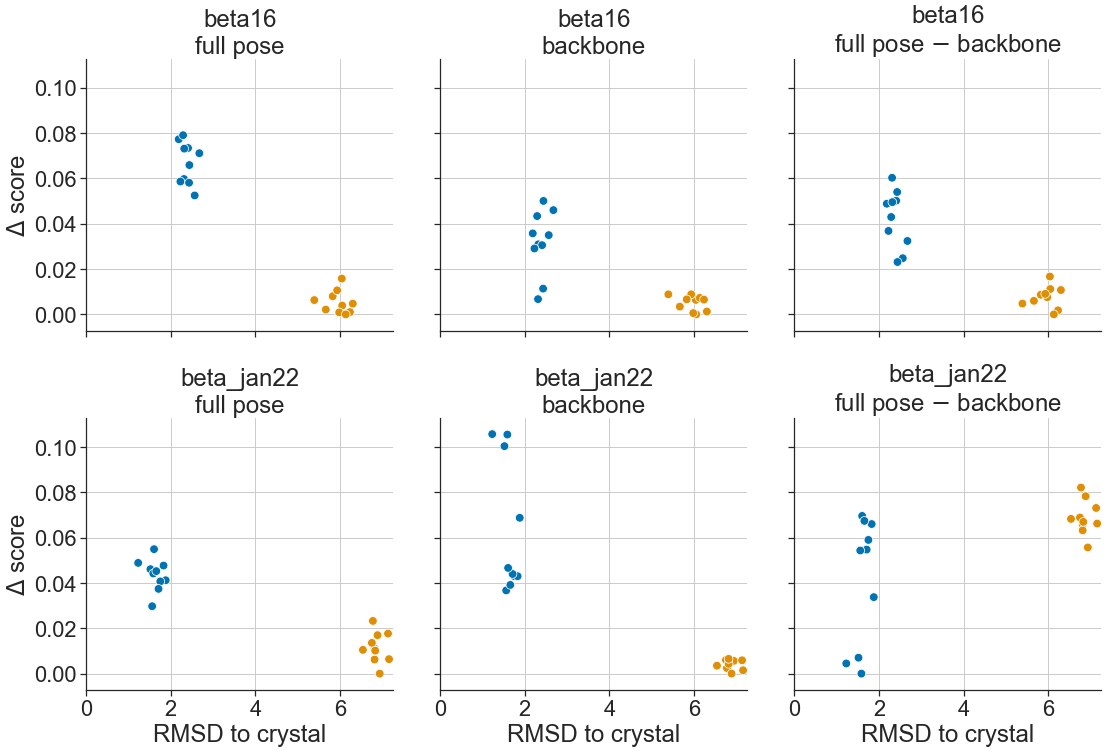

derroids_3_212


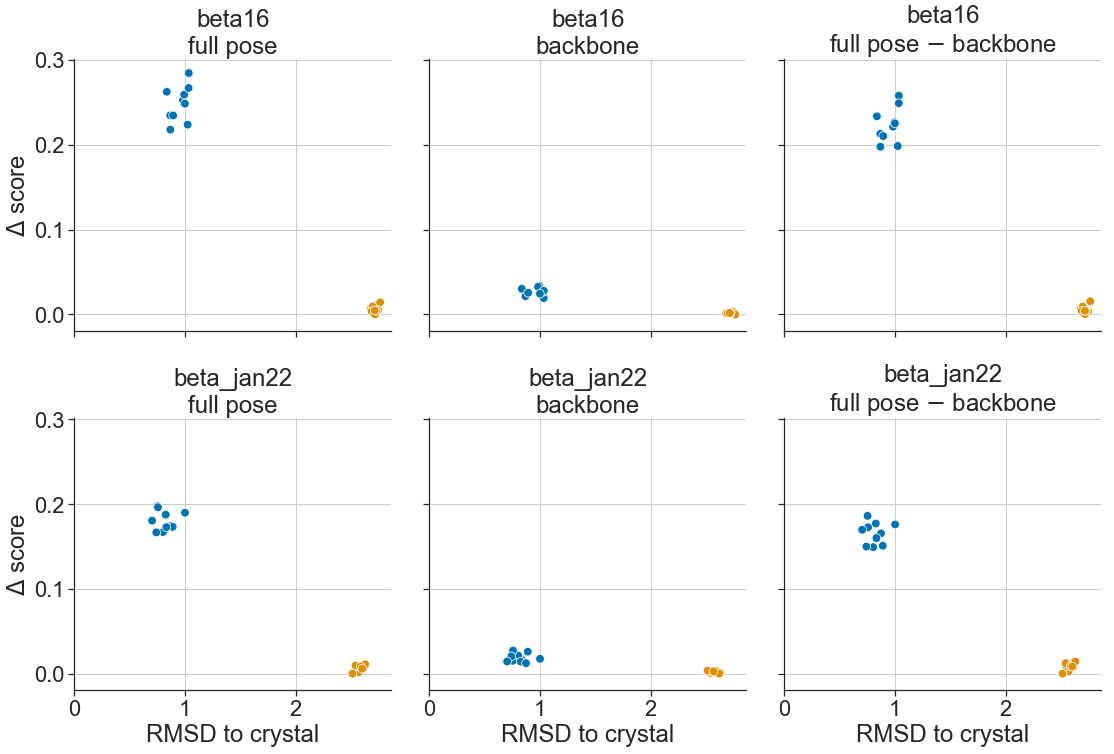

derroids_3_633


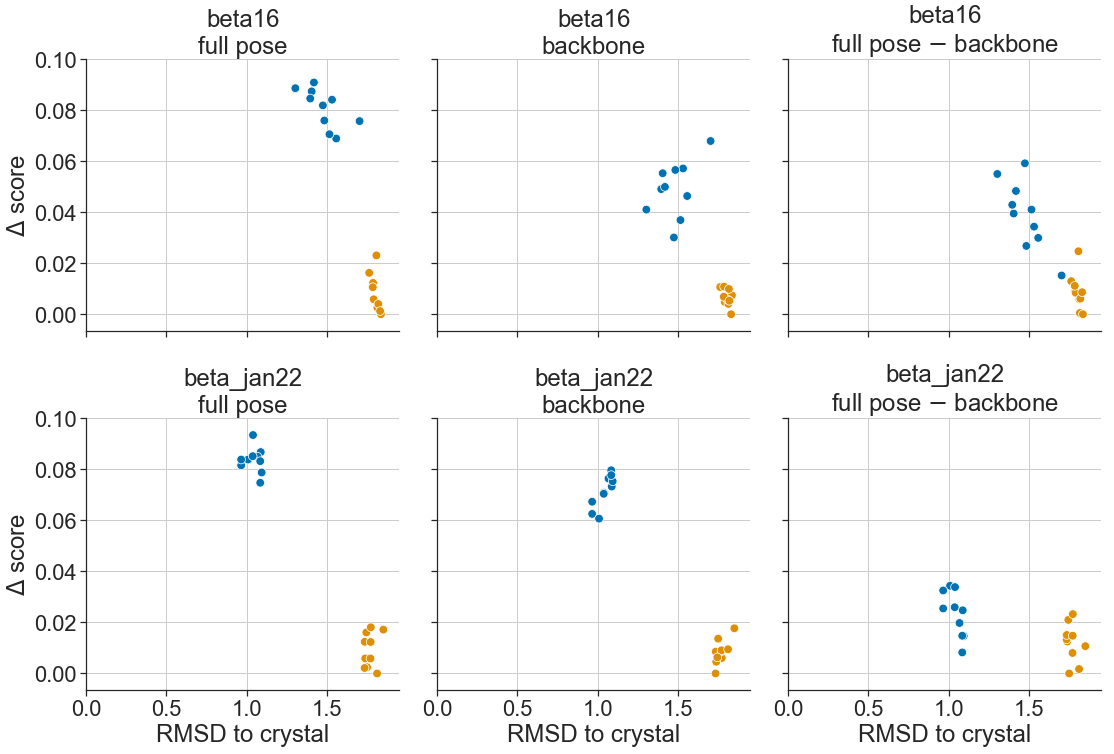

R6PEP12


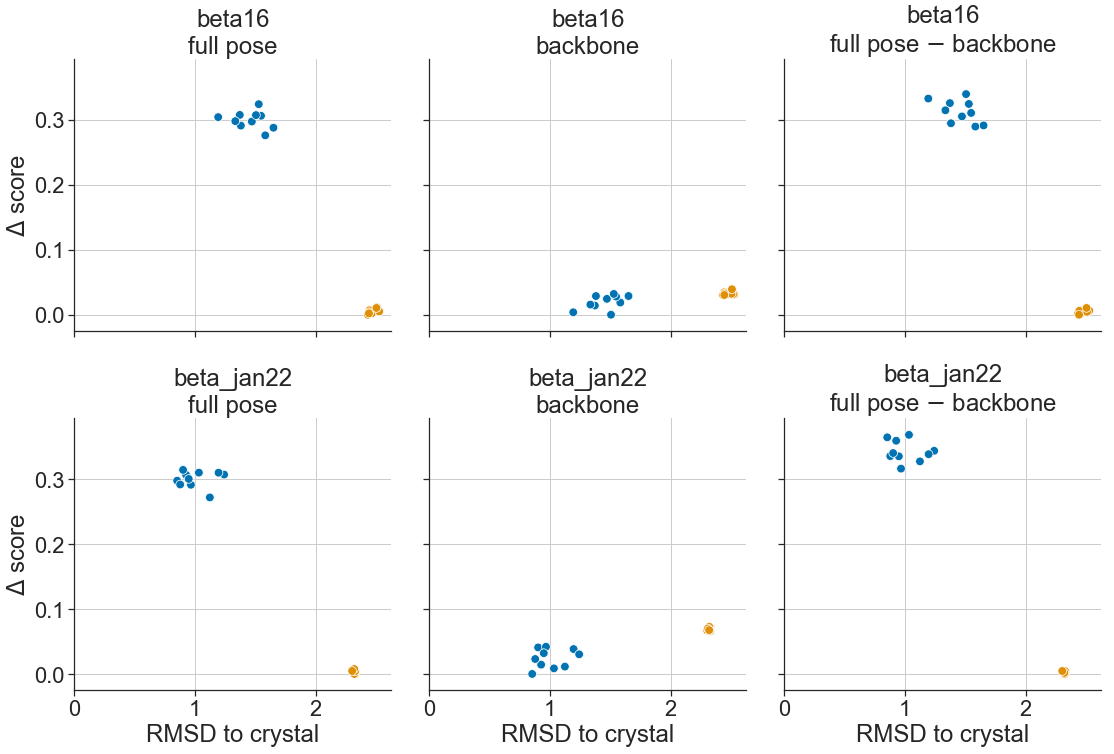

DHD127


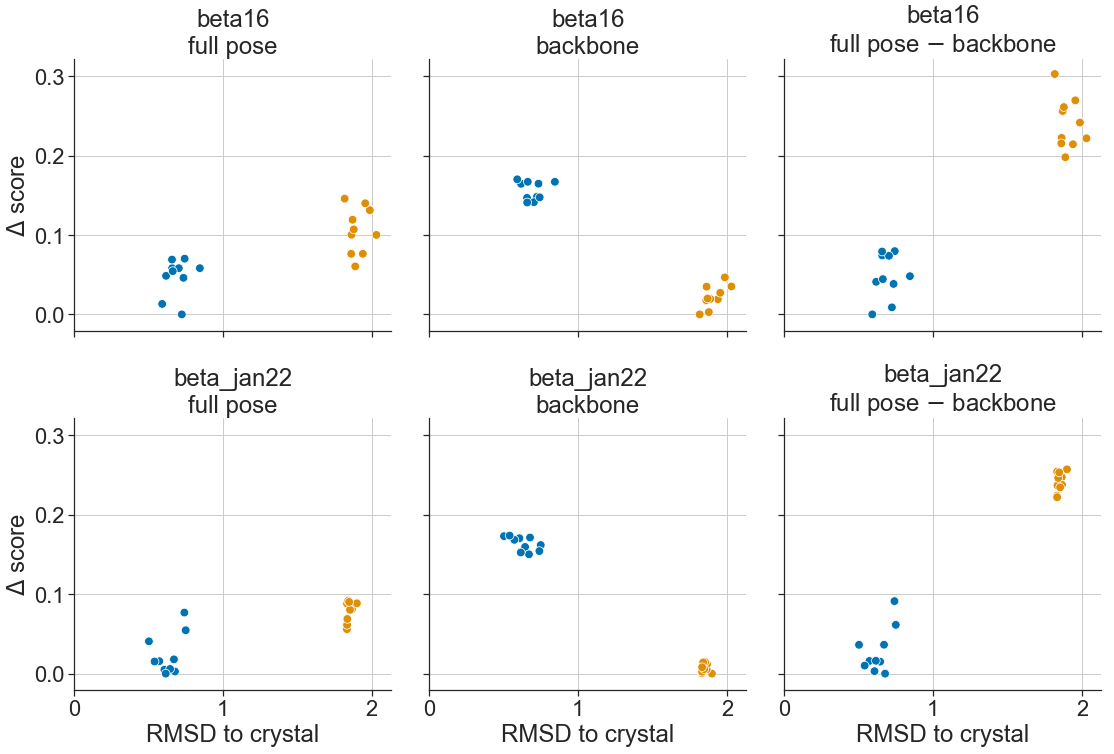

DHD_131


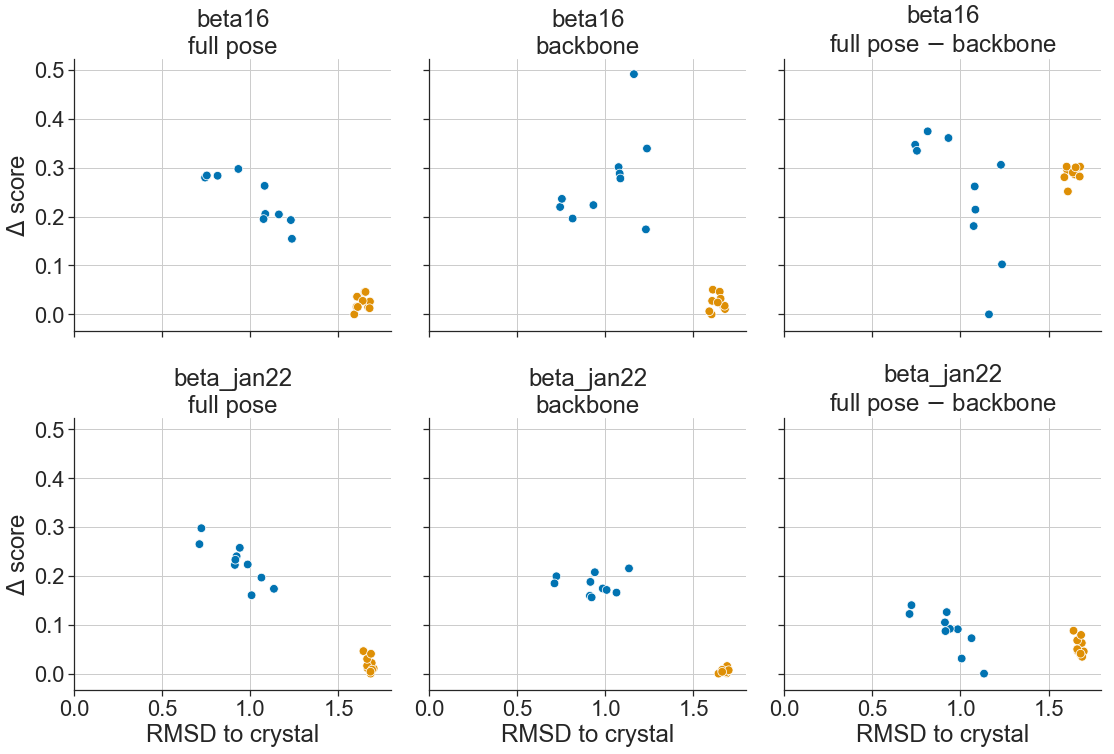

Sh29


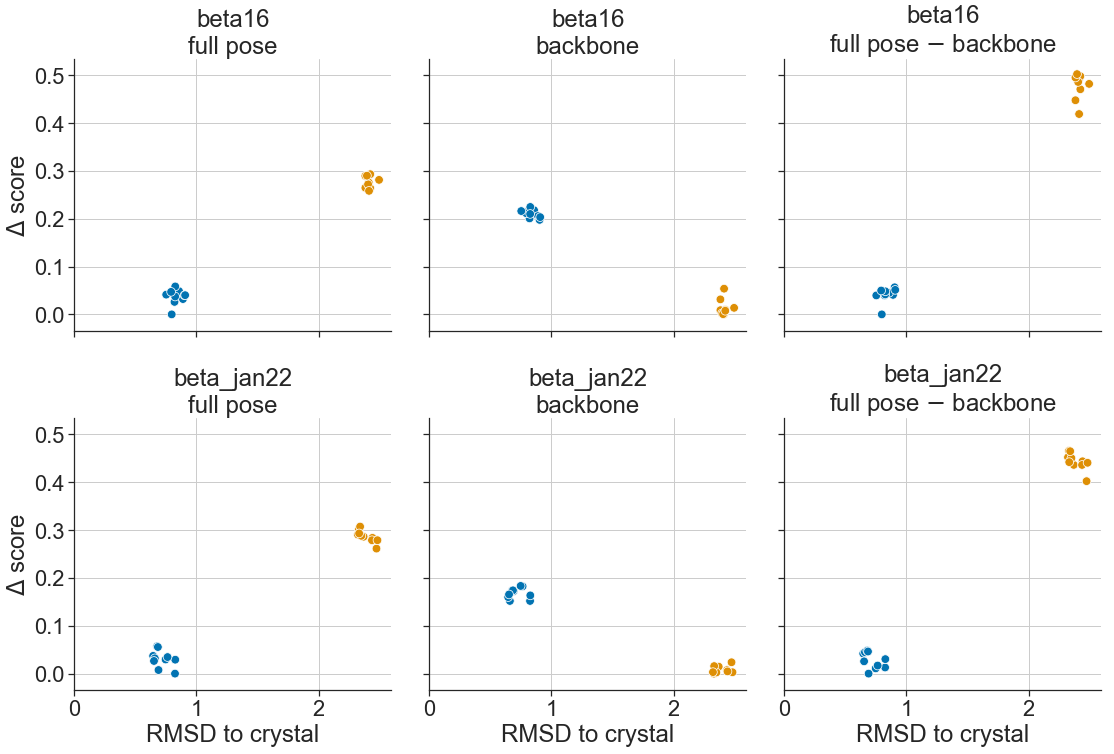

5L6HC3_1


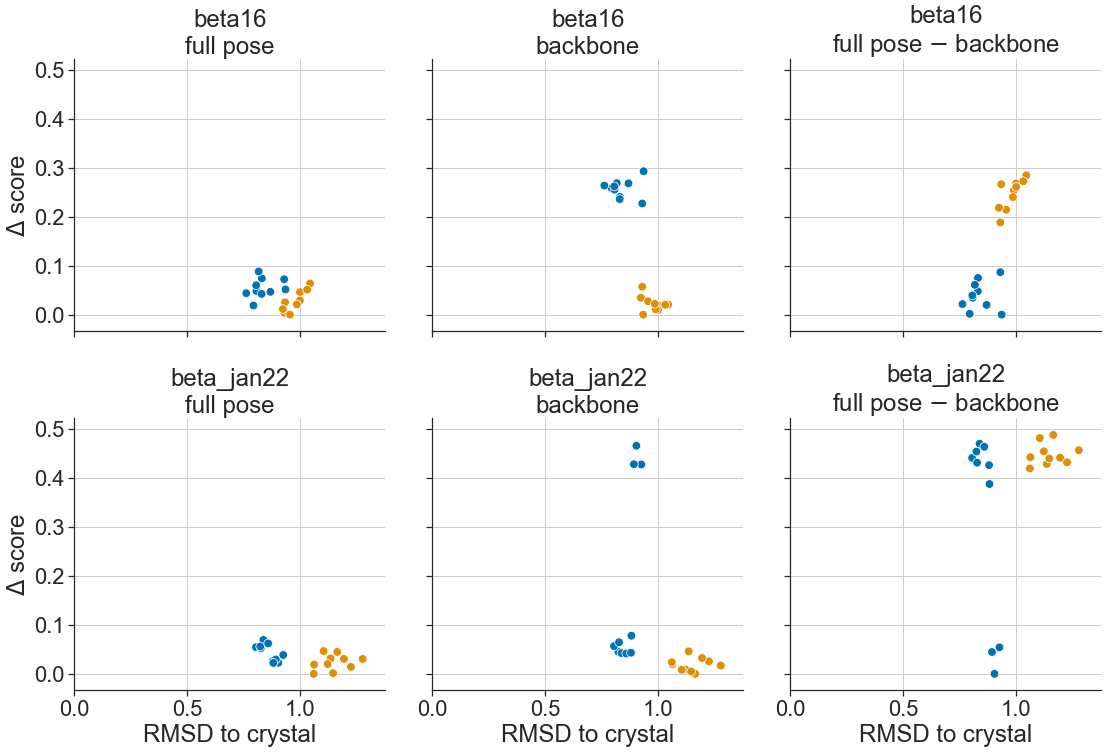

6AYYA


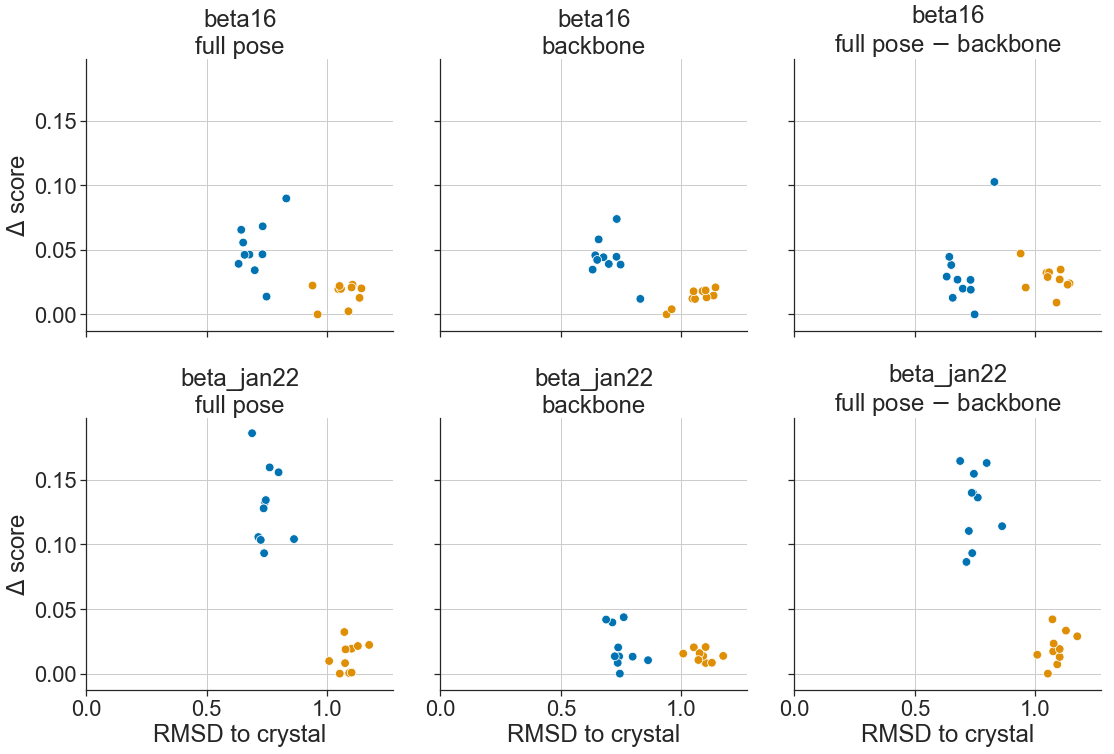

5H2LD_10


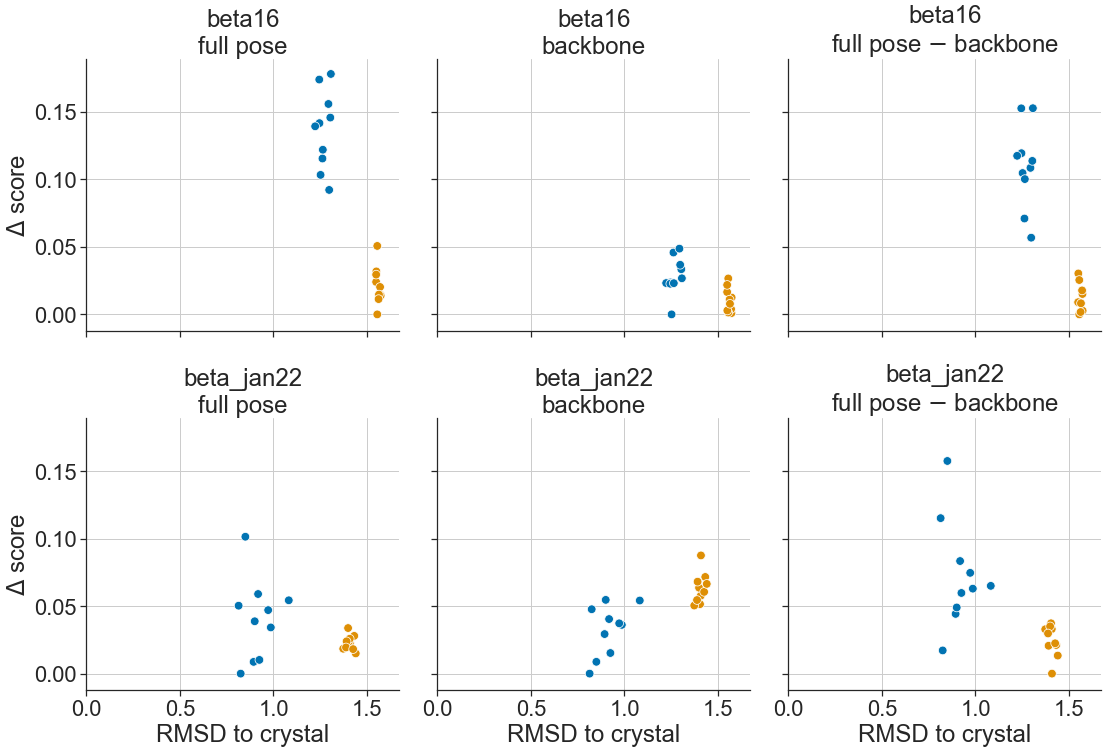

WSHC6


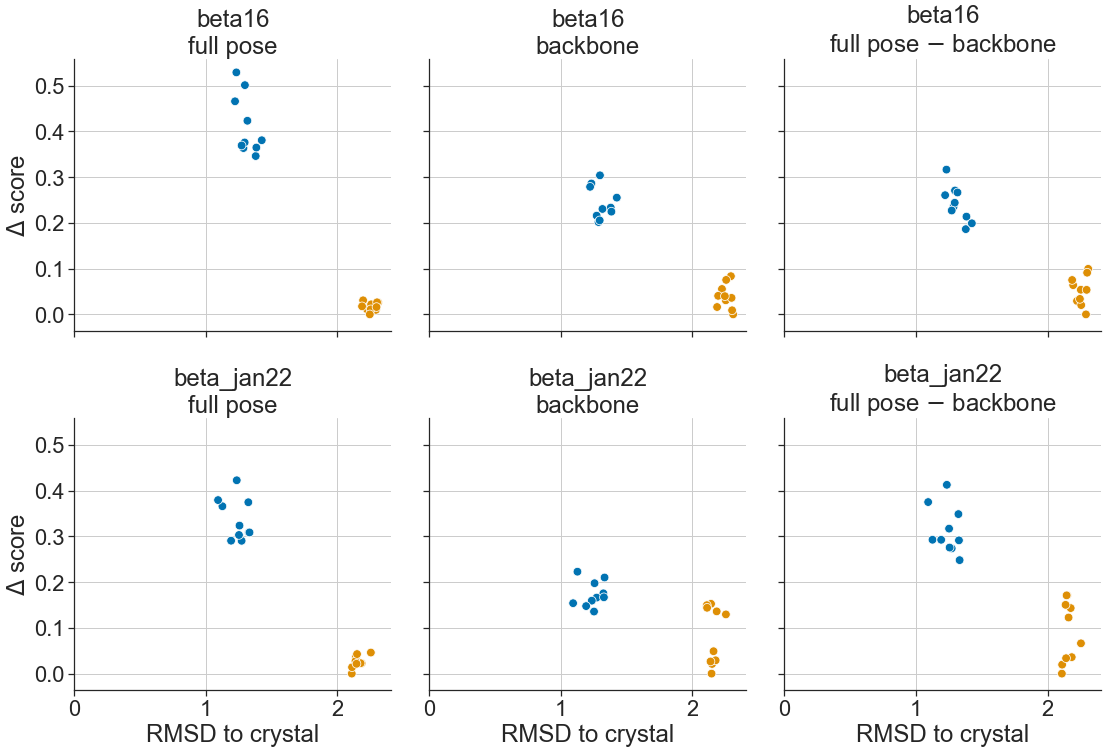

MC2_7


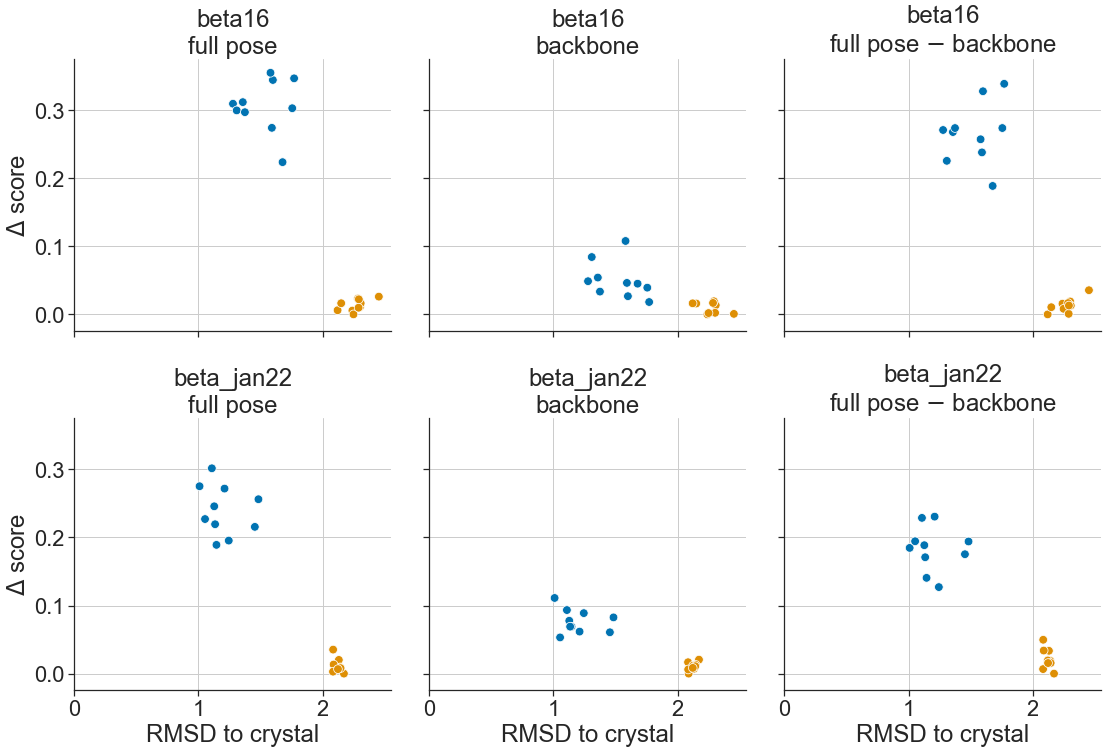

BBM2nHm0589


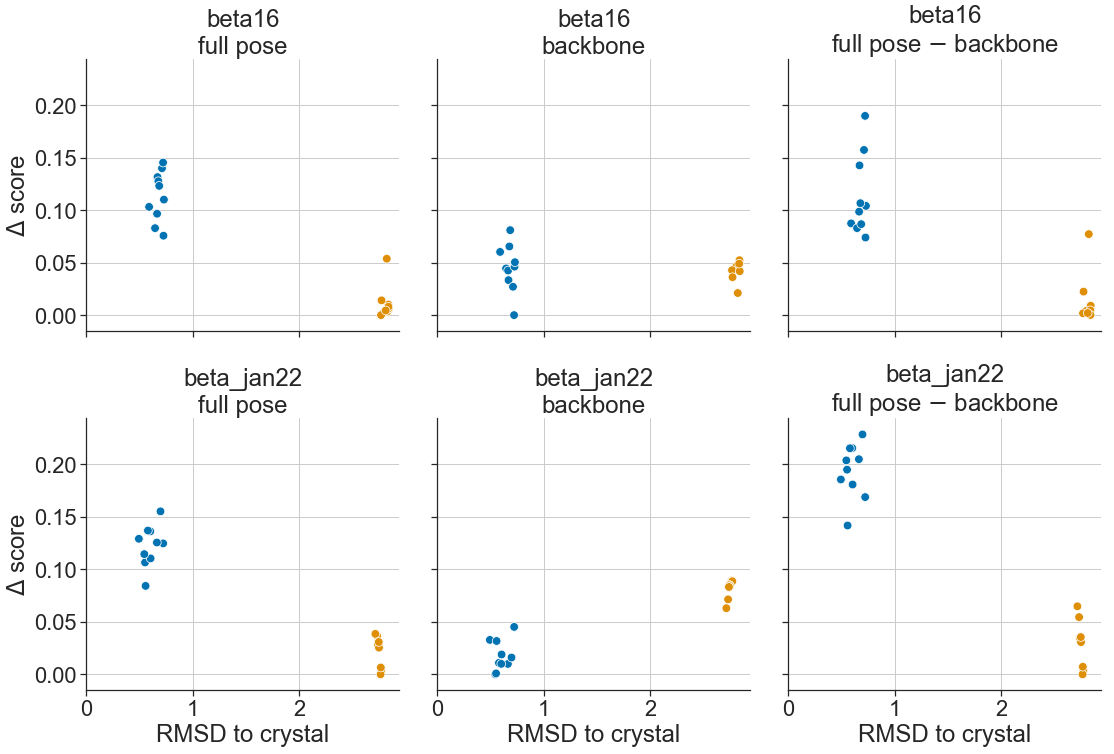

CAV1


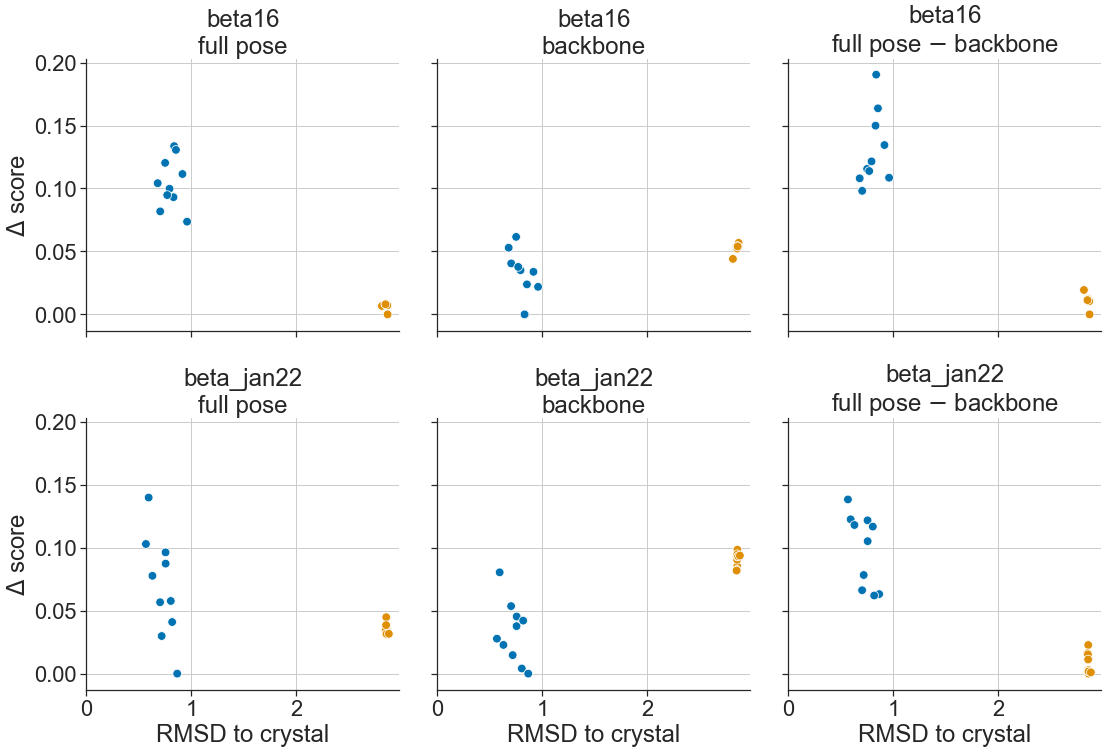

LHD29


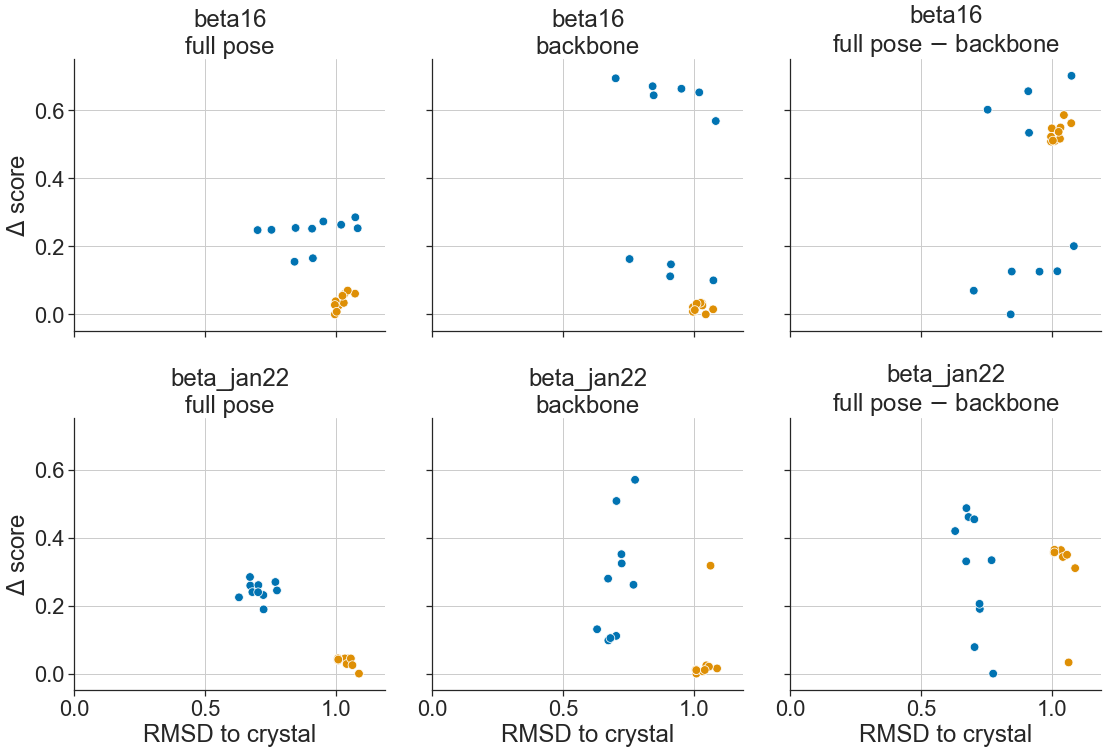

DHR4


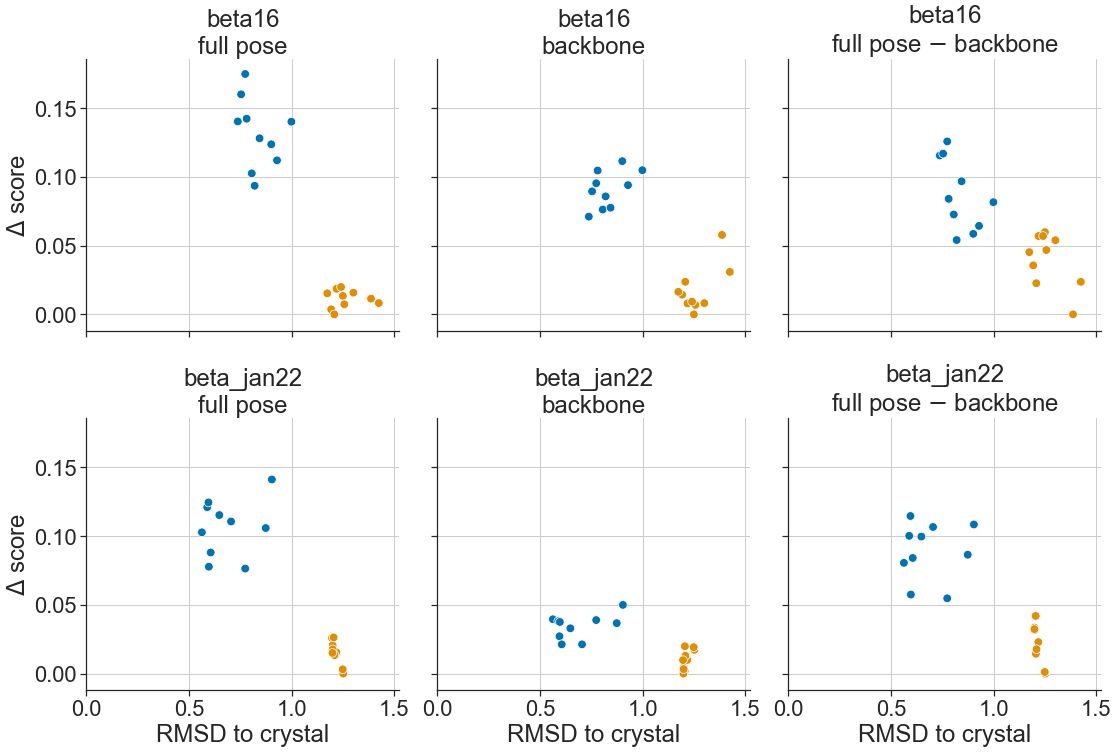

DHR8


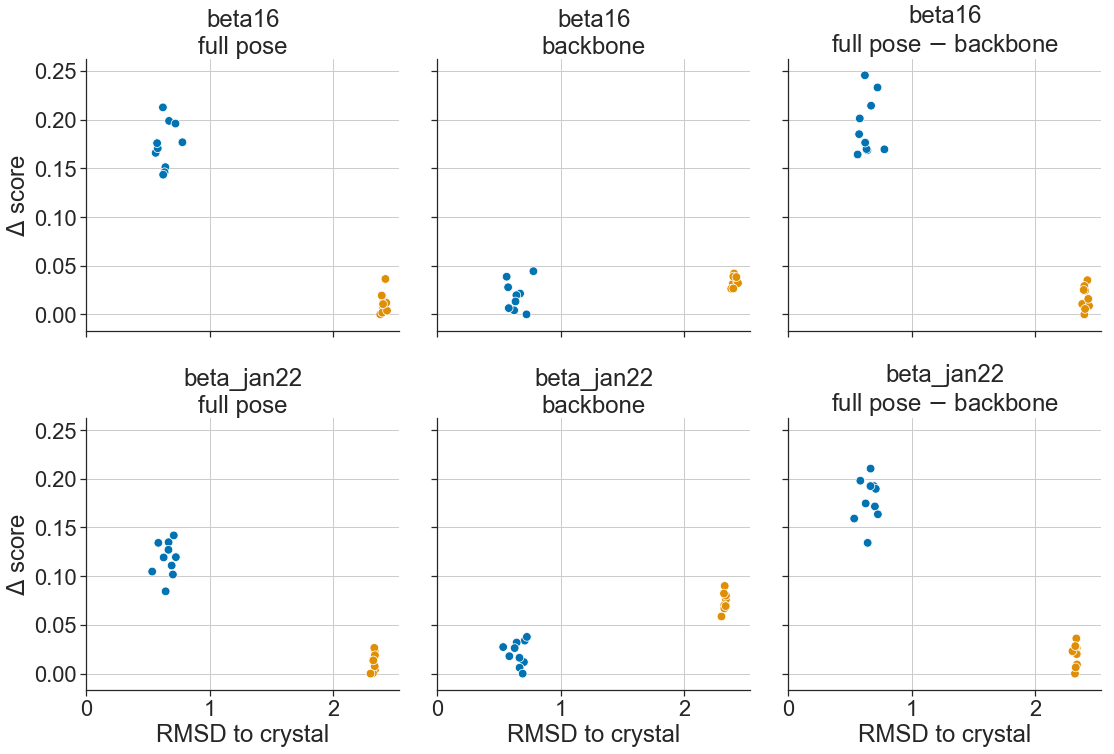

DHR14


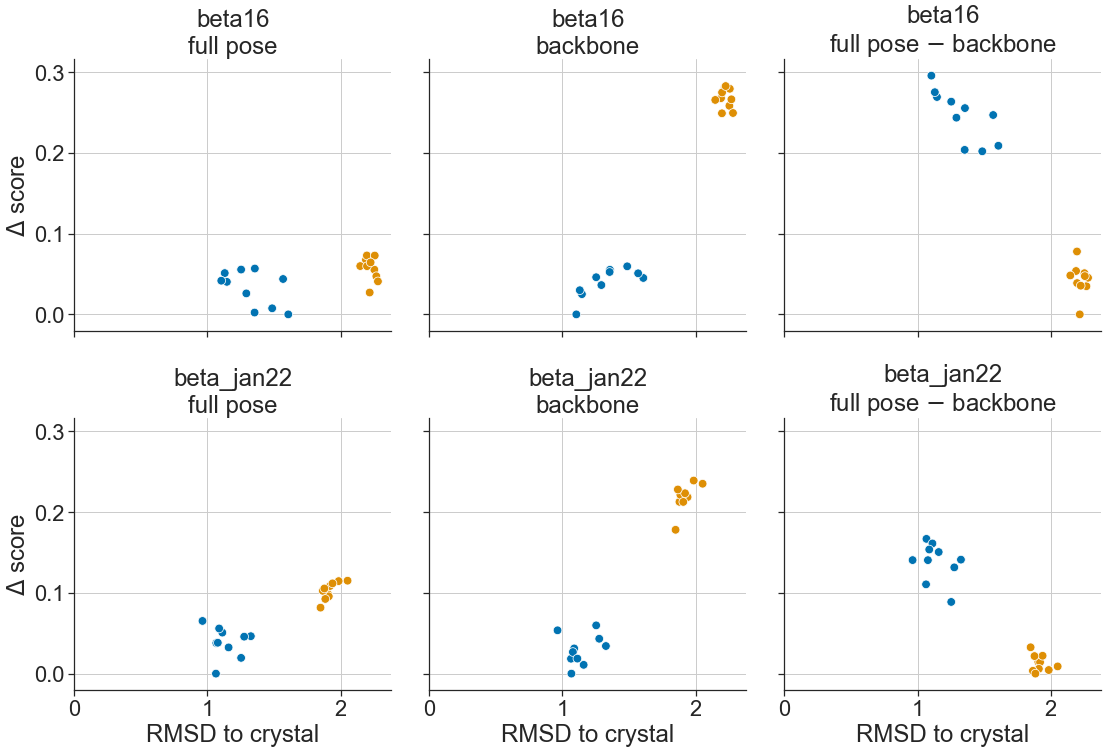

DHR76


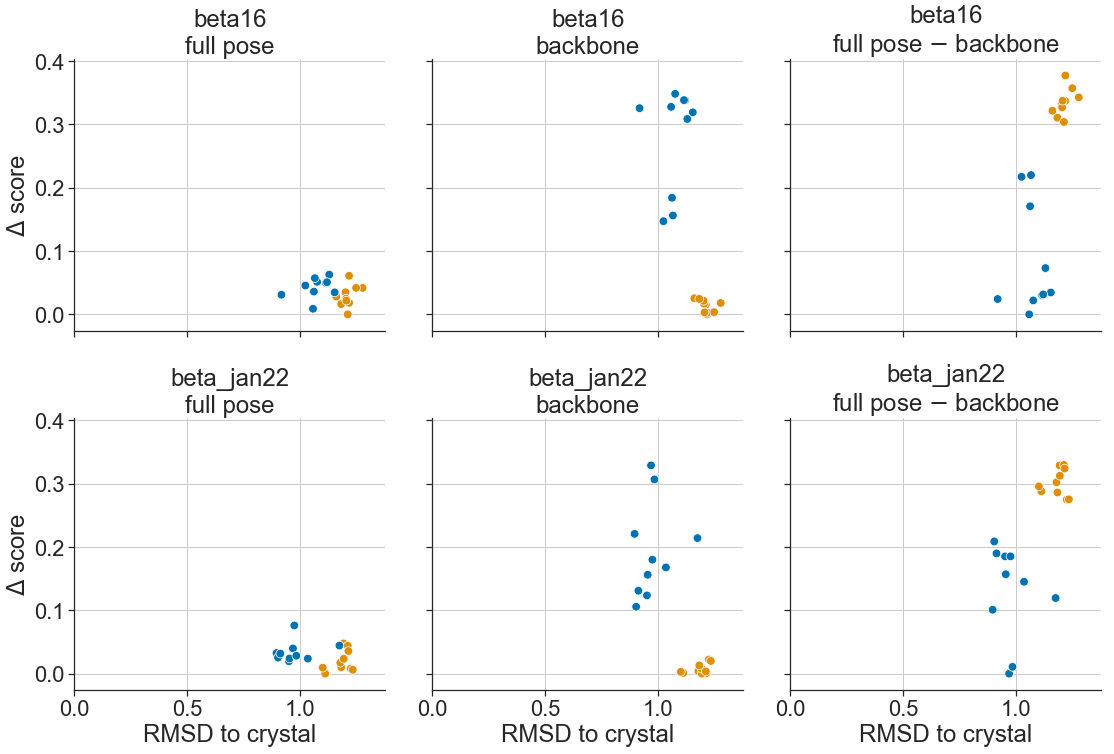

BB1


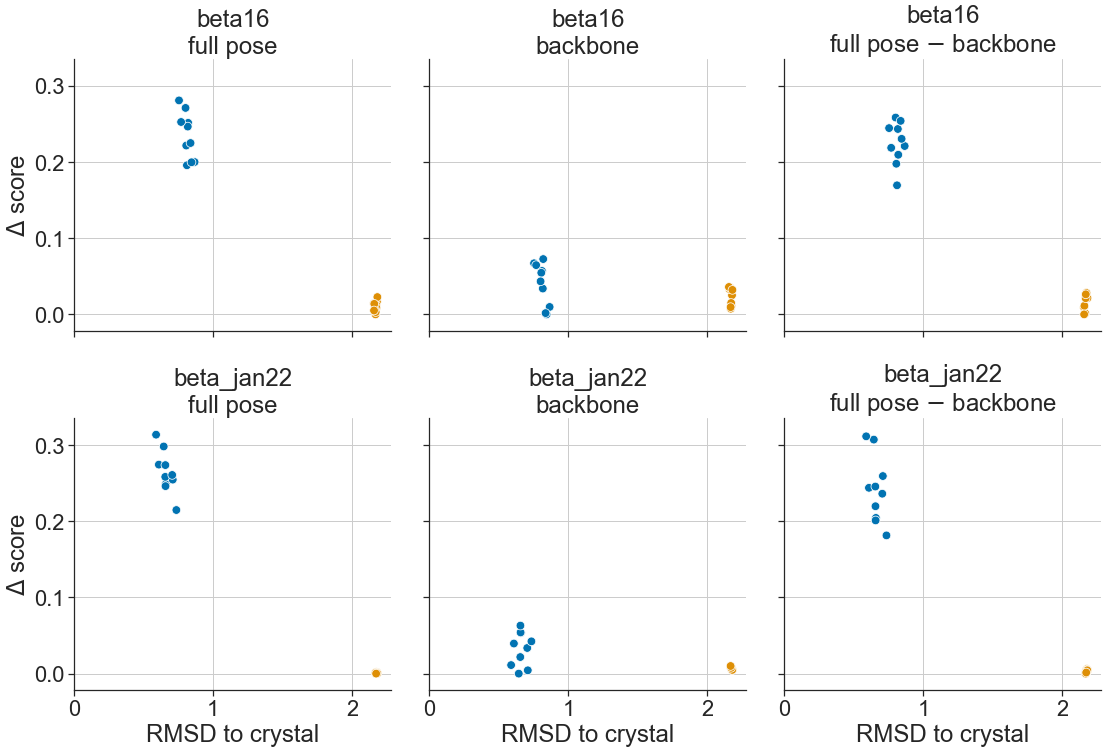

T6


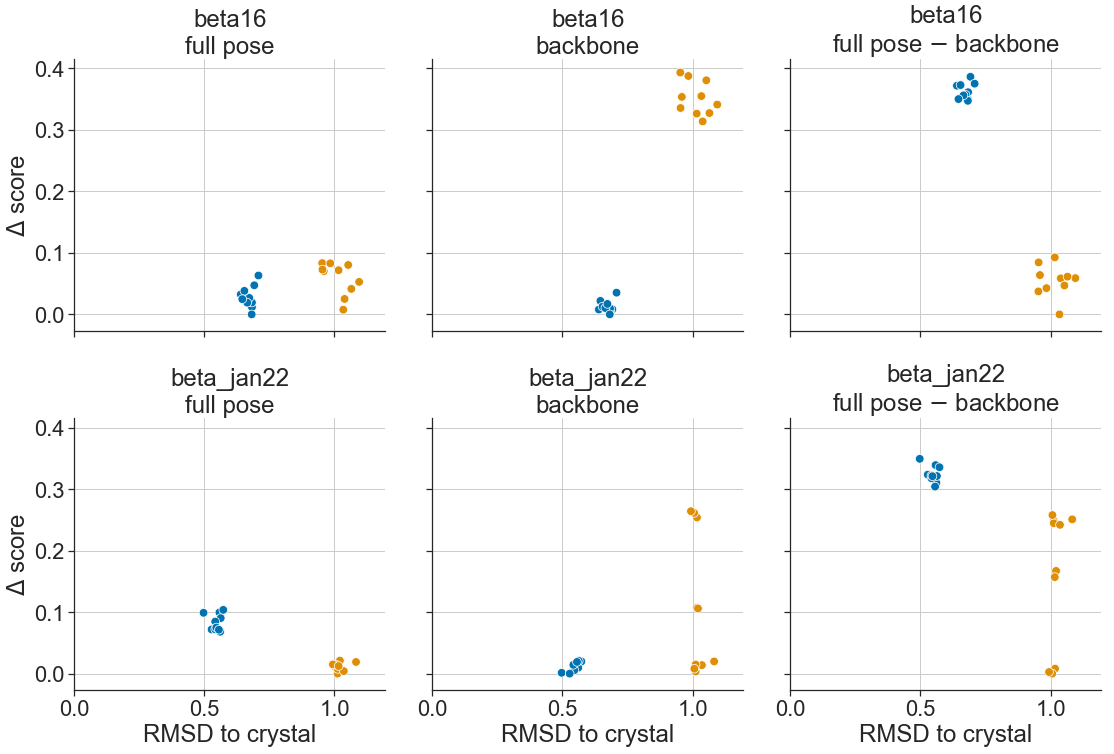

8_NSR


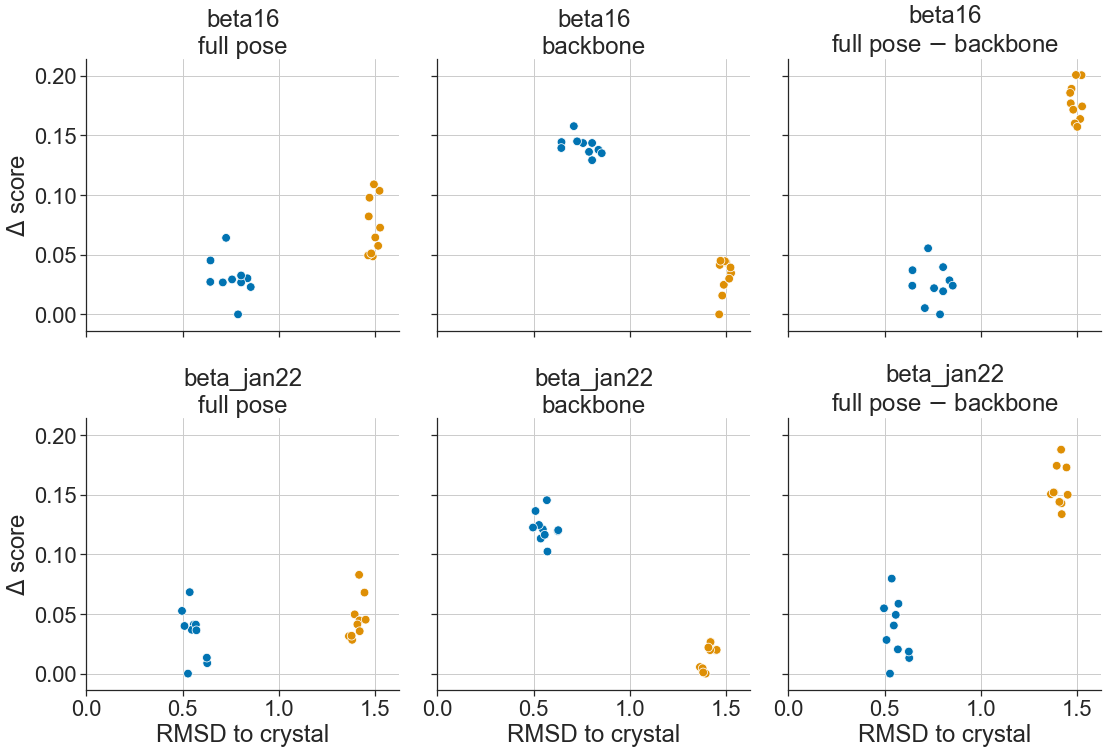

amcl1


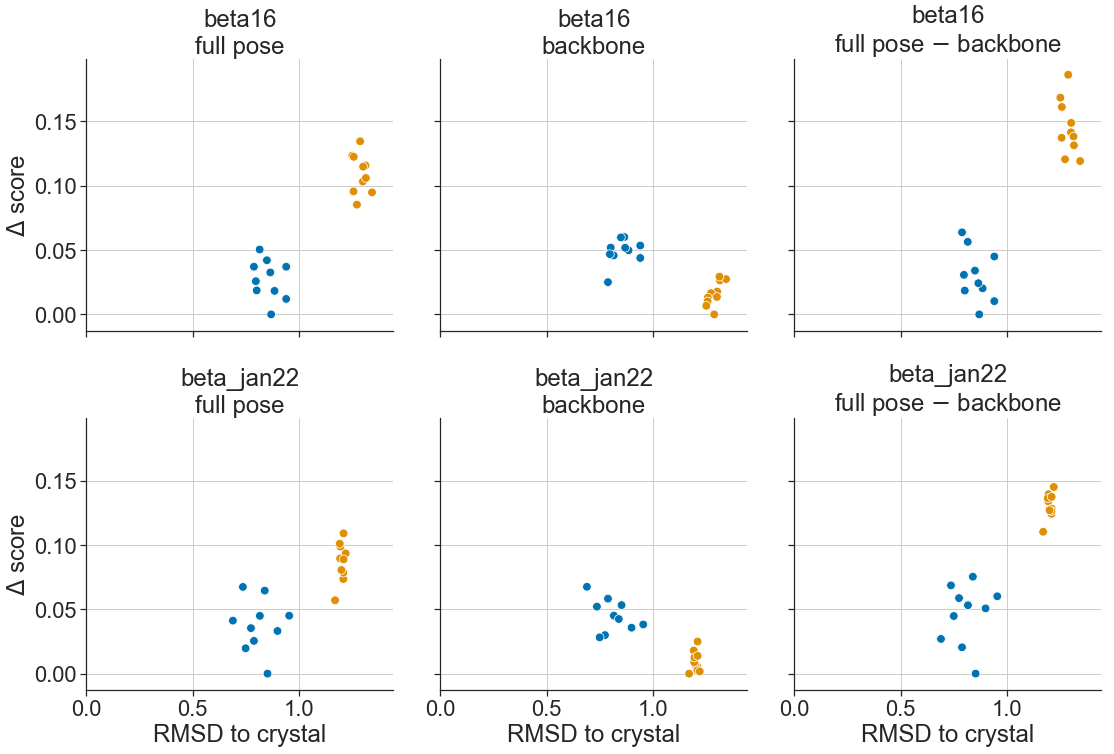

IL7_binder


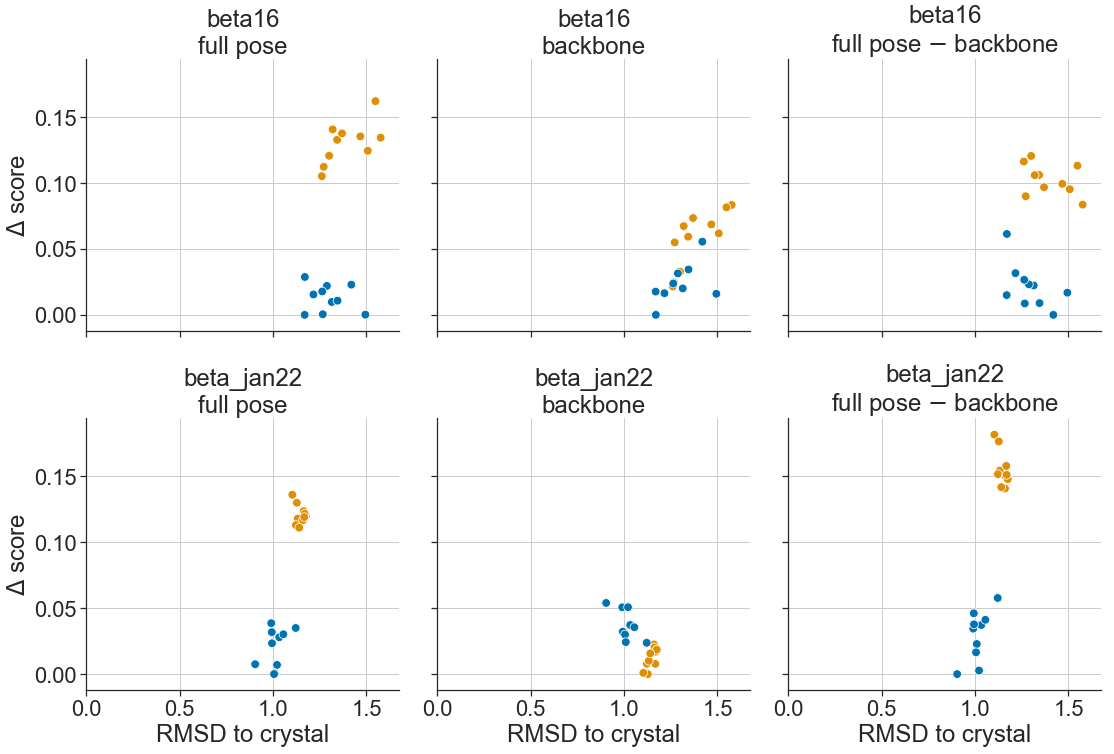

TrkA_binder


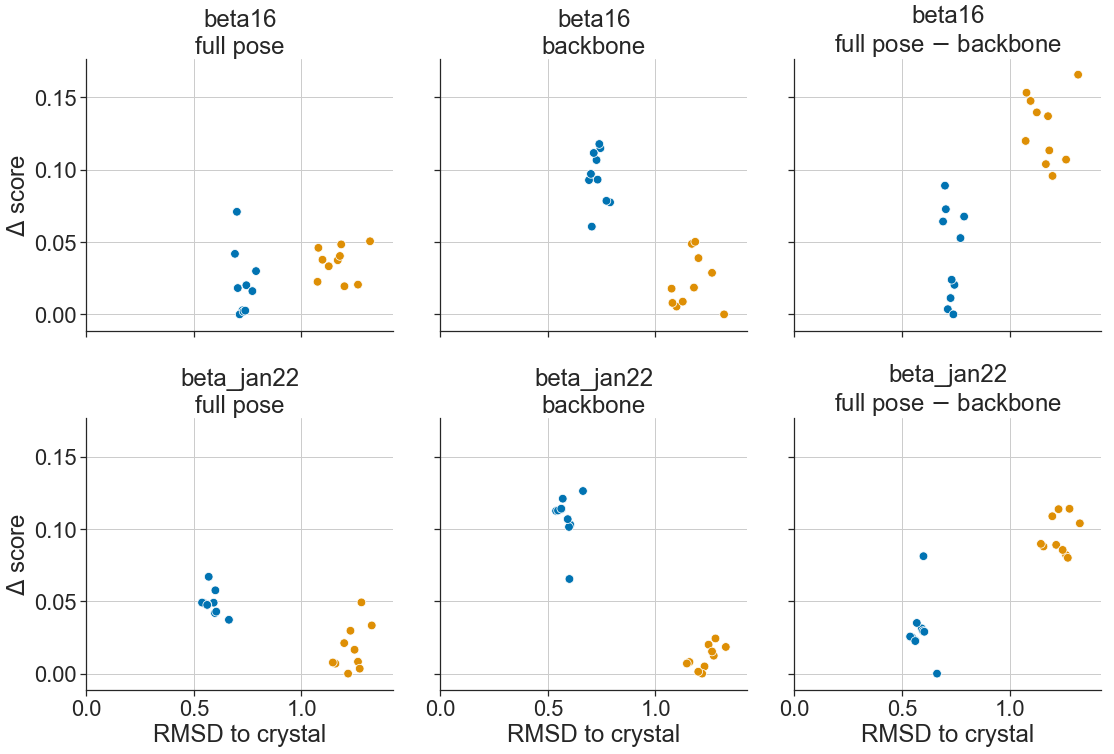

LCB1_RBD_binder


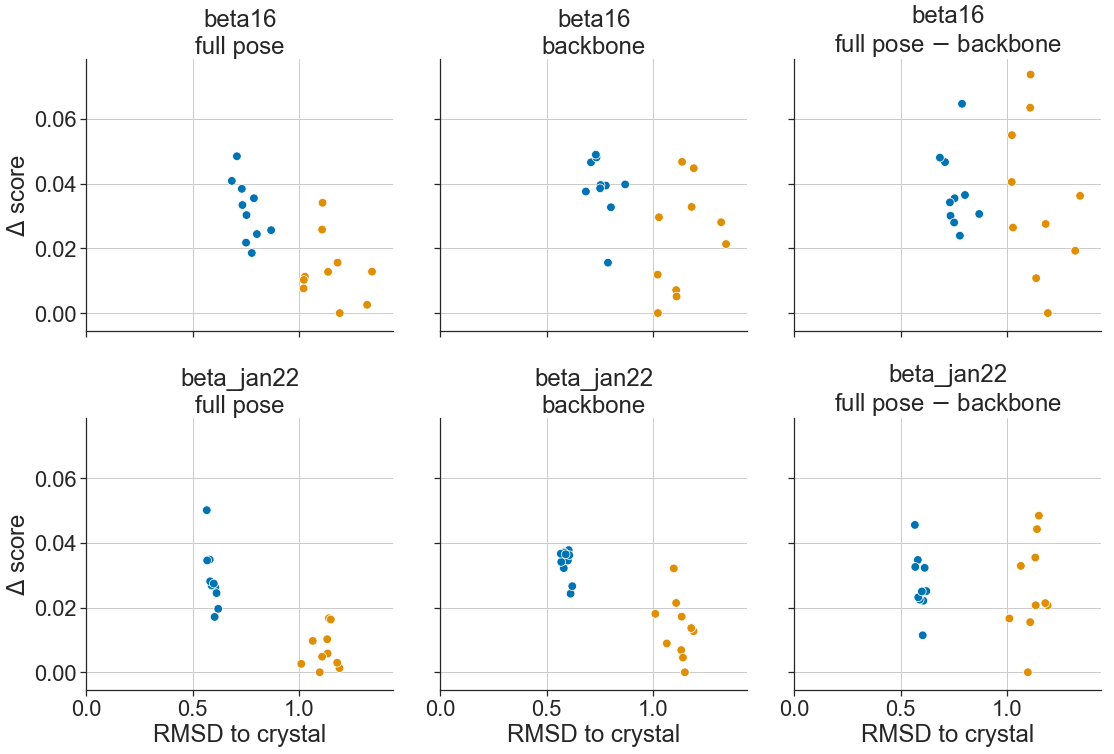

LCB3_RBD_binder


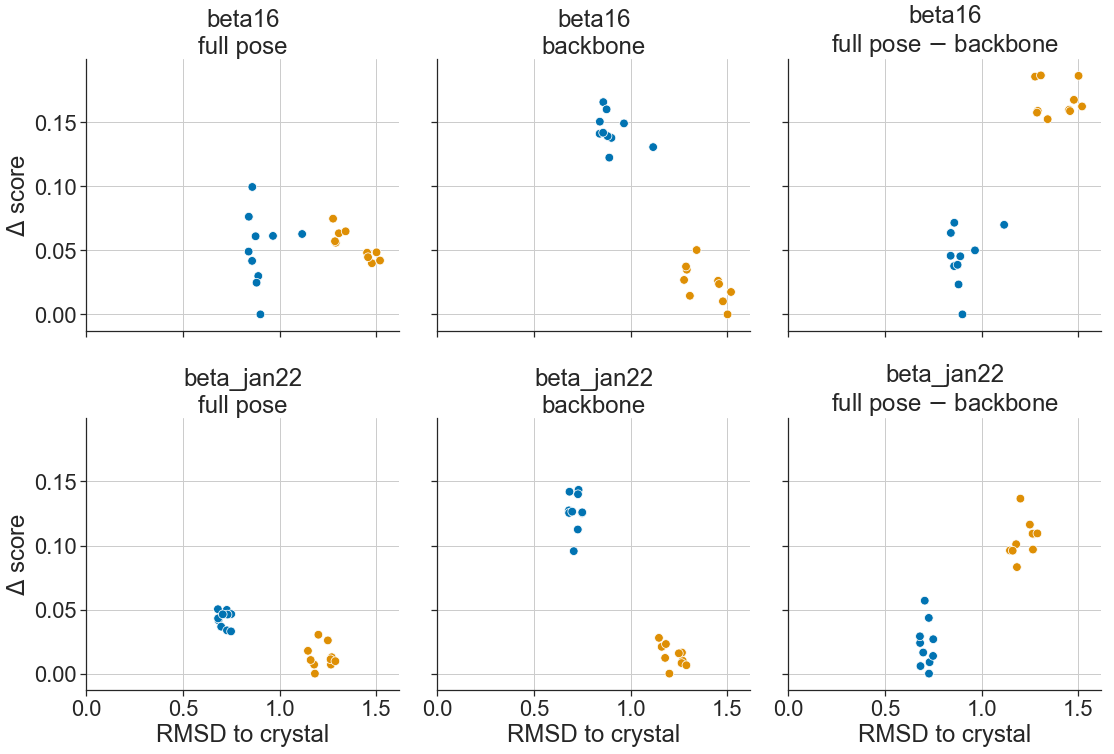

In [145]:
rms_tag = 'xtal_rms' # 'best_design_rms' #
metric = 'score' # 'fa_elec_total' # 'lj' # 'hbond_sc' # 'lj_elec_hb_sol' # 'fa_elec_total' # 'elec_hb_sol' # 'score' # 'DeepAccNet_gLDDT' # 'DeepAccNet-Bert_gLDDT' #
score_per_res = True
plot_delta = True

if score_per_res:
    ylim = [-0.05, 0.5]
else:
    ylim = [-5, 105]

if 'DeepAccNet' in metric:
    plot_delta = False
    ylim = [0.8, 1.05]
rms_label = {
    'xtal_rms' : 'RMSD to crystal',
    'design_rms' : 'RMSD to design',
    'best_design_rms' : 'RMSD to best design'
}
e_functions = [
    'beta16.nostab-refit',
    'beta_jan22',
    # 'HH_run19A_step266',
    #'HH_run19A_step266_dd2_elec_5_no_scale',
    #'HH_run19A_step266_dd2_elec_4a',
    # 'HH_run19A_step266_dd2_elec_5a',
    # 'HH_run19A_step266_dd2_elec_5a2',
    # 'HH_run19A_step266_dd2_elec_5a3',
    # 'HH_run19A_step266_dd2_elec_5a4',
    #'HH_run19A_step266_dd2_elec_5e',
    #'HH_run19A_step266_dd2_elec_5h_res0.5_pr2.5',
    # 'HH_run19A_step266_dd2_elec_5h_res0.5',
    #'HH_run19A_step266_dd_elec_5_no_scale2',
    #'HH_run19A_step266_dd_elec_5g',
    
    # 'HH_run23A_step384',
    # 'HH_run23B_sol_elec_dd2_simple_step169',
]
pdb_strs = [
    'HFuse_pH192_3_0046',
    'derroids_3_212', 'derroids_3_633',
    'R6PEP12',
    'DHD127', 'DHD_131',
    'Sh29',
    '5L6HC3_1', '6AYYA',
    
    '5H2LD_10',
    'WSHC6',
    
    'MC2_7', 'BBM2nHm0589', 'CAV1',
    'LHD29',
    'DHR4', 'DHR8', 'DHR14', 'DHR76', 
    'BB1',
    'T6', '8_NSR',
    
    'amcl1',
    'IL7_binder',
    'TrkA_binder',
    'LCB1_RBD_binder',
    'LCB3_RBD_binder',
#     'IL7_monomer',
#     'TrkA_monomer',
#     'LCB1_RBD_monomer',
#     'LCB3_RBD_monomer',
#     'FGFR_monomer',
#     '1r2m_clean_0001', '1z2u_clean_0001',
#     '3b79_clean_0001', '3ey6_clean_0001',
]

native_pdbs = sorted(list(set([
    pdb[:10] for pdb in set(scores_df['pdb'])
    if 'clean' in pdb
])))
#pdb_strs = native_pdbs
#pdb_strs = ['2o9u', '2nt4']
e_gap_dict = {
    key : []
    for key in [
        'pdb_str', 'e_function', 'xtal_min', 'design_min',
        'delta_energy', 'delta_energy_corrected',
        'energy_range', 'xtal_rms', 'design_rms',
    ]
}
relax_dirs = [
    #'cartesian_relax',
    'cartesian_relax_cr',
    #'cartesian_bb_constraints_1_no_ramp_relax',
    #'cartesian_1_cycles_relax'
]
#relax_dirs = False # 
for pdb_str in pdb_strs:
    print(pdb_str)
    data = scores_df[
        (scores_df['pdb'].str.contains(pdb_str)) &
        (scores_df['e_function'].isin(e_functions)) &
        (scores_df['design_or_xtal'].isin(['design', 'xtal'])) &
        (scores_df['rms_tag'] == rms_tag) &
        (scores_df['relax_or_score'].str.contains('score'))
    ].copy()
    if relax_dirs:
        data = data[data['relax_dir'].isin(relax_dirs)]
    if len(data) == 0:
        continue
    min_rms = 0 #-0.1
    max_rms = data['rms'].max() + 0.1

    (fig, axs) = plt.subplots(
        nrows=len(e_functions), ncols=3, sharex=True,
        sharey=plot_delta, figsize=[16,5.5*len(e_functions)]
    )
    axs = axs.reshape(-1)
    i = 0
    for e_function in e_functions:

        # Plot energies of full poses and poly-gly poses
        e_function_label = e_function.replace(
            'HH_run19A_step266', '19A'
        ).replace(
            'HH_run19A_step226', '19A'
        ).replace(
            '.nostab-refit', ''
        ).replace(
            'HH_run20C_step461', '20C'
        ).replace(
            'no_scale_default', 'no_scale'
        ).replace(
            '5h_res0.5_pr2.5', '5h*'
        ).replace(
            'sol_elec_dd2_simple_step169', '*'
        )
        for poly_gly in [False, True]:
            data = scores_df[
                (scores_df['pdb'].str.contains(pdb_str)) &
                (scores_df['e_function'] == (e_function)) &
                (scores_df['design_or_xtal'].isin(['design', 'xtal'])) &
                #(scores_df['relax_dir'] == 'cartesian_relax') &
                (scores_df['poly_gly'] == poly_gly) &
                (scores_df['rms_tag'] == rms_tag) &
                (scores_df['relax_or_score'].str.contains('score')) &
                #~(scores_df['DeepAccNet_gLDDT'].isnull()) &
                ~(scores_df[metric].isnull())
            ].copy()
            if relax_dirs:
                data = data[data['relax_dir'].isin(relax_dirs)]
            if len(data) == 0:
                i += 1
                continue
            if score_per_res:
                data[metric] = data[metric] / data['nres']
            min_val = data[metric].min()
            data[f'delta_{metric}'] = data[metric] - min_val
            if plot_delta:
                metric_to_plot = f'delta_{metric}'
            else:
                metric_to_plot = metric
            sns.scatterplot(
                x='rms', y=metric_to_plot, data=data,
                hue='design_or_xtal', hue_order=['xtal', 'design'],
                ax=axs[i], s=75
            )
            poly_gly_labels = {
                True : 'backbone',
                False : 'full pose',
            }
            axs[i].set(
                xlim=[min_rms, max_rms],
                title=f'{e_function_label}\n{poly_gly_labels[poly_gly]}',
            )
            axs[i].grid()
            if True: # i == 1:
                axs[i].get_legend().remove()
            if i+1 > (len(e_functions) - 1) * 3:
                axs[i].set(xlabel=rms_label[rms_tag])
            if i%3 == 0:
                if plot_delta:
                    axs[i].set(ylabel=f'$\Delta$ {metric}')
            else:
                axs[i].set(ylabel='')
            #axs[i].set(ylim=ylim)
            i += 1
            
        # Plot energies of the full poses after subtracting
        # energies from poly-gly counterparts
        corr_metric = metric + '_corrected'
        data = scores_df[
            (scores_df['pdb'].str.contains(pdb_str)) &
            (scores_df['e_function'] == (e_function)) &
            (scores_df['design_or_xtal'].isin(['design', 'xtal'])) &
            (scores_df['poly_gly'] == False) &
            (scores_df['rms_tag'] == rms_tag) &
            (scores_df['relax_or_score'].str.contains('score')) &
            ~(scores_df[metric].isnull())
        ].copy()
        if relax_dirs:
            data = data[data['relax_dir'].isin(relax_dirs)]
        if ('DeepAccNet' in metric):
            data[corr_metric] = 0
        if (len(data) == 0):# or ('DeepAccNet' in metric):
            i += 1
            continue
        if score_per_res:
            data[metric] = data[metric] / data['nres']
            data[corr_metric] = data[corr_metric] / data['nres']
            
        if sum(~data[corr_metric].isnull()) > 0:
            min_val = data[corr_metric].min()
            data[f'delta_{corr_metric}'] = data[corr_metric] - min_val
            if plot_delta:
                metric_to_plot = f'delta_{corr_metric}'
            else:
                metric_to_plot = corr_metric
            sns.scatterplot(
                x='rms', y=metric_to_plot, data=data,
                hue='design_or_xtal', hue_order=['xtal', 'design'],
                ax=axs[i], s=75
            )
            axs[i].set(
                xlim=[min_rms, max_rms],
                title=f'{e_function_label}\nfull pose $-$ backbone',
            )
            axs[i].grid()
            axs[i].get_legend().remove()
            if i+1 > (len(e_functions) - 1) * 3:
                axs[i].set(xlabel=rms_label[rms_tag])
            axs[i].set(ylabel='')
            # axs[i].set(ylim=ylim)
        i += 1
        
        # Record energy gaps
        n_avg = 3
        data.sort_values(metric, inplace=True, ascending=True)
        xtal_min = data[
            data['design_or_xtal'] == 'xtal'
        ][metric][:n_avg].mean()
        design_min = data[
            data['design_or_xtal'] == 'design'
        ][metric][:n_avg].mean()
        delta_energy = xtal_min - design_min

        xtal_min_corrected = data[
            data['design_or_xtal'] == 'xtal'
        ][corr_metric][:n_avg].mean()
        design_min_corrected = data[
            data['design_or_xtal'] == 'design'
        ][corr_metric][:n_avg].mean()
        delta_energy_corrected = \
            xtal_min_corrected - design_min_corrected
        xtal_rms = data[
            data['design_or_xtal'] == 'xtal'
        ]['rms'][:n_avg].mean()
        design_rms = data[
            data['design_or_xtal'] == 'design'
        ]['rms'][:n_avg].mean()
        
        energies = data[metric].copy()
        energies = energies.dropna()
        energy_min = energies[:n_avg].mean()
        energy_max = energies[-n_avg:].mean()
        energy_range = energy_max - energy_min
        
        e_gap_dict['pdb_str'].append(pdb_str)
        e_gap_dict['e_function'].append(e_function)
        e_gap_dict['xtal_min'].append(xtal_min)
        e_gap_dict['design_min'].append(design_min)
        e_gap_dict['delta_energy'].append(delta_energy)
        e_gap_dict['delta_energy_corrected'].append(
            delta_energy_corrected
        )
        e_gap_dict['energy_range'].append(energy_range)
        e_gap_dict['xtal_rms'].append(xtal_rms)
        e_gap_dict['design_rms'].append(design_rms)

    plt.tight_layout(h_pad=1.2)
    sns.despine()
    plt.show()

e_gap_df = pandas.DataFrame(e_gap_dict)
e_gap_df['metric'] = metric

derroids_3_212
beta16.nostab-refit 10 10
HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14 10 10


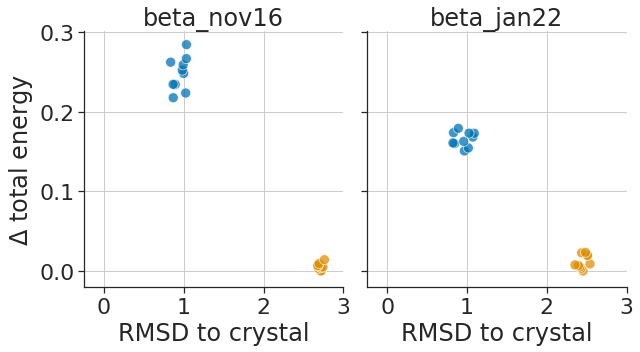

In [40]:
metric = 'score' # 'fa_elec_total' # 'lj' # 'hbond_sc' # 'lj_elec_hb_sol' #
pdb_str = 'derroids_3_212' # 'CAV1' # 'MC2_7' # 'HFuse_pH192_3_0046' # '6AYYA' # 'BB1' # 'DHD127' # 'CAV1' # 'Sh29' # 'DHD_131' # 'LHD29' # 'BBM2nHm0589' # 'LCB3_RBD_binder' # '5H2LD_10' # 'CAV1' # 'LCB1_RBD_binder' # 'DHD127' # 'derroids_3_633' # '5L6HC3_1' # 'LCB3_RBD_binder' # 
rms_tag = 'xtal_rms'
score_per_res = True
e_functions = [
    'beta16.nostab-refit',
    #'HH_run19A_step266',
    #'beta16.nostab-refit',
#    'HH_run19A_step266_dd2_elec_5_no_scale',
    #'HH_run19A_step266_dd2_elec_5a2',
#     'HH_run19A_step266_dd2_elec_5a14',
    #'HH_run19A_step266_dd2_elec_5a11',
    #'HH_run19A_step266_dd2_elec_5a12',
    #'HH_run19A_step266_dd2_elec_5a13',
    #'HH_run19A_step266_dd2_elec_5a6',
#     'HH_run19A_step266_dd2_elec_5e',
#     'HH_run19A_step266_dd_elec_5_no_scale2',
#    'HH_run19A_step266_dd_elec_5g',
    
#     'HH_run23A_step384',
#     'HH_run23A_step384_cf_1b',
#     'HH_run23B_sol_elec_dd2_simple_step169',
#     'HH_run23B_sol_elec_dd2_simple_step169_5a3_14',
#     'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
print(pdb_str)
#print(e_functions)
relax_dirs = [
    'cartesian_relax_cr',
    #'cartesian_bb_constraints_1_relax_cr',
    #'cartesian_bb_constraints_1_no_ramp_relax_cr',
]
(fig, axs) = plt.subplots(
    ncols=(len(e_functions)),
    figsize=[4.5*len(e_functions), 5],
    sharey=True, sharex=True
)
title_dict = {
    'beta16.nostab-refit' : 'beta_nov16',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' : 'beta_jan22'
}
for (i, e_function) in enumerate(e_functions):
    data = scores_df[
        (scores_df['pdb'].str.contains(pdb_str)) &
        (scores_df['e_function'] == e_function) &
        (scores_df['relax_dir'].isin(relax_dirs)) &
        (scores_df['poly_gly'] == False) &
        (scores_df['rms_tag'] == rms_tag) &
        (scores_df['relax_or_score'].str.contains('score')) &
        ~(scores_df[metric].isnull())
    ].copy()
    print(
        e_function,
        sum(data['design_or_xtal'] == 'xtal'),
        sum(data['design_or_xtal'] == 'design')
    )
    if score_per_res:
        data[metric] = data[metric] / data['nres']
    min_val = data[metric].min()
    data[f'delta_{metric}'] = data[metric] - min_val
    sns.scatterplot(
        x='rms', y=f'delta_{metric}', data=data,
        hue='design_xtal_af2', hue_order=['xtal', 'design', 'af2'],
        s=100, alpha=0.75, ax=axs[i]
    )
    axs[i].get_legend().remove()
    axs[i].set(
        xlim=[-0.25, 3], xticks=[0, 1, 2, 3],
        #ylim=[-5, 90],
        xlabel='RMSD to crystal',
        title=title_dict[e_function]
    )
    axs[i].grid()

if metric == 'fa_elec_total':
    axs[0].set(ylabel=f'$\Delta$ electrostatics')
elif metric == 'score':
    axs[0].set(ylabel=f'$\Delta$ total energy')
else:
    axs[0].set(ylabel=f'$\Delta$ {metric}')

plt.tight_layout()
sns.despine()
plt.show()

**Observations**

* does shifting infec pts to left (long, med) still close gap in fa_elec? what about total_score?
    * derroids_3_212
        * elec still closed for 10, 11; partially for 12, 13
        * total score decreases a bit for 10, 11; bit less for 12, 13

* does increasing elec scale factor to 0.4, 0.6, 0.8 still close gap in fa_elec? what about total_score?
    * derroids_3_212: still closed for 0.4, but not for 0.6, 0.8 
    * HFuse: still partially closed for 0.4, 0.6

* does scaling H-bond energies help with derroids_3_212?
    * HH_run19A_step266_dd2_elec_5a3-6
    * see large reduction in H-bond gap. But only small reduction in total-score gap

* HFuse_pH192_3_0046
    * elec closes ~100, 50 EUs
    * elec_hb_sol widens ~0, 10 EUs
    * lj_elec_hb_sol widens ~20, 20 EUs
    * score widens ~100, 100 EUs

* MC2_7
    * elec closes ~20, 0 EUs
    * elec_hb_sol widens ~0, 10 EUs
    * lj_elec_hb_sol changes ~5, -10 EUs
    * score widens ~0, 10 EUs

* LHD29
    * elec closes ~20, 15 EUs
    * elec_hb_sol closes ~7, 12 EUs
    * lj_elec_hb_sol widens ~10, 10 EUs
    * score closes ~2, 10 EUs    

* LCB3_RBD_binder
    * elec closes ~5, 20 EUs
    * elec_hb_sol closes ~25, 25 EUs
    * lj_elec_hb_sol widens ~15, 40 EUs
    * score closes ~20, 25 EUs    

* 5H2LD_10
    * elec closes ~50, 15 EUs
    * elec_hb_sol closes ~15, 0 EUs
    * lj_elec_hb_sol widens ~30, 0 EUs
    * score closes ~10, 0 EUs    

* BBM2nHm0589
    * elec closes ~15, 15 EUs
    * elec_hb_sol closes ~10, 10 EUs
    * lj_elec_hb_sol widens ~20, 10 EUs
    * score closes ~5, 10 EUs

* DHD_131
    * elec closes ~15, 15 EUs
    * elec_hb_sol closes ~15, 25 EUs
    * lj_elec_hb_sol closes ~15, 10 EUs
    * score closes ~5, 0 EUs
    
* DHD_127
    * elec closes ~30, 30 EUs
    * elec_hb_sol closes ~15, 15 EUs
    * lj_elec_hb_sol closes ~20, 10 EUs
    * score negative for both with similar deltas
    
* CAV1
    * elec closes ~5, 0 EUs
    * elec_hb_sol closes ~15, 10 EUs
    * lj_elec_hb_sol widens ~5, 5 EUs
    * score closes ~5, 0 EUs
    
* structures where dd2 elec helps close score gap
    * LHD29 (0.02, 0.07)
    * LCB1_RBD_binder (0.07, 0.05)
    * LCB3_RBD_binder (0.05, 0.07)
    * BBM2nHm0589 (0.02, 0.07)
    
* structures where dd2 elec widens score gap
    * MC2_7 (0, 0.1)
    * HFuse_pH192_3_0046 (0, 0.1)

**Observations**

* dd variant completely close elec gap for derroid_212; adding scaling reverses the gap
* derroid_3_633
    * Lowest-energy points have lower RMSD
    * dd2 variant closes elec gap for derroid_633; reverses sc gap

* PPI complexes
    * Examples where dd2 closes gaps in fa_elec
        * IL7: noisy, but looks like it helps widen the gap by widening the sc gap
        * TrkA: takes a gap of zero, and turns it into a negative gap based on sc and bb energies
            * There are numerous examples of semi-buried interactions that are present or more optimal in xtal
            * Part of preference for design may be backbone interactions near loop that changes conformation
        * LCB1: closes a positive gap based on closing sc gap
        * LCB3: mostly closes a positive gap
* PPI monomers
    * Examples where dd2 closes gaps in fa_elec
        * IL7: might help a little with monomer
        * TrkA: helps close a smallish gap
        * LCB1: mostly closes large gap; completely closes sc gap

* 8a2 doing slightly better than 8a

* electrostatics involving sidechain atoms partially account for energy differences
    * Big gap in fa_elec favoring the design
        * derroids_3_212
        * HFuse_pH192_3_0046
    * LHD29: there is a 25 unit energy decrease in fa_elec between the left and right of the landscape

* For 19A, tends to be favorable for RMSDs close to xtal, indicating that beta16 is favoring structures that are further away due to differences in LJ (probably clashing).

* LJ also correlated
    * Perhaps this is from salt bridges. This might be physically accurate, but might suggest that fa_sol should be weighed for strongly to counter-balance this effect

Plot the distribution of RMSDs between starting crystal structures and relaxed designs

xtal_rms


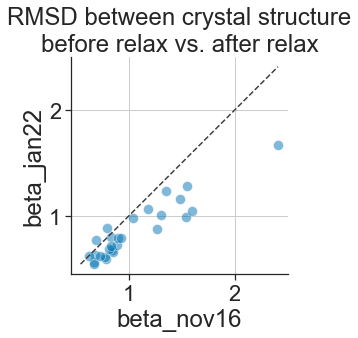

27


e_function          beta16.nostab-refit  beta_jan22      diff
pdb_str                                                      
HFuse_pH192_3_0046             2.406000    1.671667  0.734333
R6PEP12                        1.538333    0.989667  0.548667
derroids_3_633                 1.593667    1.048333  0.545333
5H2LD_10                       1.270667    0.881333  0.389333
DHR14                          1.482333    1.158667  0.323667
IL7_binder                     1.309667    1.011667  0.298000
MC2_7                          1.547333    1.281000  0.266333
DHR4                           0.851667    0.659000  0.192667
8_NSR                          0.783667    0.594000  0.189667
LCB3_RBD_binder                0.890667    0.725000  0.165667
LCB1_RBD_binder                0.778000    0.612667  0.165333
BB1                            0.840333    0.683667  0.156667
derroids_3_212                 0.928333    0.791667  0.136667
T6                             0.676667    0.548333  0.128333
LHD29                          0.817333    0.691333  0.126000
Sh29                           0.836333    0.722667  0.113667
DHD_131                        1.180333    1.068000  0.112333
WSHC6                          1.349667    1.238667  0.111000
BBM2nHm0589                    0.677667    0.570000  0.107667
TrkA_binder                    0.727667    0.621667  0.106000
amcl1                          0.899000    0.797333  0.101667
DHR76                          1.044333    0.981000  0.063333
DHD127                         0.682667    0.632667  0.050000
CAV1                           0.831667    0.800667  0.031000
DHR8                           0.632667    0.626333  0.006333
6AYYA                          0.693000    0.774667 -0.081667
5L6HC3_1                       0.796333    0.889667 -0.093333

In [148]:
metric = list(set(e_gap_df['metric']))
assert len(metric) == 1
metric = metric[0]
values = 'xtal_rms' # 'delta_energy' # 
score_per_res = True
print(values)
e_gap_df[values] = e_gap_df[values].astype(float)
data = e_gap_df.pivot(
    index='pdb_str', columns='e_function',
    values=values
)
min_val = data.min().min()
max_val = data.max().max()
plt.gca().set_aspect('equal')
sns.scatterplot(x='beta16.nostab-refit', y='beta_jan22', data=data, s=100, alpha=0.5)
plt.xlabel('beta_nov16')
plt.title('RMSD between crystal structure\nbefore relax vs. after relax')
plt.plot([min_val, max_val], [min_val, max_val], ls='--', c='0.25')
plt.grid()
sns.despine()
plt.show()
print(len(data))
data['diff'] = data['beta16.nostab-refit'] - data['beta_jan22']
data.sort_values('diff', ascending=False)

Plot all energy gaps

delta_energy


ValueError: Could not interpret input '19A'

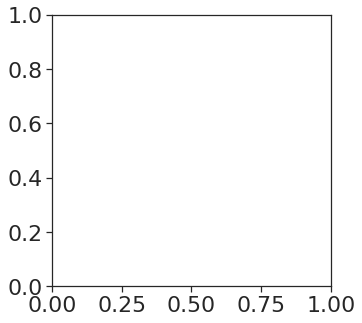

In [41]:
metric = list(set(e_gap_df['metric']))
assert len(metric) == 1
metric = metric[0]
values = 'delta_energy' # 'xtal_rms' #
score_per_res = True
print(values)
e_gap_df[values] = e_gap_df[values].astype(float)
data = e_gap_df.pivot(
    index='pdb_str', columns='e_function',
    values=values
)
data.rename(columns={
    col : col.replace(
        'beta16.nostab-refit', 'beta16'
    ).replace(
        'HH_run19A_step266', '19A'
    ).replace(
        'HH_run19A_step226', '19A'
    ).replace(
        'HH_run20C_step461', '20C'
    ).replace(
        'no_scale_default', 'no_scale'
    ).replace(
        'HH_run23A_step384', '23A'
    ).replace(
        'HH_run23B_sol_elec_dd2_simple_step169', '23B'
    )
    for col in data
}, inplace=True)
e_functions = [
    #'19A_dd2_elec_no_scale',
    '19A_dd2_elec_5a',
    #'19A_dd2_elec_5a3',
    #'19A_dd2_elec_5a4',
    #'19A_dd2_elec_5h_res0.5',
    #'19A_dd_elec_5g',
    #'19A_dd2_elec_5_no_scale',
    
    #'23B',
    
    #'23A',
    '19A',
    #'beta16',
    
]
#data = data[data[e_functions[0]].between(-300, 300)]

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
sns.scatterplot(
    x=e_functions[1], y=e_functions[0],
    data=data, s=100, alpha=0.75
)
if values == 'xtal_rms':
    (min_val, max_val) = (0.5, 1.5)
elif score_per_res:
    (min_val, max_val) = (-0.2, 0.4)
else:
    max_val = data[e_functions].max().max() + 5
    min_val = min([-50, data[e_functions].min().min()])
    (min_val, max_val) = (-50, 100) #  (-100, 200)
    #min_val = min([-0.1, data[e_functions].min().min()])
    #(min_val, max_val) = (-40, 20)
plt.plot([min_val,max_val], [min_val,max_val], ls='--', c='0.5')
print(metric)
#plt.title(f'energy gaps of all\ndesign-crystal pairs')
if 'corrected' in values:
    plt.title(f'$\Delta$ {metric} corrected')
else:
    plt.title(f'$\Delta$ {metric}')
if values == 'xtal_rms':
    tick_width = 0.5
    ticks = np.arange(min_val, max_val+tick_width, tick_width)
elif score_per_res:
    tick_width = 0.2 # 50
    ticks = np.arange(min_val, max_val+tick_width, tick_width)
else:
    tick_width = 50 # 100 # 
    ticks = np.arange(min_val, max_val+tick_width, tick_width)
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal', adjustable='box')
plt.grid()
sns.despine()
plt.show()

**Observations**
* 19A_env_dep9a/b
    * as expected, fa_elec gap becomes less positive for some points, with a large effect on a few points, and minor effects on others
    * this effect is slightly larger for 9a (10-20 neighbor cutoff) vs. 9b (10-25 neighbor cutoff), which is expected given the expanded cutoff

* hbond_sc
    * 19A_env_dep9a/b are about the same as 19A
    * 20C_new_hbpoly9j looks a bit better than 19A
* hbond_bb_sc
    * 19A_env_dep9a/b and 20C_new_hbpoly9j are about the same as 19A
* hbond_sr_bb
    * 19A_env_dep9a/b are about the same as 19A
    * 20C_new_hbpoly9j is similar, but HFuse is an outlier, favoring 20C
    
* lk_ball
    * counter-acts fa_elec
    
* why doesn't fa_elec gap close more?

In [ ]:
print(metric)
data['diff'] = data[e_functions[0]] - data[e_functions[1]]
data.sort_values('diff', ascending=True, inplace=True)
#data.dropna()
data[e_functions + ['diff']]

**Observations**

* score: most designs have positive gap

* fa_elec: similar to "score", with the HFuse design having a HUGE gap

* hbond_sc: similar to "score", except that the HFuse design actually has a negative gap (only for 19A though), which contrasts with the huge elec gap
    * HFuse result: due to differences in H-bond weights between beta16 and 19A? due to hb_sc?

* hbond_bb_sc: tends to be close to zero, but is large and positive for the HFuse design

* lk_ball: tends to favor the relaxed crystal, consistent with relaxed designs making more H-bonds

* lj_elec_hb_sol: similar to "score", suggesting that the overall balance between attractive forces and desolvation is off.

* potential solutions:
    * burial-dependent elec and H-bond terms
    * reduce H-bond weights for charged atom types
    * make the solvation term more directional

* DHR76: helix flayed at C-term. Design model has huge clash

Plot the distribution of RMSDs between starting crystal structures and relaxed designs

In [ ]:
e_function = 'beta16.nostab-refit'
pdb_strs_to_ignore = [
    'IL7_binder',
    'LCB1_RBD_binder',
    'LCB3_RBD_binder',
    'TrkA_binder',
    'amcl1',
]
data = e_gap_df[
    (e_gap_df['e_function'] == e_function) &
    (e_gap_df['pdb_str'].isin(pdb_strs_to_ignore))
].copy()
#data[['pdb_str', 'xtal_rms', 'design_rms']].head()
rms_metric = 'design_rms'
max_val = math.ceil(data[rms_metric].max())
bins = np.arange(-0.5, max_val+0.5, 1)
sns.distplot(data[rms_metric], kde=False, bins=bins, color='0.25')
plt.xlabel(r'C$\alpha$-RMSD to crystal structure')
plt.ylabel('number of designs')
sns.despine()
plt.show()

Compute per-residue energy differences for poses of interest

In [42]:
import hbond_cart_utils

In [43]:
pdb_str = 'derroids_3_212' # 'Sh29' # 'BB1' # 'DHD_131' # 'CAV1' # 'HFuse_pH192_3_0046' # 'DHD127' # 'LCB1_RBD_binder' # 'derroids_3_633' # 
e_function = 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' # 'beta16.nostab-refit' #'HH_run19A_step266_dd2_elec_5a14' # 'HH_run19A_step266' #
metric = 'score'
data = scores_df[
    (scores_df['pdb'].str.contains(pdb_str)) &
    (scores_df['e_function'] == e_function) &
    (scores_df['rms_tag'] == 'xtal_rms') &
    (scores_df['relax_or_score'].str.contains('score'))
].copy()
data.sort_values(metric, inplace=True)
cutoffs = {
    'derroids_3_212' : 2,
    'derroids_3_633' : 1.5,
    'HFuse_pH192_3_0046' : 3, # 1.0, 
    'MC2_7' : 1.9,
    'CAV1' : 2,
    'BBM2nHm0589' : 2,
    'DHD127' : 1.5,
    'DHD_131' : 1.5,
    'IL7_binder' : 1.05, #1.3,
    'TrkA_binder' : 1.0,
    'LCB1_RBD_binder' : 0.8,
    'LCB3_RBD_binder' : 1.1,
    'LCB1_RBD_monomer' : 0.75,
    'Sh29' : 1.5,
    'BB1' : 1.5,
}
cutoff = cutoffs[pdb_str]
data_low = data[data['rms'].between(0, cutoff)].copy()
data_high = data[data['rms'].between(cutoff, 10)].copy()

In [44]:
low_pdb = data_low.iloc[0]['pdb_path']
low_pdb_d = data_low.iloc[0]['description']
assert os.path.isfile(low_pdb)
print(low_pdb)
print(low_pdb_d)

high_pdb = data_high.iloc[0]['pdb_path']
high_pdb_d = data_high.iloc[0]['description']
assert os.path.isfile(high_pdb)

cols = [
    'pdb', 'e_function',
    'score', 'rms', 'lj_elec_hb_sol',
    'fa_elec', 'fa_elec_dd', #'fa_elec_poly_gly', 'fa_elec_corrected',
    'hbond_sc', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sr_bb', 'hb',
    'fa_atr', 'fa_rep', 'lj',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec',
    'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'cart_bonded',
    'ref', 'dslf_fa13'
]

data[data['description'].isin([low_pdb_d, high_pdb_d])][cols + ['lj_elec_hb_sol']]

/home/haddox/2020/compare_xtal_design_pairs/results/cartesian_bb_constraints_0.01_no_ramp_relax_cr/derroids_3_212_xtal_mod/HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14/derroids_3_212_xtal_mod_0010.pdb
results/cartesian_bb_constraints_0.01_no_ramp_relax_cr/derroids_3_212_xtal_mod/HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14/score_xtal_rms/derroids_3_212_xtal_mod_0010_0001


pdb  \
37053  derroids_3_212_design_mod_0010   
37167    derroids_3_212_xtal_mod_0010   

                                              e_function    score    rms  \
37053  HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14 -706.267  2.455   
37167  HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14 -643.053  0.365   

       lj_elec_hb_sol  fa_elec  fa_elec_dd  hbond_sc  hbond_bb_sc  \
37053       -1689.362      NaN   -1167.399  -116.233      -40.346   
37167       -1632.619      NaN   -1146.981   -64.970      -42.986   

       hbond_lr_bb  hbond_sr_bb       hb    fa_atr   fa_rep        lj  fa_sol  \
37053      -11.233     -478.602 -646.414 -3111.559  378.181 -2861.307     NaN   
37167       -9.474     -471.709 -589.139 -3124.026  353.766 -2896.879     NaN   

       lk_ball  lk_ball_iso  lk_ball_bridge  lk_ball_bridge_uncpl  fa_dun_rot  \
37053   906.56     -755.667          -3.562               -29.824     257.702   
37167   877.34     -746.667          -3.784               -32.875     255.798   

       fa_dun_dev  fa_dun_semi  fa_intra_atr_xover4  fa_intra_rep_xover4  \
37053      45.891      407.183             -188.995               61.066   
37167      38.764      413.093             -189.124               62.505   

       fa_intra_elec  fa_intra_sol_xover4  hxl_tors   omega  p_aa_pp  \
37053            NaN                  NaN    59.019   8.485 -113.596   
37167            NaN                  NaN    59.021  14.007 -101.959   

       rama_prepro  cart_bonded     ref  dslf_fa13  lj_elec_hb_sol  
37053       -7.354      242.232 -44.396        0.0       -1689.362  
37167        9.892      218.728 -44.396        0.0       -1632.619

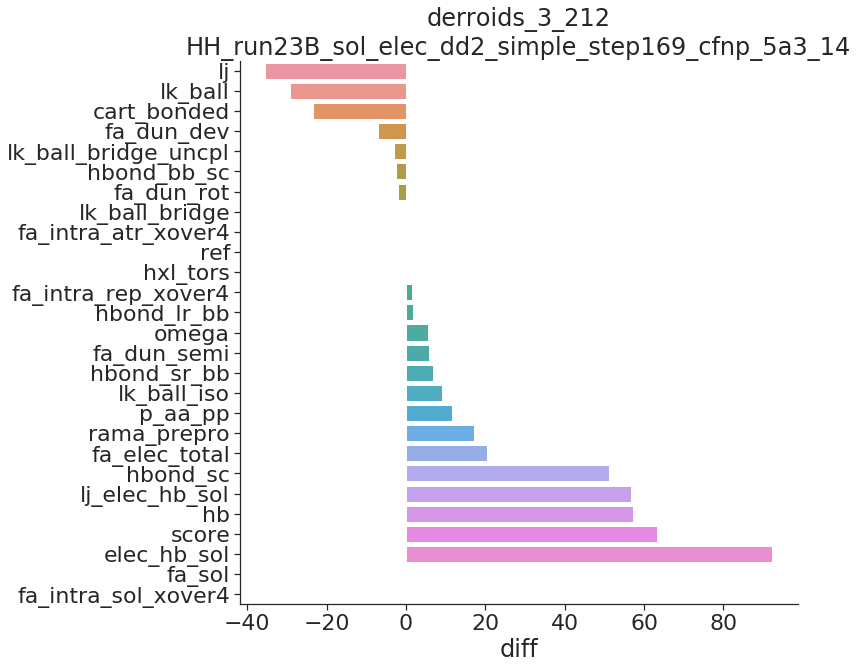

In [45]:
cols = [
    'pdb',
    'score',
    'fa_elec_total', #'fa_elec_poly_gly', 'fa_elec_corrected',
    'hbond_sc', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sr_bb',
    'hb',
    'lj', # 'fa_atr', 'fa_rep', #
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4', #'fa_intra_elec',
    'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'cart_bonded',
    'ref', #'dslf_fa13'
    'elec_hb_sol',
    'lj_elec_hb_sol',
]
data_to_plot = data[
    data['description'].isin([low_pdb_d, high_pdb_d])
][cols].copy()
data_to_plot.set_index('pdb', inplace=True)
data_to_plot = data_to_plot.transpose()
pdbs = list(data_to_plot.columns.values)
data_to_plot['diff'] = data_to_plot[pdbs[1]] - data_to_plot[pdbs[0]]
data_to_plot.sort_values('diff', inplace=True)

plt.figure(figsize=[10,10])
sns.barplot(y=data_to_plot.index, x='diff', data=data_to_plot)
plt.title(f'{pdb_str}\n{e_function}')
sns.despine()
plt.show()

In [46]:
if True:
    new_pdb_dir = f'results/eye_test_cr/{e_function}/{pdb_str}/'
    if not os.path.isdir(new_pdb_dir):
        os.makedirs(new_pdb_dir)
    for pdb in [low_pdb, high_pdb]:
        shutil.copy(pdb, new_pdb_dir)
    gaps_out_file = os.path.join(new_pdb_dir, 'egaps.csv')
    data_to_plot.to_csv(gaps_out_file)

In [47]:
new_pdb_dir

'results/eye_test_cr/HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14/derroids_3_212/'

Plot the changes in energy gaps between energy functions

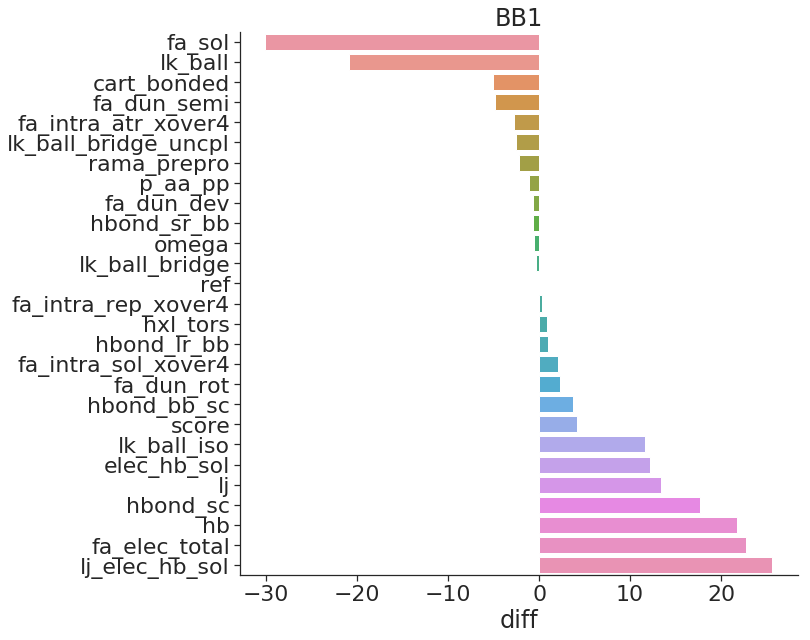

In [95]:
e_functions = [
#     'beta16.nostab-refit',
    'HH_run19A_step266',
    'HH_run19A_step266_dd2_elec_5a14',    
#     'HH_run23A_step384',
#     'HH_run23B_sol_elec_dd2_simple_step169',
]
dfs = []
for e_function in e_functions:
    gap_file = f'results/eye_test_cr/{e_function}/{pdb_str}/egaps.csv'
    df = pandas.read_csv(gap_file)
    df['e_function'] = e_function
    dfs.append(df)
df = pandas.concat(dfs, sort=False)
df.rename(columns={'Unnamed: 0': 'score_term'}, inplace=True)
df = df.pivot(index='score_term', columns='e_function', values='diff')
df['diff'] = df[e_functions[1]] - df[e_functions[0]]

df.sort_values('diff', inplace=True)

plt.figure(figsize=[10,10])
sns.barplot(y=df.index, x='diff', data=df)
plt.title(f'{pdb_str}')
plt.ylabel('')
sns.despine()
plt.show()

**Observations**

* DHD_131 ddE (19A vs. 19A_5e3)
    * fa_dun_rot compensating in direction of design
    
* DHD127 ddE (19A vs. 19A_5e3)
    * fa_dun_rot compensating in direction of design
    
* derroids_212
    * fa_dun_rot and cart_bonded compensating

* CAV1
    * LJ compensating in direction of design
    
* HFuse
    * LJ compensating in direction of design

Analyze per-residue energies from above xtal/design pair

In [43]:
if False:
    pdb_str = 'BB1' # 'DHD_131' # 'CAV1' # 
    rms_tag = 'xtal_rms'
    e_function = 'HH_run19A_step266' # 'HH_run19A_step266_dd2_elec_5a' # 'beta16.nostab-refit' #
    metric = 'score'
    design_or_xtal = 'xtal' #  'design' #  
    data = scores_df[
        (scores_df['pdb'].str.contains(pdb_str)) &
        (scores_df['design_or_xtal'] == design_or_xtal) &
        (scores_df['e_function'] == (e_function)) &
        (scores_df['relax_dir'] == 'cartesian_relax_cr') &
        (scores_df['poly_gly'] == False) &
        (scores_df['rms_tag'] == rms_tag) &
        (scores_df['relax_or_score'].str.contains('score')) &
        ~(scores_df['score'].isnull())
    ].copy()
    data.sort_values(metric, inplace=True)
    low_pdb = data['pdb_path'].iloc[0]
    
    e_function = 'HH_run19A_step266_dd2_elec_5a14' # 'beta16.nostab-refit' #
    data = scores_df[
        (scores_df['pdb'].str.contains(pdb_str)) &
        (scores_df['design_or_xtal'] == design_or_xtal) &
        (scores_df['e_function'] == (e_function)) &
        (scores_df['relax_dir'] == 'cartesian_relax_cr') &
        (scores_df['poly_gly'] == False) &
        (scores_df['rms_tag'] == rms_tag) &
        (scores_df['relax_or_score'].str.contains('score')) &
        ~(scores_df['score'].isnull())
    ].copy()
    data.sort_values(metric, inplace=True)
    high_pdb = data['pdb_path'].iloc[0]

In [44]:
low_df = hbond_cart_utils.compute_per_residue_energies(low_pdb)
high_df = hbond_cart_utils.compute_per_residue_energies(high_pdb)
low_df['lj'] = low_df['fa_atr'] + low_df['fa_rep']
low_df['lj_elec_hb_sol'] = low_df[[
    'lj', 'fa_elec',
    'hbond_sc', 'hbond_bb_sc', 'hbond_sr_bb', 'hbond_lr_bb',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
]].sum(axis=1)
high_df['lj'] = high_df['fa_atr'] + high_df['fa_rep']
high_df['lj_elec_hb_sol'] = high_df[[
    'lj', 'fa_elec',
    'hbond_sc', 'hbond_bb_sc', 'hbond_sr_bb', 'hbond_lr_bb',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
]].sum(axis=1)

65.5375625862314


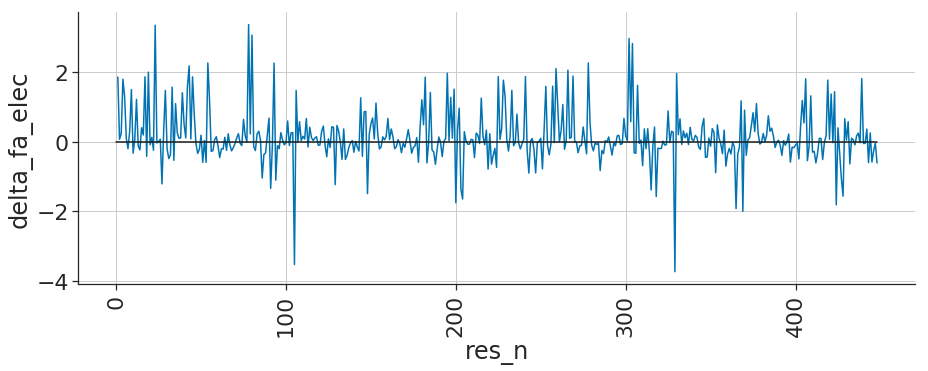

In [45]:
# Merge data
df = low_df.merge(
    high_df, on='res_n', suffixes=('_low', '_high')
)
assert sum(df['res_aa_low'] != df['res_aa_high']) == 0
df['res_n'].astype('int')

# Plot data
metric = 'fa_elec' # 'total_score' # 'lj' # 'fa_atr' # 'hbond_sc' # 'lj_elec_hb_sol' # 
df[f'delta_{metric}'] = \
    df[f'{metric}_low'] - df[f'{metric}_high']
print(sum(df[f'delta_{metric}']))
plt.figure(figsize=[15, 5])
df.sort_values('res_n', inplace=True)
sns.lineplot(
    x='res_n', y=f'delta_{metric}', data=df
)
plt.plot([0,len(df)], [0,0], c='k')
plt.xticks(rotation='vertical')
plt.grid()
sns.despine()
plt.show()

67.94307563905545


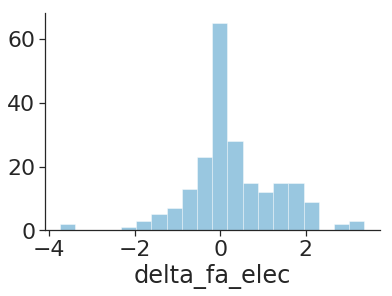

In [46]:
df_charged = df[df['res_aa_high'].isin([
    'K', 'R', 'E', 'D',
    'S', 'T', 'N', 'Q', 'H'
])]
print(df_charged[f'delta_{metric}'].sum())
sns.distplot(df_charged[f'delta_{metric}'], kde=False, bins=20)
sns.despine()
#plt.ylim(0,50)
plt.show()

In [47]:
df.sort_values(f'delta_{metric}', inplace=True, ascending=False)
df[[
    'res_n', f'delta_{metric}',
    f'{metric}_high', f'{metric}_low',
    'res_aa_high', 'res_aa_low'
]].set_index('res_n').head(n=20)

delta_fa_elec  fa_elec_high  fa_elec_low res_aa_high res_aa_low
res_n                                                                 
329        -3.743186     -1.328042    -5.071228           K          K
105        -3.536645     -1.295121    -4.831766           K          K
369        -2.006137     -1.598903    -3.605040           E          E
365        -1.926618     -1.427483    -3.354101           K          K
424        -1.817711     -2.349374    -4.167085           E          E
200        -1.757026     -2.380956    -4.137982           E          E
204        -1.651967     -1.117974    -2.769940           L          L
318        -1.579487     -1.451012    -3.030500           E          E
428        -1.568413     -1.130385    -2.698797           L          L
148        -1.495424     -2.142128    -3.637552           E          E
315        -1.390915     -3.221757    -4.612672           R          R
203        -1.366075     -3.375478    -4.741553           E          E
91         -1.344684     -2.714141    -4.058825           R          R
129        -1.237533     -5.548618    -6.786151           D          D
27         -1.214568     -5.355995    -6.570562           D          D
94         -1.110621     -1.428632    -2.539253           E          E
427        -1.060386     -3.396587    -4.456973           E          E
86         -1.047732     -3.030233    -4.077965           K          K
243        -0.904630     -5.561766    -6.466396           D          D
247        -0.899818     -4.088042    -4.987860           K          K

In [53]:
df[df['res_n'] == 719][[
    'res_n', f'delta_{metric}',
    f'{metric}_high', f'{metric}_low',
    'res_aa_high', 'res_aa_low'
]].head(n=20)

Empty DataFrame
Columns: [res_n, delta_fa_elec, fa_elec_high, fa_elec_low, res_aa_high, res_aa_low]
Index: []

CAV1 (comparing xtals relaxed w/ and w/out dd2)
* lj
    * V74: valine on surface of sheet; dd2 results in different rotamer, which deviates from xtal; slightly different bb geom?
    * R51, E55, E48: dd2 breaks two salt bridges, one of which is present in xtal; but it remakes one
    * H64: dd2 results in H being less packed; no salt bridges in either case; dd2 closer to xtal
    * K107, D89, E105: dd2 breaks two salt bridges present in xtal
    * N33: dd2 breaks a bb-sc H-bond not present in the xtal
    * R76: dd2 makes it so that this R isn't interacting as favorably with V74?
    * F91: on surface of sheet making fewer contacts with nearby sidechains? including V74?
    * K72: dd2 breaks salt bridge present in xtal
    * N39: dd2 breaks bb-sc H-bond that isn't present in xtal
    * H44: not sure what's going on, but different rotamer that may be less well packed
    * L52: related to R51 flipping out?
    * I78: related to H64 flipping out?

* ideas:
    * relax inflection point for long side-chains?
        * what is current inflection point, change by incriments of 0.5
    * increase scaling factor to 0.4, 0.6, 0.8?
    * double check which side chains are classified in which categories (small, medium, long).

LCB1
* elec:
    * K2: reaching between helices to make a sc-bb contact in design, but xtal has shifted to make that impossible
    * E11, E46: not clear, maybe subtle shifts
    * R14: flips in to make more buried H-bond w/ ONH2 rather than making two exposed interactions with OOCs

derroids_3_212
* mins below and above 2 A
    * hbond_sc gap persists:
        * partly due to Q residues making bidentate H-bonds
        * partly due to salt bridges that are still present
    
    * sol:
        * lk_ball favors xtal
        * and design has more H-bonds
            * bidentates bridging helices
            * charge-charge no network (e.g., R-D/E motifs at end of helix and beginning of loop that look like they appear over and over)
        * but sol favors design
            * sites favoring design
                * 3 and 50: making semi-buried H-bond in xtal but none in design
                * 152: making semi-buried H-bond in xtal but one exposed H-bond in design
                    * interesting rotamer difference between xtal and relaxed xtal; due to waters? long-range elec?
                * 87: R that is a bit more buried
                * 61: making larger number of semi-buried H-bonds in xtal
                * 15: L is packed tighter in design
        * ideas scale H-bond energies by depth
        * increase directionality of solvation term
        
        * more charged scs buried more tightly at around 151
    * biggest diff is a sc-sc saltbridge that isn't made in xtal, possibly due to big differences in loop conformation
    * D78 isn't making salt bridge in crystal, possibly due to a very subtle change in backbone angles
    * K54 is a lysine reaching across helices and making two salt bridges in design, and only one in xtal
    * K278 is similar to K54. Backbone rearragements bring the E/D much closer, which seems like it could make it difficult to make both interactions
    * many residues with intermediate deltas:
        * K17 making a salt bridge between helices in design. In the xtal, the helices are separated by a bigger distance, and the two residues are much further apart
        * others are salt bridges within the same helix, made in the design, but not the xtal

BBM2nHm0589
* mins below 0.1 and between 0.5-2
    * decreases in LJ/elec/hbond/sol
        * K102: making a salt bridge in relaxed xtal, due to helix being pulled 1.5A closer?
        * Q25: related to K102
        * N98 and D24: making an H-bond with SSEs being pulled closer
        * no big bb diffs: R106
    * decreases in LJ
        * R,R,H on surface, but no bb diffs
        * N98 reaching over to D; bb diffs
        * R96, I59, Q25: things packing a bit closer?
        * G71: sc-bb H-bond in one but not other

HFuse_pH192_3_0046
* mins below and above 3A
    * multiple biggest diffs are from a K that is making two salt bridges in the design, between two sides of the HFuse. But in the xtal, the two sides have moved, and residues get too far away to interact.
    * multiple biggest diffs are from S residues that make a bad H-bond with a nearby E in the design, but not in the xtal, possibly due to structural differences in the loop where the S residues (the C-alpha displacement is much bigger for the S than for the E, suggesting that that bond may no longer be possible).

* difference in fa_dun_rot appears to come from repeating motif where R makes an awk rotamer in xtal but not design. Interestingly, it is making two favorable semi-exposed salt bridges with nearby Es. Maybe that helps counter-balance things

LHD29
* no truncations made
* min below 0.25 RMS and min above 0.5 RMS
    * first biggest difference is with a S making a sc-bb interaction in one, but not the other
    * second is with an R making multiple interactions in one but not the other
    * third is with a D making a sc-bb interactio in one but not the other
    * fourth is really interesting: a K and E interaction. In the design, it is making a bad H-bond, but both oxygens are close. In the xtal, it is making a better H-bond (more in plane), but both oxygens are farther away, one by 0.7 A and the other by 1.4 A.

DHR4:
* min below 0.25 RMS and min above 0.5 RMS
    * K/E pair that is closer in design (1.9) than in xtal (4.1)
    * second and fourth relate to possible artifact at terminus, as described below
    * an S making a bad H-bond to an E in one structure, but not the other
    * contacting multiple R in the design, but none in the xtal
* truncated a few terminal residues
    * some energy differences may be artifactual due to C-terminus being artificially truncated

DHD127:
* big difference in fa_elec
    * biggest difference is with two charged residues that make a salt bridge in the relaxed design. In the relaxed xtal, the salt bridge is broken and only one of the partners is making another salt bridge
    * third difference is withe a K residue that is forming a different salt bridge between the two structures. This may be due to differences in the loops, where an E is able to make a sc-bb interaction in one, but not the other.
    * fourth difference is at a terminus
    * fifth probably involves backbone atoms
    * sixth is an R that is interacting with two Es in the design, but none in the xtal

Compute score of input poses with given energy function

In [25]:
e_function_dict.update({
    'HH_run19A_step266_env_dep9b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep9b',
        'extra_args' : []
    },
    
    'HH_run19A_step266_env_dep12b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_env_dep12b',
        'extra_args' : []
    },
    
    'HH_run20C_step461_new_hbpoly9b' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9b',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9c' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9c',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9c2' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9c2',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9d' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9d',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9e' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9e',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9f' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9f',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9g' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9g',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9h' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9h',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9i' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9i',
        'extra_args' : []
    },
    'HH_run20C_step461_new_hbpoly9j' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run20C_weights_461.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run20C_flags_461_new_hbpoly9j',
        'extra_args' : []
    },
})

In [28]:
score_app_path = '/home/haddox/Rosetta/main/source/bin/score.default.linuxgccrelease'
e_functions = [
    'HH_run19A_step266',
    'HH_run19A_step266_env_dep9a',
#     'HH_run19A_step266_env_dep9b',
#     'HH_run20C_step461_new_hbpoly9',
#     'HH_run20C_step461_new_hbpoly9b',
#     'HH_run20C_step461_new_hbpoly9c',
#     'HH_run20C_step461_new_hbpoly9c2',
#     'HH_run20C_step461_new_hbpoly9d',
#     'HH_run20C_step461_new_hbpoly9e',
#     'HH_run20C_step461_new_hbpoly9f',
#     'HH_run20C_step461_new_hbpoly9g',
#     'HH_run20C_step461_new_hbpoly9h',
#     'HH_run20C_step461_new_hbpoly9i',
#     'HH_run20C_step461_new_hbpoly9j',
    'HH_run19A_step266_env_dep12b',
]
poly_gly_low_pdb = low_pdb.replace('.pdb', '_polygly.pdb')
poly_gly_high_pdb = high_pdb.replace('.pdb', '_polygly.pdb')
assert os.path.isfile(poly_gly_low_pdb)
assert os.path.isfile(poly_gly_high_pdb)
output_dir = f'results/rescore/{pdb_str}/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
file_listing_pdbs = os.path.join(output_dir, 'pdbs.txt')
if not os.path.isfile(file_listing_pdbs):
    with open(file_listing_pdbs, 'w') as f:
        f.write(f'{high_pdb}\n')
        f.write(f'{low_pdb}\n')
        f.write(f'{poly_gly_low_pdb}\n')
        f.write(f'{poly_gly_high_pdb}\n')
for e_function in e_functions: 
    weights_file = e_function_dict[e_function]['cart_weights_file']
    flags_file = e_function_dict[e_function]['flags_file']
    extra_args = e_function_dict[e_function]['extra_args']
    output_dir = f'results/rescore/{pdb_str}/{e_function}/'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
        score_file_prefix = os.path.join(output_dir, 'score')
        design_utils.compute_score_using_rosettascripts(
            score_app_path=score_app_path,
            weights_file=weights_file,
            output_dir=output_dir,
            scores_file_prefix=score_file_prefix,
            file_listing_pdbs=file_listing_pdbs,
            flags_file=flags_file,
            extra_args=extra_args,
            submit_sbatch_job=True,
            queue_type='short',
            memory='2g'
        )

In [29]:
dfs = []
for e_function in e_functions: 
    output_dir = f'results/rescore/{pdb_str}/{e_function}/'
    score_file = os.path.join(output_dir, 'score.sc')
    if not os.path.isfile(score_file):
        continue
    df = pandas.read_csv(score_file, sep='\s+')
    df['e_function'] = e_function
    df['pdb'] = df['description'].apply(os.path.basename)
    dfs.append(df)
df = pandas.concat(dfs, sort=False)
df.sort_values(by=['pdb', 'e_function'], inplace=True)
df['total_sol'] = df[[
    'fa_sol', 'lk_ball', 'lk_ball_iso', 'lk_ball_bridge',
    'lk_ball_bridge_uncpl',
]].sum(axis=1)
df['lj_elec_hb_sol'] = df[[
    'fa_atr', 'fa_rep', 'fa_elec',
    'hbond_sc', 'hbond_bb_sc', 'hbond_sr_bb', 'hbond_lr_bb',
    'fa_sol', 'lk_ball', 'lk_ball_iso', 'lk_ball_bridge',
    'lk_ball_bridge_uncpl',
]].sum(axis=1)
#df.sort_index(inplace=True)
#df.reset_index(inplace=True)

cols = [
    #'pdb', 'e_function',
    'score',
    'fa_elec', 'fa_intra_elec',
    'hbond_sc',
    'hbond_bb_sc', 'hbond_sr_bb', 'hbond_lr_bb',
    'fa_atr', 'fa_rep',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
    'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'cart_bonded',
    'ref', 'dslf_fa13'
]
df = df[~df['pdb'].str.contains('gly')]
df.set_index(['pdb', 'e_function'], inplace=True)
display(df[cols])
df.reset_index(inplace=True)

score  \
pdb                                     e_function                               
HFuse_pH192_3_0046_design_mod_0001_0001 HH_run19A_step266            -6682.099   
                                        HH_run19A_step266_env_dep12b -3768.080   
                                        HH_run19A_step266_env_dep9a  -6552.339   
HFuse_pH192_3_0046_xtal_mod_0008_0001   HH_run19A_step266            -6631.900   
                                        HH_run19A_step266_env_dep12b -3748.954   
                                        HH_run19A_step266_env_dep9a  -6522.974   

                                                                       fa_elec  \
pdb                                     e_function                               
HFuse_pH192_3_0046_design_mod_0001_0001 HH_run19A_step266            -4400.501   
                                        HH_run19A_step266_env_dep12b -1925.540   
                                        HH_run19A_step266_env_dep9a  -4252.565   
HFuse_pH192_3_0046_xtal_mod_0008_0001   HH_run19A_step266            -4278.570   
                                        HH_run19A_step266_env_dep12b -1869.180   
                                        HH_run19A_step266_env_dep9a  -4152.991   

                                                                      fa_intra_elec  \
pdb                                     e_function                                    
HFuse_pH192_3_0046_design_mod_0001_0001 HH_run19A_step266                  -517.115   
                                        HH_run19A_step266_env_dep12b        -78.057   
                                        HH_run19A_step266_env_dep9a        -535.290   
HFuse_pH192_3_0046_xtal_mod_0008_0001   HH_run19A_step266                  -551.520   
                                        HH_run19A_step266_env_dep12b        -77.964   
                                        HH_run19A_step266_env_dep9a        -568.173   

                                                                      hbond_sc  \
pdb                                     e_function                               
HFuse_pH192_3_0046_design_mod_0001_0001 HH_run19A_step266             -376.499   
                                        HH_run19A_step266_env_dep12b  -376.499   
                                        HH_run19A_step266_env_dep9a   -376.499   
HFuse_pH192_3_0046_xtal_mod_0008_0001   HH_run19A_step266             -401.693   
                                        HH_run19A_step266_env_dep12b  -401.693   
                                        HH_run19A_step266_env_dep9a   -401.693   

                                                                      hbond_bb_sc  \
pdb                                     e_function                                  
HFuse_pH192_3_0046_design_mod_0001_0001 HH_run19A_step266                -145.583   
                                        HH_run19A_step266_env_dep12b     -145.583   
                                        HH_run19A_step266_env_dep9a      -145.583   
HFuse_pH192_3_0046_xtal_mod_0008_0001   HH_run19A_step266                -115.828   
                                        HH_run19A_step266_env_dep12b     -115.828   
                                        HH_run19A_step266_env_dep9a      -115.828   

                                                                      hbond_sr_bb  \
pdb                                     e_function                                  
HFuse_pH192_3_0046_design_mod_0001_0001 HH_run19A_step266               -1396.994   
                                        HH_run19A_step266_env_dep12b    -1396.994   
                                        HH_run19A_step266_env_dep9a     -1396.994   
HFuse_pH192_3_0046_xtal_mod_0008_0001   HH_run19A_step266               -1378.393   
                                        HH_run19A_step266_env_dep12b    -1378.393   
                                        HH_run19A_step266_env_dep9a     -1378.393   

                                           

In [95]:
metrics = [
    #'pdb', 'e_function',
    'score',
    'fa_elec',
    'hbond_sc',
    'total_sol',
    'lj_elec_hb_sol',
    'lk_ball',
    'fa_sol',
    'lk_ball_iso',
    'hbond_bb_sc', 'hbond_sr_bb', 'hbond_lr_bb',
    'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_atr', 'fa_rep',
    'fa_intra_elec',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
    'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'cart_bonded',
    'ref', 'dslf_fa13'
]
all_data = pandas.DataFrame()
for metric in metrics:
    data = df.pivot(values=metric, columns='pdb', index='e_function')
    pdbs = data.columns.values
    assert len(pdbs) == 2
    data[metric] = data[pdbs[1]] - data[pdbs[0]]
    if len(all_data) == 0:
        all_data = data[[metric]].copy()
    else:
        all_data = all_data.merge(
            data[[metric]], left_index=True, right_index=True
        )
    
all_data

pdb                               score  fa_elec  hbond_sc  total_sol  \
e_function                                                              
HH_run19A_step266                50.199  121.931   -25.194    -79.246   
HH_run19A_step266_env_dep9a      29.365   99.574   -25.194    -79.246   
HH_run19A_step266_env_dep9b      24.862   96.313   -25.194    -79.246   
HH_run20C_step461_new_hbpoly9    36.023  106.548   -49.520    -80.865   
HH_run20C_step461_new_hbpoly9b   38.514  106.548   -43.363    -80.865   
HH_run20C_step461_new_hbpoly9c   33.280  106.548   -43.363    -80.865   
HH_run20C_step461_new_hbpoly9c2  35.618  106.548   -34.357    -80.865   
HH_run20C_step461_new_hbpoly9d   26.707   99.905   -43.363    -80.865   
HH_run20C_step461_new_hbpoly9e   28.314   99.905   -40.628    -80.865   
HH_run20C_step461_new_hbpoly9f   26.609   99.905   -42.333    -80.865   
HH_run20C_step461_new_hbpoly9g   25.326   99.905   -43.617    -80.865   
HH_run20C_step461_new_hbpoly9h   28.946   99.905   -41.044    -80.865   
HH_run20C_step461_new_hbpoly9i   24.396   99.905   -40.003    -80.865   
HH_run20C_step461_new_hbpoly9j   27.000   99.905   -37.401    -80.865   

pdb                              lj_elec_hb_sol  lk_ball  fa_sol  lk_ball_iso  \
e_function                                                                      
HH_run19A_step266                        26.367  -61.163 -54.541       32.078   
HH_run19A_step266_env_dep9a               4.010  -61.163 -54.541       32.078   
HH_run19A_step266_env_dep9b               0.749  -61.163 -54.541       32.078   
HH_run20C_step461_new_hbpoly9            -1.225  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9b            1.266  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9c           -3.969  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9c2          -1.629  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9d          -10.612  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9e           -9.005  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9f          -10.710  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9g          -11.994  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9h           -8.372  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9i          -12.922  -76.101 -95.717       85.924   
HH_run20C_step461_new_hbpoly9j          -10.320  -76.101 -95.717       85.924   

pdb                              hbond_bb_sc  hbond_sr_bb  hbond_lr_bb  \
e_function                                                               
HH_run19A_step266                     29.755       18.601         0.79   
HH_run19A_step266_env_dep9a           29.755       18.601         0.79   
HH_run19A_step266_env_dep9b           29.755       18.601         0.79   
HH_run20C_step461_new_hbpoly9         43.800       18.372         0.71   
HH_run20C_step461_new_hbpoly9b        40.134       18.372         0.71   
HH_run20C_step461_new_hbpoly9c        34.899       18.372         0.71   
HH_run20C_step461_new_hbpoly9c2       28.233       18.372         0.71   
HH_run20C_step461_new_hbpoly9d        34.899       18.372         0.71   
HH_run20C_step461_new_hbpoly9e        33.771       18.372         0.71   
HH_run20C_step461_new_hbpoly9f        33.771       18.372         0.71   
HH_run20C_step461_new_hbpoly9g        33.771       18.372         0.71   
HH_run20C_step461_new_hbpoly9h        34.820       18.372         0.71   
HH_run20C_step461_new_hbpoly9i        29.229       18.372         0.71   
HH_run20C_step461_new_hbpoly9j        29.229       18.372         0.71   

pdb                              lk_ball_bridge  lk_ball_bridge_uncpl  fa_atr  \
e_function                                                                      
HH_run19A_step266                         0.136                 4.244 -40.347   
HH_run19A_step266_env_dep9a               0.136                 4.244 -40.347   
HH_run19A_step266_env_dep

Observations

* derroids_3_212
    * scaling elec only (9a) helps close the gap (fa_elec ~54->8), but there is still a large H-bond gap and small elec gap
        * helps to change range from 10-20 to 10-25
    * 20C_poly9 best and can flip gap with modifications, but H-bond still off
        * helps to change elec scale factor to 0.2
        * helps to decrease hbond weight for various don/acc, probably esp. for charged ones

* derroids_3_633
    * scaling elec only (9a) really helps close the gap (~52 -> ~38), but there is still gaps for H-bond
        * helps to change range from 10-20 to 10-25
    * 20C_poly9 doesn't help at first, but it does with extra modifications
        * helps to change elec scale factor to 0.2
        * helps to decrease hbond weight for charged don/acc
    
* HFuse
    * scaling elec only (9a) helps close the gap (~50 -> ~30), but there is still a huge gap in fa_elec and a medium one for hbond_bb_sc
    * 20C_poly9 also helps, but problems with elec, hond_bb_sc, rotameric energies, and fa_intra_sol
    * questions:
        * why doesn't scaling elec decrease the energy more?
            * bigger protein -> higher neighbor counts?
        * what accounts for the hb_bb_sc difference?
            * seems like S and E sc-bb interactions (e.g., E1318, S72)
        * why is fa_dun_rot so much worse for the relaxed xtal?
    
* MC2
    * scaling elec only (9a) helps a little (~24 -> ~18)
        * change in fa_elec might be expected given that about is due to bb
    * 20C_poly9 doesn't help much
    
* BBM2nHm0589
    * scaling elec only (9a) helps a little (~8-3)
    * 20C_poly9 initially doesn't help, but can flip gap to be negative with modifications (more depth dependence and weaker H-bond weights)
    
* DHD127
    * scaling elec only (9a) helps a little (~6 -> 3)
    * 20C_poly9 helps a bit, and can flip gap with modifications

Investigate different measures of burial

In [58]:
import pyrosetta
import pyrosetta.rosetta
init_flags = ' '.join([
    '-mute all', '-mute core', '-mute protocols',
    '-ignore_unrecognized_res', '-read_only_ATOM_entries',
])
pyrosetta.init(init_flags)

sf = pyrosetta.get_fa_scorefxn()

In [327]:
high_pdb

'/home/haddox/2020/compare_xtal_design_pairs/results/cartesian_relax/BBM2nHm0589_design_mod/HH_run19A_step266/BBM2nHm0589_design_mod_0003.pdb'

In [328]:
#pdb = 'data/designs_mod/DHR14_design_mod.pdb'
pose = pyrosetta.pose_from_pdb(high_pdb)
sf(pose)

-536.7535589665041

In [329]:
size = pose.size()
size

111

In [330]:
nbr_dict = {
    key : []
    for key in ['res_n', 'aa', 'n_nbrs']
}
for res_n in range(1, size+1):
    res = pose.residue(res_n)
    res_n_bools = [res_i == res_n for res_i in range(1, size+1)]
    res_n_vector1_bools = pyrosetta.Vector1(res_n_bools)
    nbr_bools = pyrosetta.rosetta.core.select.get_tenA_neighbor_residues(
        pose=pose,
        residue_positions=res_n_vector1_bools
    )
    nbr_dict['res_n'].append(res_n)
    nbr_dict['aa'].append(res.name1())
    nbr_dict['n_nbrs'].append(sum(nbr_bools) - 1)

nbr_df = pandas.DataFrame(nbr_dict)

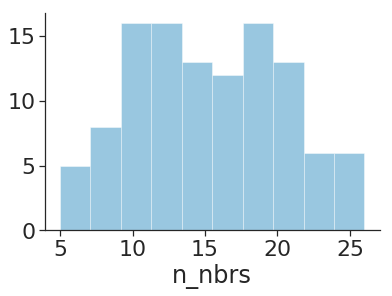

In [331]:
sns.distplot(nbr_df['n_nbrs'], kde=False, bins=10)
sns.despine()
plt.show()

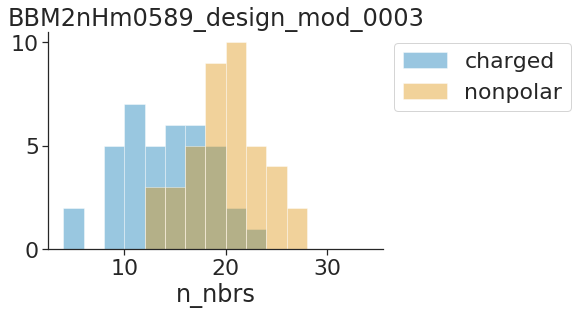

In [332]:
bins = np.arange(4, 35, 2)
aas = {
    'charged' : list('EDRK'),
    'polar' : list('ST'),
    'nonpolar' : list('ALIVMFWY'),
}
for group in ['charged', 'nonpolar']:
    data = nbr_df[nbr_df['aa'].isin(aas[group])]
    sns.distplot(
        data['n_nbrs'], kde=False, bins=bins,
        label=group,
    )
plt.legend(bbox_to_anchor=(1,1))
plt.title(
    os.path.basename(high_pdb).replace('.pdb', '')
)
sns.despine()
plt.show()

**Observations**
* derroids_3_212: charged distribution mostly below 20
* HFuse: charged distribution extends to ~25

In [257]:
nbr_df.sort_values('n_nbrs', inplace=True, ascending=True)
nbr_df[
    (nbr_df['aa'].isin(['D', 'E', 'R', 'K'])) &
    ~(nbr_df['aa'].isin([]))
].tail()

res_n aa  n_nbrs
1063   1064  E      25
111     112  E      25
307     308  R      25
1013   1014  E      25
1009   1010  R      25

In [260]:
nbr_df[nbr_df['res_n'].isin([348, 350, 431, 855])]

res_n aa  n_nbrs
349    350  E      16
347    348  D      16
854    855  K      18
430    431  R      21

Examples of cases where C-beta counts many not work
* From HFuse
    * K855: 18 neighbor counts
    * R431: 21 neighbor counts

In [49]:
nbr_df.sort_values('res_n', inplace=True, ascending=True)
nbr_df.head(n=20)

res_n aa  n_nbrs
0       1  P       9
1       2  R      14
2       3  S      13
3       4  Y      12
4       5  L      19
5       6  L      23
6       7  K      18
7       8  E      19
8       9  L      24
9      10  A      23
10     11  D      14
11     12  L      19
12     13  S      24
13     14  Q      16
14     15  H      13
15     16  L      23
16     17  V      22
17     18  R      12
18     19  L      20
19     20  L      25

**Initial observations from comparing design-xtal pairs of binders**

* IL7
    * clashing: xtal is noticeably shifted away from interface; can see multiple large clashes between hydrophobics across the interface
    * electrostatics: there are multiple electrostatic/H-bond interactions that are present in the design, but not in the xtal (e.g., K123, E19) and which probably cannot be recovered due to the overall shift of the monomer away from the xtal
    
* TrkA
    * clashing: xtal is noticeably shifted; can see large clashes between hydrophobics (e.g., F47 and nearby M)
    * electrostatics: see de-optimization of electrostatics across interface (e.g., R14 sc-bb H-bond; K10 salt bridge)
        * new buried elec interactions? H297

* LCB1 and LCB3
    * clashing: structures quite close, but some of the residues with the largest rearragements appear to have clashes (e.g., F180)

In [17]:
nbr_selector = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector()
nbr_selector.set_focus(str(1))
nbrs = nbr_selector.apply(pose)
print(len(nbrs))
nbrs

158


vector1_bool[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Refine crystal structures using Phenix and Rosetta

Questions for Frank:

1) Grab the pdb and structure factors:
phenix.fetch_pdb 1xxx
phenix.fetch_pdb -x 1xxx
phenix.cif_as_mtz --extend-flags 1xxx-sf.cif

2) clean the PDB
~dimaio/scripts/clean_pdb.pl 1xxx.pdb


3) make symmdef file
make_symmdef_file.pl -m CRYST -p 1xxx_clean.pdb > cryst.symm


4) then run crystal refinement
phenix.rosetta.run_phenix_interface \
~dimaio/Rosetta_stable/source/bin/rosetta_scripts.python.linuxgccrelease \
	-parser:protocol refine.xml \
	-s model.pdb \
	-cryst::mtzfile1xxx-sf.mtz \
	-crystal_refine

## Import `Python` modules

In [1]:
import os

In [ ]:
/software/phenix/latest/build/bin/phenix.fetch_pdb

In [ ]:
phenix.fetch_pdb 6dlm
phenix.fetch_pdb -x 6dlm

../../scripts/clean_pdb.pl 6dlm.pdb

~/Rosetta/main/source/src/apps/public/symmetry/make_symmdef_file.pl -m CRYST -p 6dlm_clean.pdb > cryst.symm

phenix.cif_as_mtz --extend-flags 6dlm-sf.cif

phenix.reflection_file_converter 6dlm-sf.mtz --label=FOBS,SIGFOBS --r_free_label=R-free-flags --mtz=6dlm-sf_mod.mtz

In [3]:
phenix_path = '/software/phenix/latest/build/bin/phenix'
run_phenix_interface = phenix_path + '.rosetta.run_phenix_interface'
rosetta_scripts = '/home/haddox/Rosetta/main/source/bin/rosetta_scripts.python.linuxgccrelease'
refine_xml = '/home/haddox/Rosetta/main/source/src/apps/public/crystal_refinement/high_resolution_refine.xml'
input_pdb = '6dlm_clean.pdb'
input_mtz = '6dlm-sf_mod.mtz'
input_symm = 'cryst.symm'

cmd = ' '.join([
    run_phenix_interface,
    rosetta_scripts,
    f'-parser:protocol {refine_xml}',
    f'-parser:script_vars symmdef={input_symm}',
    f'-s {input_pdb}',
    f'-cryst::mtzfile {input_mtz}',
    '-crystal_refine',
])
cmd

'/software/phenix/latest/build/bin/phenix.rosetta.run_phenix_interface /home/haddox/Rosetta/main/source/bin/rosetta_scripts.python.linuxgccrelease -parser:protocol /home/haddox/Rosetta/main/source/src/apps/public/crystal_refinement/high_resolution_refine.xml -parser:script_vars symmdef=cryst.symm -s 6dlm_clean.pdb -cryst::mtzfile 6dlm-sf_mod.mtz -crystal_refine'

In [9]:
phenix_path = 'phenix'
run_phenix_interface = phenix_path + '.rosetta.run_phenix_interface'
rosetta_scripts = '/home/dimaio/Rosetta_xtal_3660/source/bin/rosetta_scripts.python.linuxgccrelease'
refine_xml = '/home/dimaio/Rosetta_xtal_3660/source/src/apps/public/crystal_refinement/low_resolution_refine.xml'
#refine_xml = '/home/dimaio/projects/xtal_hires/refine.xml'
input_pdb = '6dlm_clean.pdb'
input_mtz = '6dlm-sf_mod.mtz'
input_symm = 'cryst.symm'

cmd = ' '.join([
    run_phenix_interface,
    rosetta_scripts,
    f'-parser:protocol {refine_xml}',
    f'-parser:script_vars symmdef={input_symm}',
    f'-s {input_pdb}',
    f'-cryst::mtzfile {input_mtz}',
    '-crystal_refine',
    '-set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res',
])
cmd

'phenix.rosetta.run_phenix_interface /home/dimaio/Rosetta_xtal_3660/source/bin/rosetta_scripts.python.linuxgccrelease -parser:protocol /home/dimaio/Rosetta_xtal_3660/source/src/apps/public/crystal_refinement/low_resolution_refine.xml -parser:script_vars symmdef=cryst.symm -s 6dlm_clean.pdb -cryst::mtzfile 6dlm-sf_mod.mtz -crystal_refine -set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res'

This works

In [ ]:
phenix.rosetta.run_phenix_interface /home/longxing/Rifdock/rosetta_rifdock/source/bin/rosetta_scripts.python.linuxgccrelease -database /home/longxing/Rifdock/rosetta_rifdock/database/ -parser:protocol /home/longxing/Rifdock/rosetta_rifdock/source/src/apps/public/crystal_refinement/low_resolution_refine.xml -parser::script_vars input.xray_data.r_free_flags.generate=True symmdef=cryst.symm bfactstrat=individual map_type=Auto -s 6dlm_clean.pdb -mtzfile 6dlm-sf_mod.mtz -crystal_refine -set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res

Changing the version of phenix breaks it

In [ ]:
/software/phenix/latest/build/bin/phenix.rosetta.run_phenix_interface /home/longxing/Rifdock/rosetta_rifdock/source/bin/rosetta_scripts.python.linuxgccrelease -database /home/longxing/Rifdock/rosetta_rifdock/database/ -parser:protocol /home/longxing/Rifdock/rosetta_rifdock/source/src/apps/public/crystal_refinement/low_resolution_refine.xml -parser::script_vars input.xray_data.r_free_flags.generate=True symmdef=cryst.symm bfactstrat=individual map_type=Auto -s 6dlm_clean.pdb -mtzfile 6dlm-sf_mod.mtz -crystal_refine -set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res

Changing to Frank's version of Rosetta breaks it

In [ ]:
phenix.rosetta.run_phenix_interface /home/dimaio/Rosetta_xtal_3660/source/bin/rosetta_scripts.python.linuxgccrelease -database /home/dimaio/Rosetta_xtal_3660/database/ -parser:protocol /home/dimaio/Rosetta_xtal_3660/source/src/apps/public/crystal_refinement/low_resolution_refine.xml -parser::script_vars input.xray_data.r_free_flags.generate=True symmdef=cryst.symm bfactstrat=individual map_type=Auto -s 6dlm_clean.pdb -mtzfile 6dlm-sf_mod.mtz -crystal_refine -set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res

Changing both at once

In [ ]:
/software/phenix/latest/build/bin/phenix.rosetta.run_phenix_interface /home/dimaio/Rosetta_xtal_3660/source/bin/rosetta_scripts.python.linuxgccrelease -database /home/dimaio/Rosetta_xtal_3660/database/ -parser:protocol /home/dimaio/Rosetta_xtal_3660/source/src/apps/public/crystal_refinement/low_resolution_refine.xml -parser::script_vars input.xray_data.r_free_flags.generate=True symmdef=cryst.symm bfactstrat=individual map_type=Auto -s 6dlm_clean.pdb -mtzfile 6dlm-sf_mod.mtz -crystal_refine -set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res

In [ ]:
phenix.rosetta.run_phenix_interface /home/dimaio/Rosetta_xtal_3660/source/bin/rosetta_scripts.python.linuxgccrelease -database /home/dimaio/Rosetta_xtal_3660/database/ -parser:protocol /home/dimaio/Rosetta_xtal_3660/source/src/apps/public/crystal_refinement/low_resolution_refine.xml -parser::script_vars input.xray_data.r_free_flags.generate=True symmdef=cryst.symm bfactstrat=individual map_type=Auto -s 6dlm_clean.pdb -mtzfile 6dlm-sf_mod.mtz -crystal_refine -set_weights cart_bonded 0.5 pro_close 0 -ignore_unrecognized_res

## Run the refinement command

In [ ]:
xml = ''
cmd = ' '.join([
    'phenix.rosetta.run_phenix_interface',
    '/home/haddox/Rosetta/main/source/bin/rosetta_scripts.python.linuxgccrelease',
    f'-parser:protocol {xml}',
    
])

    
    
    -s infile.pdb \
    -parser:script_vars symmdef=cryst.symm \
    -cryst::mtzfile infile.mtz \
    -crystal_refine